In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import pickle


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from src.models import wgan#, aae  # , vae
 
from src.common.helperfunctions import *
from src.common.accuracy_XGboost import *


import xgboost as xgb
import time
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    recall_score,
    precision_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_name = 'data/raw/creditcard.csv'
df = pd.read_csv(file_name)
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [3]:
label_col = []
feature_cols = []
label_col = [i for i in df.columns if 'Class' in i]
feature_cols = [i for i in df.columns if i not in label_col]

In [4]:
# X = df.loc[:,feature_cols]
# y = df.loc[:,label_col]

In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [6]:
# train = pd.concat([train_X, train_y], axis=1)

In [7]:
sc = StandardScaler()
train.loc[:,'Amount'] = sc.fit_transform(train.Amount.values.reshape(-1, 1))
train.loc[:,'Time'] = sc.fit_transform(train.Time.values.reshape(-1, 1))
test.loc[:,'Amount'] = sc.transform(test.Amount.values.reshape(-1, 1))
test.loc[:,'Time'] = sc.transform(test.Time.values.reshape(-1, 1))
# train.drop('Time',axis=1, inplace=True)
# test.drop('Time', axis=1, inplace=True)

/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [8]:
# mxs = MinMaxScaler()
# train.iloc[:,:] = mxs.fit_transform(train.iloc[:,:].values)
# test.iloc[:,:] = mxs.transform(test.iloc[:,:].values)
# # train.drop('Time',axis=1, inplace=True)
# # test.drop('Time', axis=1, inplace=True)

In [9]:
train_Class = train[train.Class == 1]

In [10]:
label_col = []
feature_cols = []
label_col = [i for i in train.columns if 'Class' in i]
feature_cols = [i for i in train.columns if i not in label_col]

# Train GAN

In [11]:
train_Class.drop('Class', axis = 1,inplace=True)
# train_Class.drop('Time', axis = 1,inplace=True)

/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [12]:
train_Class.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [13]:
dataloader = prepareDataset(train_Class, batch_size = 64, device = 'cpu', withLabel = False)

In [14]:
dataloader.dataset.features.size(1)

30

Generator(
  (main): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=512, out_features=30, bias=True)
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=30, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)
Starting Training Loop...
394 394
epoch: 0, Accuracy: 0.9771573604060914
[0/5001]	Loss_D: -0.0048	Loss_G: -0.0097	


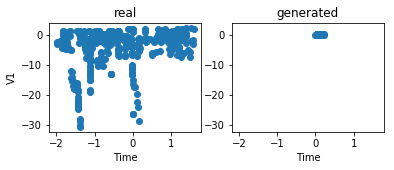

394 394
epoch: 10, Accuracy: 1.0
[10/5001]	Loss_D: -1.9880	Loss_G: 2.5637	


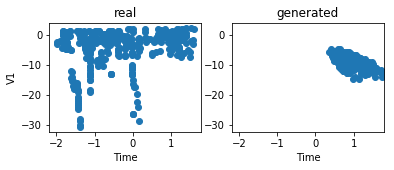

394 394
epoch: 20, Accuracy: 0.868020304568528
[20/5001]	Loss_D: -1.6764	Loss_G: -0.6157	


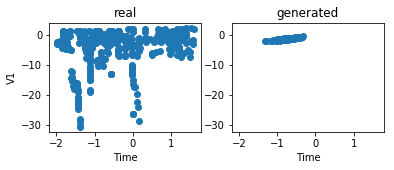

394 394
epoch: 30, Accuracy: 0.9898477157360406
[30/5001]	Loss_D: -0.8333	Loss_G: -0.4814	


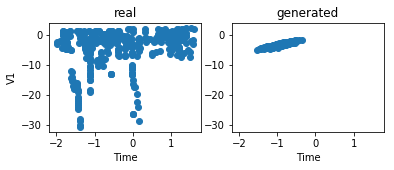

394 394
epoch: 40, Accuracy: 0.9847715736040609
[40/5001]	Loss_D: -0.4097	Loss_G: 1.2211	


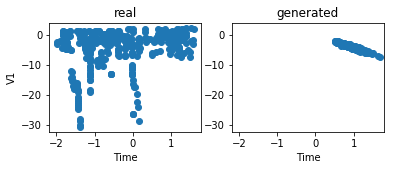

394 394
epoch: 50, Accuracy: 1.0
[50/5001]	Loss_D: -0.4580	Loss_G: 0.0078	


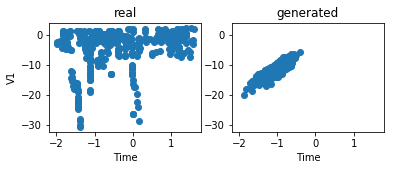

394 394
epoch: 60, Accuracy: 0.9923857868020305
[60/5001]	Loss_D: -0.2293	Loss_G: 0.0052	


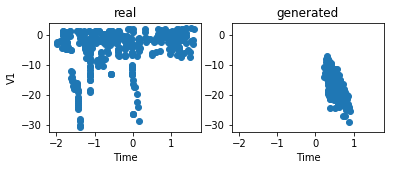

394 394
epoch: 70, Accuracy: 1.0
[70/5001]	Loss_D: -0.2772	Loss_G: 0.0351	


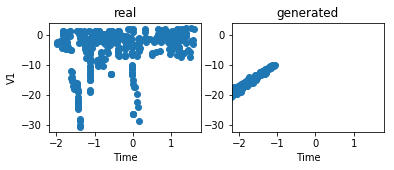

394 394
epoch: 80, Accuracy: 0.9923857868020305
[80/5001]	Loss_D: -1.9071	Loss_G: 0.2705	


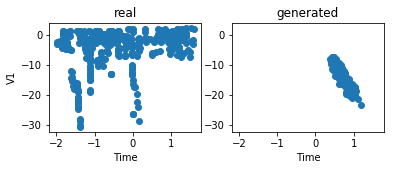

394 394
epoch: 90, Accuracy: 1.0
[90/5001]	Loss_D: -0.5545	Loss_G: 0.2189	


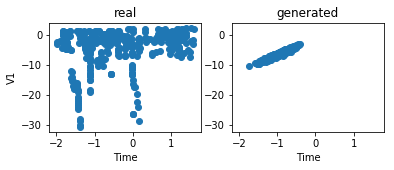

394 394
epoch: 100, Accuracy: 0.9796954314720813
[100/5001]	Loss_D: -0.3798	Loss_G: 0.1189	


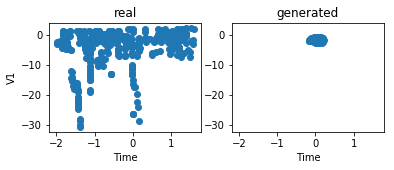

394 394
epoch: 110, Accuracy: 0.9746192893401016
[110/5001]	Loss_D: -1.7734	Loss_G: -0.1168	


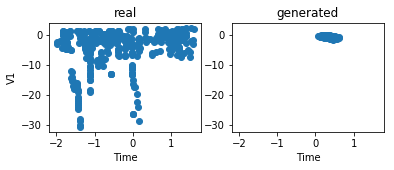

394 394
epoch: 120, Accuracy: 0.9822335025380711
[120/5001]	Loss_D: -1.3459	Loss_G: 0.3501	


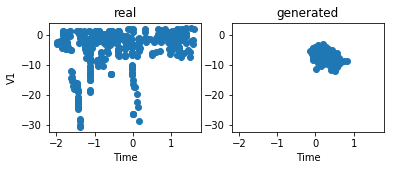

394 394
epoch: 130, Accuracy: 0.9949238578680203
[130/5001]	Loss_D: -0.5358	Loss_G: 0.0004	


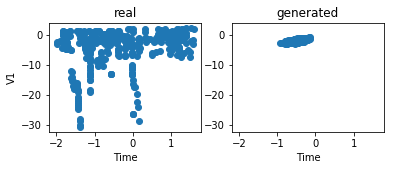

394 394
epoch: 140, Accuracy: 0.9898477157360406
[140/5001]	Loss_D: -0.6728	Loss_G: -0.0166	


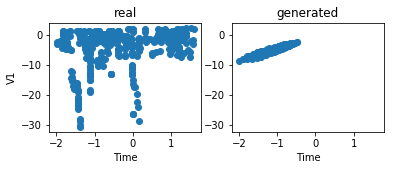

394 394
epoch: 150, Accuracy: 0.9746192893401016
[150/5001]	Loss_D: -0.9175	Loss_G: 0.0809	


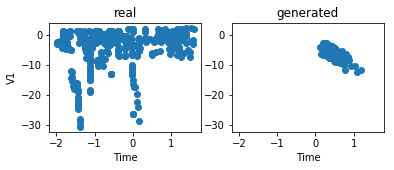

394 394
epoch: 160, Accuracy: 0.9949238578680203
[160/5001]	Loss_D: -0.5207	Loss_G: -0.0784	


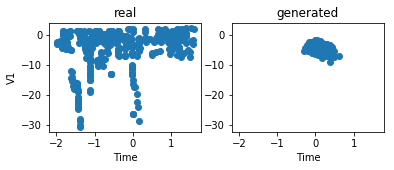

394 394
epoch: 170, Accuracy: 1.0
[170/5001]	Loss_D: -0.5727	Loss_G: 0.0210	


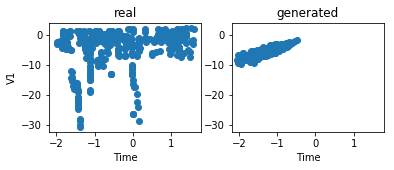

394 394
epoch: 180, Accuracy: 0.9898477157360406
[180/5001]	Loss_D: -0.8266	Loss_G: -0.0466	


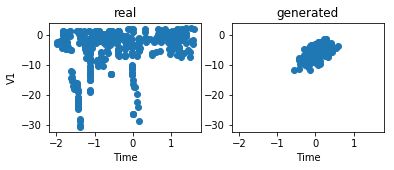

394 394
epoch: 190, Accuracy: 0.9746192893401016
[190/5001]	Loss_D: -0.8771	Loss_G: -0.1464	


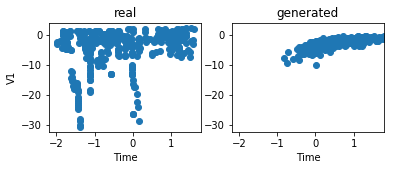

394 394
epoch: 200, Accuracy: 0.9746192893401016
[200/5001]	Loss_D: -0.4829	Loss_G: -0.2574	


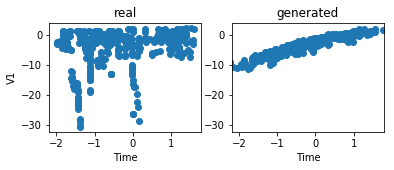

394 394
epoch: 210, Accuracy: 0.9949238578680203
[210/5001]	Loss_D: -0.1887	Loss_G: 0.0598	


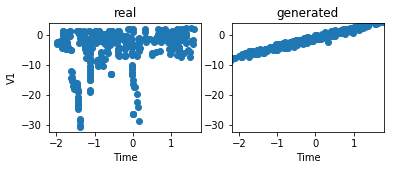

394 394
epoch: 220, Accuracy: 1.0
[220/5001]	Loss_D: -1.4638	Loss_G: 1.6922	


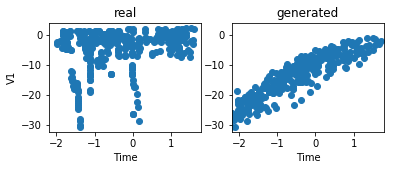

394 394
epoch: 230, Accuracy: 0.9898477157360406
[230/5001]	Loss_D: 0.0188	Loss_G: 0.0283	


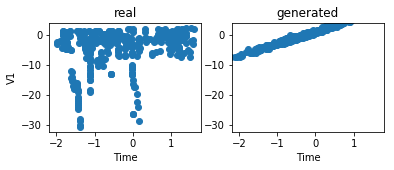

394 394
epoch: 240, Accuracy: 0.9771573604060914
[240/5001]	Loss_D: -0.0705	Loss_G: 0.0805	


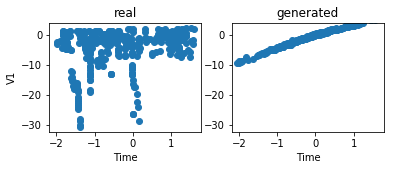

394 394
epoch: 250, Accuracy: 0.9619289340101523
[250/5001]	Loss_D: -0.1966	Loss_G: -0.3064	


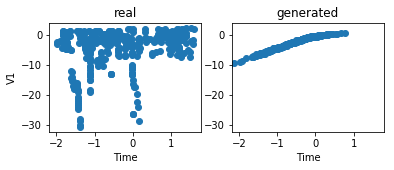

394 394
epoch: 260, Accuracy: 0.9847715736040609
[260/5001]	Loss_D: -0.0187	Loss_G: -0.0470	


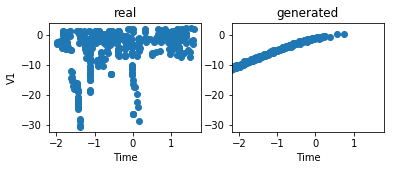

394 394
epoch: 270, Accuracy: 0.9720812182741116
[270/5001]	Loss_D: -0.0354	Loss_G: -0.0456	


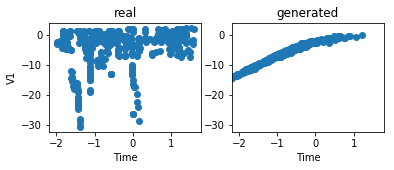

394 394
epoch: 280, Accuracy: 0.9746192893401016
[280/5001]	Loss_D: -0.0083	Loss_G: -0.0313	


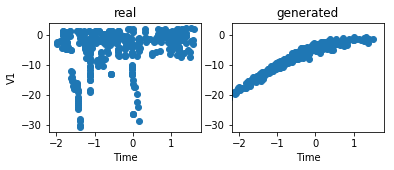

394 394
epoch: 290, Accuracy: 0.9898477157360406
[290/5001]	Loss_D: -0.0121	Loss_G: -0.0133	


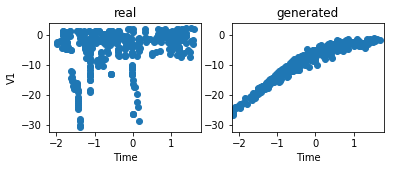

394 394
epoch: 300, Accuracy: 0.9898477157360406
[300/5001]	Loss_D: -0.0106	Loss_G: -0.0119	


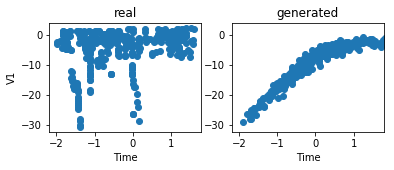

394 394
epoch: 310, Accuracy: 0.9796954314720813
[310/5001]	Loss_D: -0.0101	Loss_G: -0.0118	


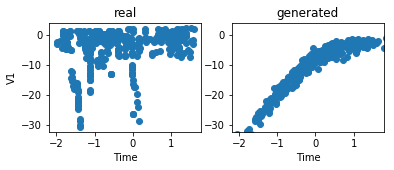

394 394
epoch: 320, Accuracy: 0.9898477157360406
[320/5001]	Loss_D: -0.0091	Loss_G: -0.0116	


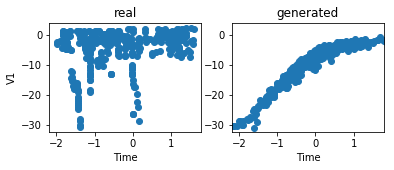

394 394
epoch: 330, Accuracy: 0.9670050761421319
[330/5001]	Loss_D: -0.4645	Loss_G: 0.6866	


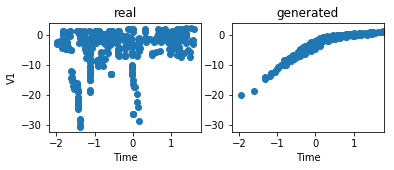

394 394
epoch: 340, Accuracy: 0.9670050761421319
[340/5001]	Loss_D: -0.1224	Loss_G: -0.5065	


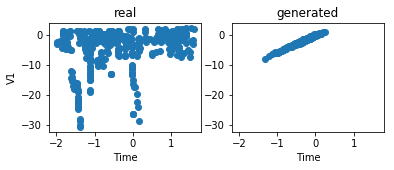

394 394
epoch: 350, Accuracy: 0.8781725888324873
[350/5001]	Loss_D: -2.8997	Loss_G: 7.5842	


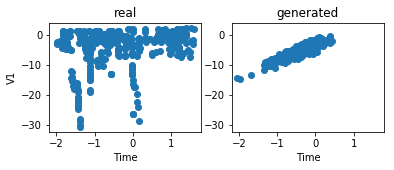

394 394
epoch: 360, Accuracy: 0.9771573604060914
[360/5001]	Loss_D: -0.3419	Loss_G: -0.1104	


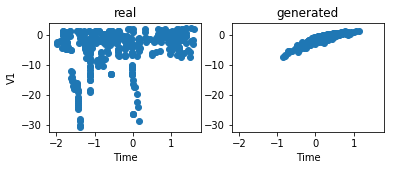

394 394
epoch: 370, Accuracy: 0.9796954314720813
[370/5001]	Loss_D: -0.3528	Loss_G: -0.2388	


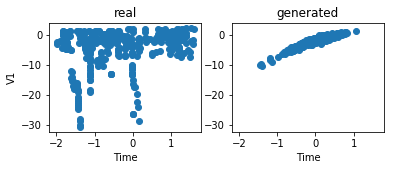

394 394
epoch: 380, Accuracy: 0.9796954314720813
[380/5001]	Loss_D: 0.0566	Loss_G: -0.5532	


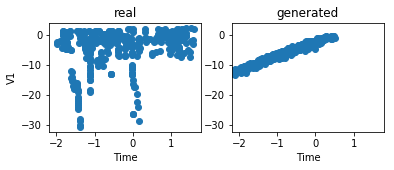

394 394
epoch: 390, Accuracy: 0.9847715736040609
[390/5001]	Loss_D: 0.0009	Loss_G: -0.0322	


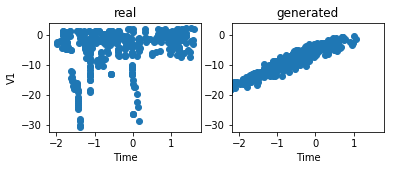

394 394
epoch: 400, Accuracy: 0.9720812182741116
[400/5001]	Loss_D: 0.0012	Loss_G: -0.0218	


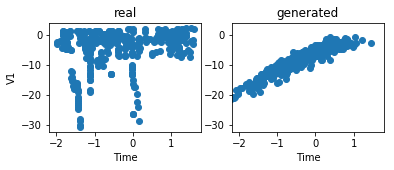

394 394
epoch: 410, Accuracy: 0.9543147208121827
[410/5001]	Loss_D: -0.0014	Loss_G: -0.0153	


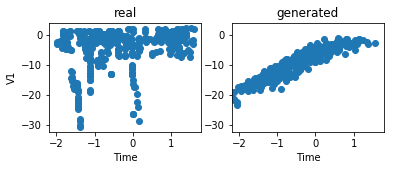

394 394
epoch: 420, Accuracy: 0.9796954314720813
[420/5001]	Loss_D: -0.0032	Loss_G: -0.0152	


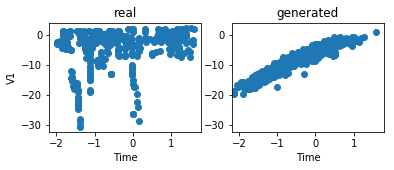

394 394
epoch: 430, Accuracy: 0.9670050761421319
[430/5001]	Loss_D: -0.0130	Loss_G: -0.0173	


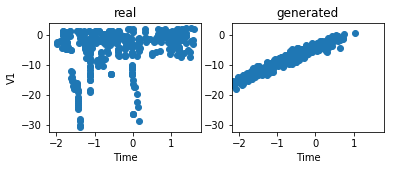

394 394
epoch: 440, Accuracy: 0.9873096446700508
[440/5001]	Loss_D: -0.0087	Loss_G: -0.0136	


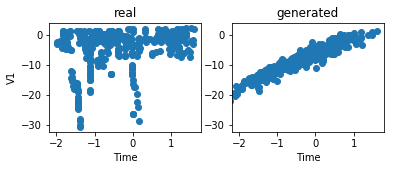

394 394
epoch: 450, Accuracy: 0.9543147208121827
[450/5001]	Loss_D: -0.2878	Loss_G: 0.5856	


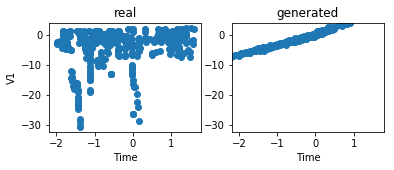

394 394
epoch: 460, Accuracy: 0.9568527918781726
[460/5001]	Loss_D: -0.3548	Loss_G: -0.2992	


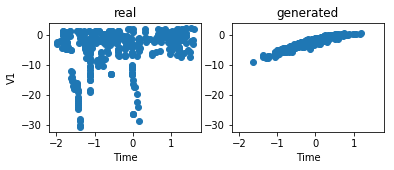

394 394
epoch: 470, Accuracy: 0.9847715736040609
[470/5001]	Loss_D: -0.0452	Loss_G: -0.2125	


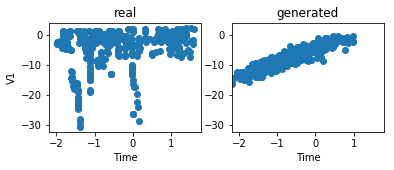

394 394
epoch: 480, Accuracy: 0.9949238578680203
[480/5001]	Loss_D: -0.0207	Loss_G: -0.0383	


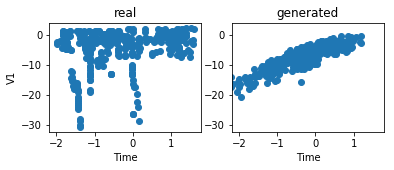

394 394
epoch: 490, Accuracy: 0.9670050761421319
[490/5001]	Loss_D: -0.0141	Loss_G: -0.0203	


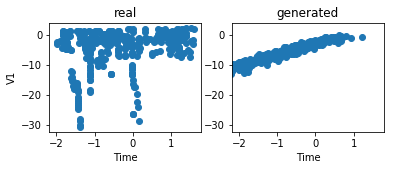

394 394
epoch: 500, Accuracy: 0.9847715736040609
[500/5001]	Loss_D: -0.0168	Loss_G: -0.0125	


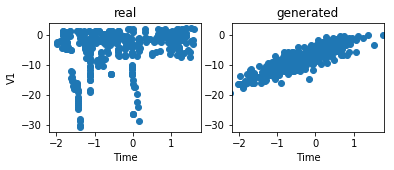

394 394
epoch: 510, Accuracy: 0.9086294416243654
[510/5001]	Loss_D: -0.4249	Loss_G: 1.4749	


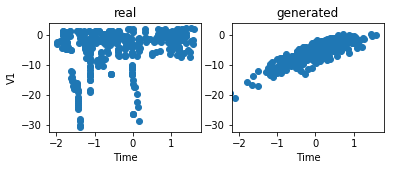

394 394
epoch: 520, Accuracy: 0.9822335025380711
[520/5001]	Loss_D: -0.0967	Loss_G: 0.0753	


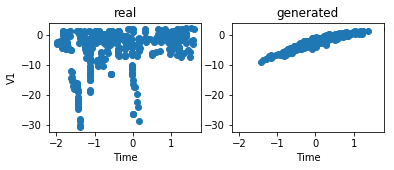

394 394
epoch: 530, Accuracy: 0.9771573604060914
[530/5001]	Loss_D: 0.1452	Loss_G: -0.8879	


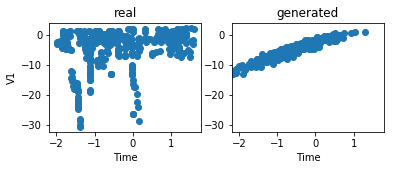

394 394
epoch: 540, Accuracy: 0.9873096446700508
[540/5001]	Loss_D: 0.0006	Loss_G: -0.0127	


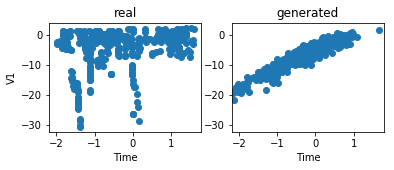

394 394
epoch: 550, Accuracy: 0.9543147208121827
[550/5001]	Loss_D: -0.3534	Loss_G: 0.5094	


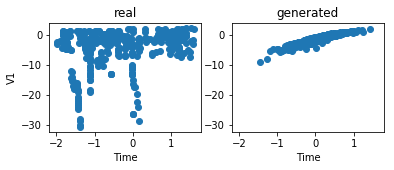

394 394
epoch: 560, Accuracy: 0.9746192893401016
[560/5001]	Loss_D: -0.3186	Loss_G: 0.3251	


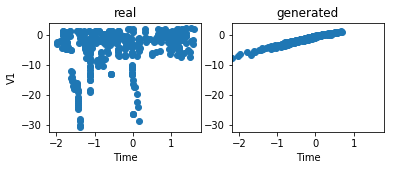

394 394
epoch: 570, Accuracy: 0.9670050761421319
[570/5001]	Loss_D: -0.2666	Loss_G: 0.1941	


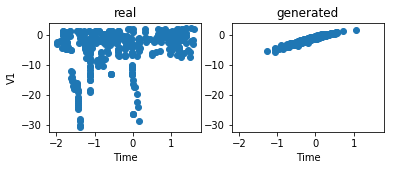

394 394
epoch: 580, Accuracy: 0.9873096446700508
[580/5001]	Loss_D: -0.2366	Loss_G: 0.1815	


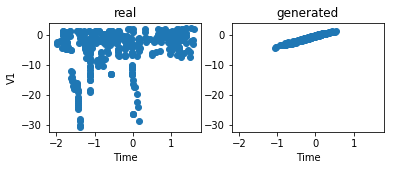

394 394
epoch: 590, Accuracy: 0.9949238578680203
[590/5001]	Loss_D: -0.4905	Loss_G: -0.4718	


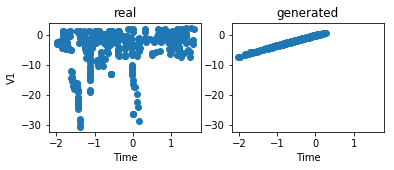

394 394
epoch: 600, Accuracy: 0.9746192893401016
[600/5001]	Loss_D: -0.0166	Loss_G: -0.0406	


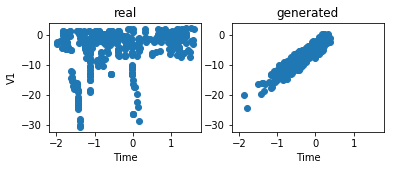

394 394
epoch: 610, Accuracy: 0.9746192893401016
[610/5001]	Loss_D: -0.0359	Loss_G: -0.0389	


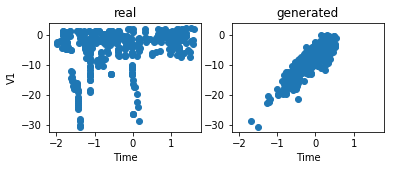

394 394
epoch: 620, Accuracy: 0.9822335025380711
[620/5001]	Loss_D: -0.0118	Loss_G: -0.0273	


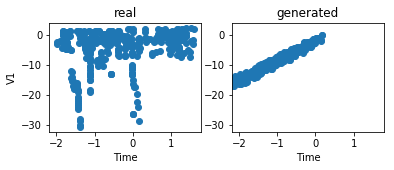

394 394
epoch: 630, Accuracy: 0.9898477157360406
[630/5001]	Loss_D: -0.0786	Loss_G: 0.1575	


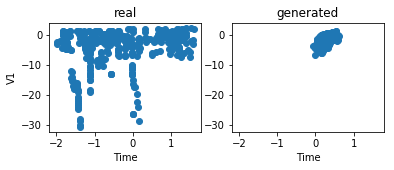

394 394
epoch: 640, Accuracy: 0.9796954314720813
[640/5001]	Loss_D: -0.1849	Loss_G: -0.1404	


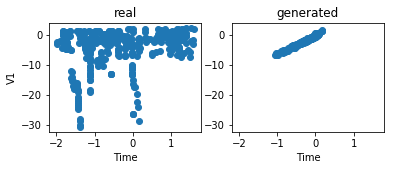

394 394
epoch: 650, Accuracy: 0.9873096446700508
[650/5001]	Loss_D: -0.1637	Loss_G: -0.2225	


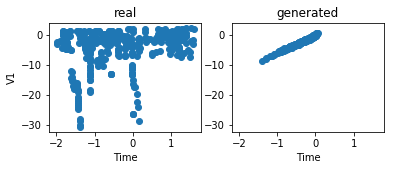

394 394
epoch: 660, Accuracy: 0.9898477157360406
[660/5001]	Loss_D: -0.0347	Loss_G: -0.3217	


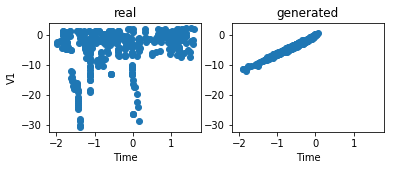

394 394
epoch: 670, Accuracy: 0.9847715736040609
[670/5001]	Loss_D: 0.0045	Loss_G: -0.0366	


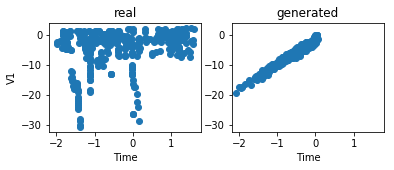

394 394
epoch: 680, Accuracy: 0.9644670050761421
[680/5001]	Loss_D: -0.0010	Loss_G: -0.0162	


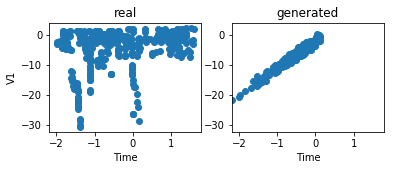

394 394
epoch: 690, Accuracy: 0.9796954314720813
[690/5001]	Loss_D: -0.0056	Loss_G: -0.0127	


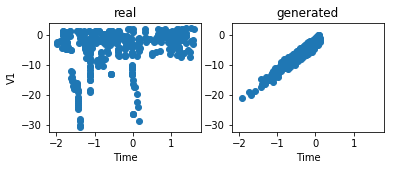

394 394
epoch: 700, Accuracy: 0.9771573604060914
[700/5001]	Loss_D: -0.0089	Loss_G: -0.0144	


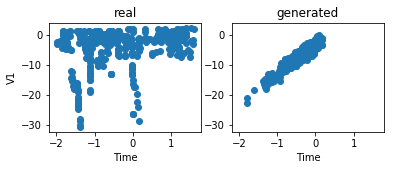

394 394
epoch: 710, Accuracy: 0.9771573604060914
[710/5001]	Loss_D: -0.0063	Loss_G: -0.0130	


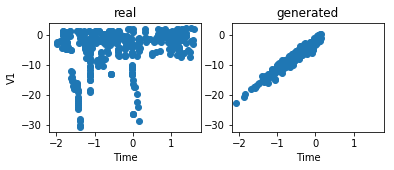

394 394
epoch: 720, Accuracy: 0.9720812182741116
[720/5001]	Loss_D: -0.0072	Loss_G: -0.0124	


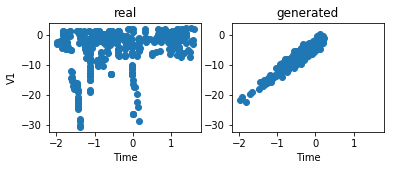

394 394
epoch: 730, Accuracy: 0.9796954314720813
[730/5001]	Loss_D: -0.0747	Loss_G: 0.0602	


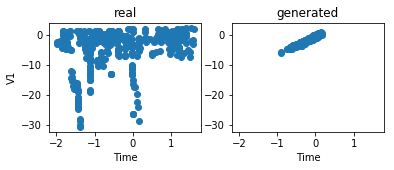

394 394
epoch: 740, Accuracy: 0.9796954314720813
[740/5001]	Loss_D: -0.2631	Loss_G: -0.4773	


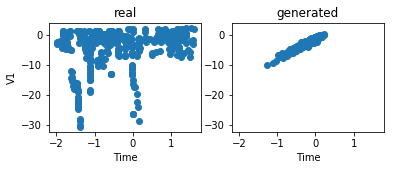

394 394
epoch: 750, Accuracy: 0.9873096446700508
[750/5001]	Loss_D: -0.0245	Loss_G: -0.0958	


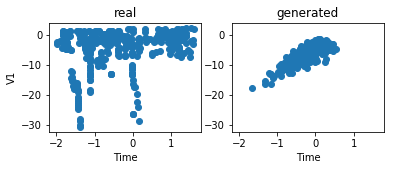

394 394
epoch: 760, Accuracy: 0.9771573604060914
[760/5001]	Loss_D: -0.4685	Loss_G: 0.6377	


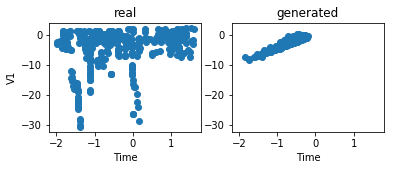

394 394
epoch: 770, Accuracy: 0.9949238578680203
[770/5001]	Loss_D: -0.3482	Loss_G: -0.3714	


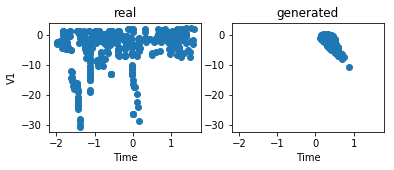

394 394
epoch: 780, Accuracy: 0.9822335025380711
[780/5001]	Loss_D: -0.0443	Loss_G: -0.2884	


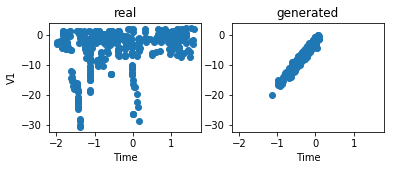

394 394
epoch: 790, Accuracy: 0.9847715736040609
[790/5001]	Loss_D: -0.0108	Loss_G: -0.0213	


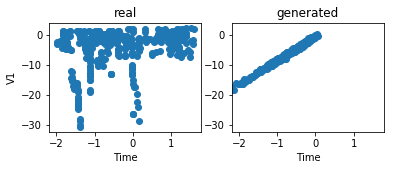

394 394
epoch: 800, Accuracy: 0.9796954314720813
[800/5001]	Loss_D: -0.0124	Loss_G: -0.0139	


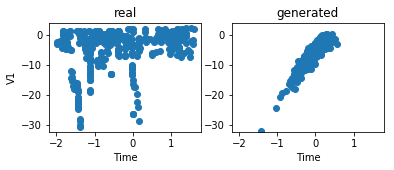

394 394
epoch: 810, Accuracy: 0.9593908629441624
[810/5001]	Loss_D: -0.7101	Loss_G: 1.2931	


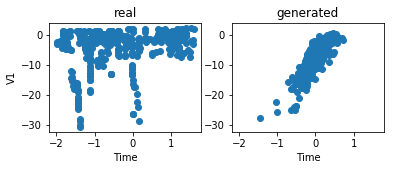

394 394
epoch: 820, Accuracy: 0.9847715736040609
[820/5001]	Loss_D: -0.1839	Loss_G: 0.1384	


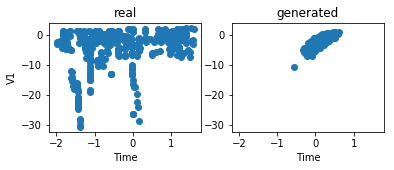

394 394
epoch: 830, Accuracy: 0.9847715736040609
[830/5001]	Loss_D: -0.2465	Loss_G: 0.2372	


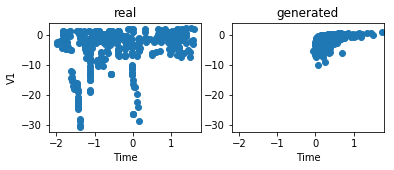

394 394
epoch: 840, Accuracy: 0.949238578680203
[840/5001]	Loss_D: -0.1936	Loss_G: 0.1749	


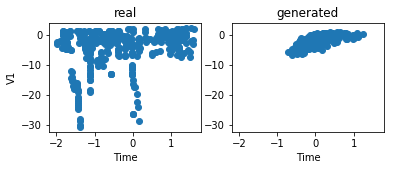

394 394
epoch: 850, Accuracy: 0.9847715736040609
[850/5001]	Loss_D: -0.2354	Loss_G: 0.1627	


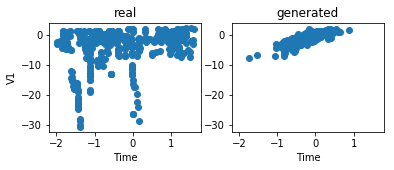

394 394
epoch: 860, Accuracy: 0.9390862944162437
[860/5001]	Loss_D: -0.4840	Loss_G: -0.7634	


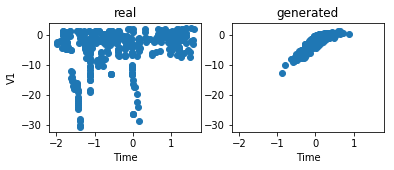

394 394
epoch: 870, Accuracy: 0.9644670050761421
[870/5001]	Loss_D: 0.0017	Loss_G: -0.0147	


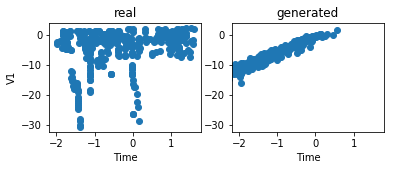

394 394
epoch: 880, Accuracy: 0.9746192893401016
[880/5001]	Loss_D: -0.0004	Loss_G: -0.0110	


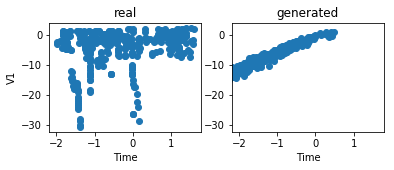

394 394
epoch: 890, Accuracy: 0.9923857868020305
[890/5001]	Loss_D: -0.3427	Loss_G: -0.1936	


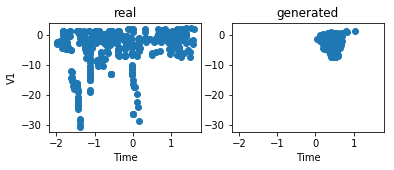

394 394
epoch: 900, Accuracy: 0.9923857868020305
[900/5001]	Loss_D: 0.0932	Loss_G: -1.2993	


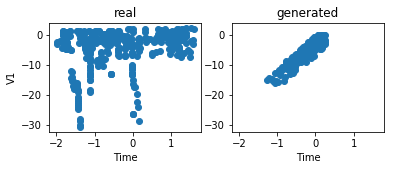

394 394
epoch: 910, Accuracy: 0.9923857868020305
[910/5001]	Loss_D: 0.0022	Loss_G: -0.0183	


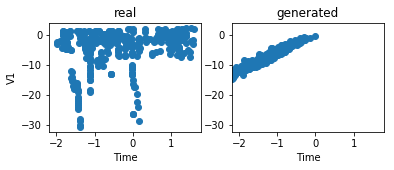

394 394
epoch: 920, Accuracy: 0.9949238578680203
[920/5001]	Loss_D: -0.1088	Loss_G: 1.3098	


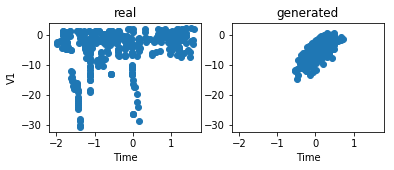

394 394
epoch: 930, Accuracy: 0.9847715736040609
[930/5001]	Loss_D: -0.4754	Loss_G: -0.6379	


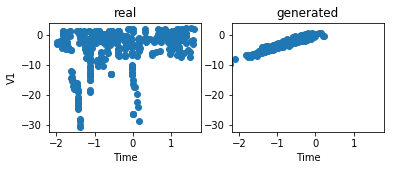

394 394
epoch: 940, Accuracy: 0.9898477157360406
[940/5001]	Loss_D: -0.3484	Loss_G: 0.9098	


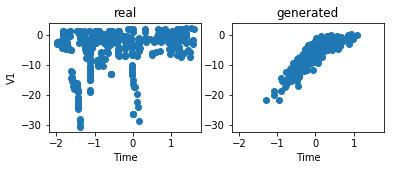

394 394
epoch: 950, Accuracy: 0.9847715736040609
[950/5001]	Loss_D: -0.0282	Loss_G: -0.0191	


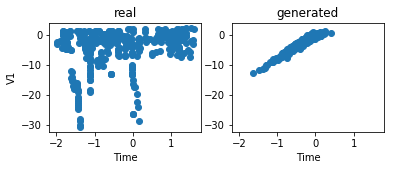

394 394
epoch: 960, Accuracy: 0.9923857868020305
[960/5001]	Loss_D: -0.0614	Loss_G: -0.0617	


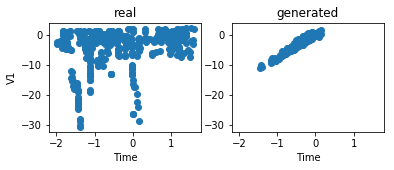

394 394
epoch: 970, Accuracy: 0.9695431472081218
[970/5001]	Loss_D: -0.0602	Loss_G: -0.1790	


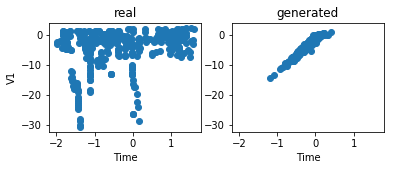

394 394
epoch: 980, Accuracy: 0.9974619289340102
[980/5001]	Loss_D: -0.0136	Loss_G: -0.2306	


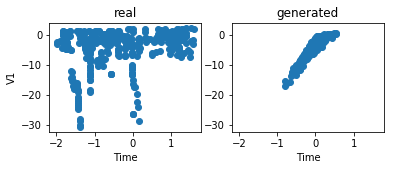

394 394
epoch: 990, Accuracy: 0.9822335025380711
[990/5001]	Loss_D: -0.0144	Loss_G: -0.0147	


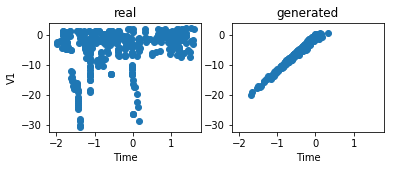

394 394
epoch: 1000, Accuracy: 0.9949238578680203
[1000/5001]	Loss_D: -0.0222	Loss_G: 1.0594	


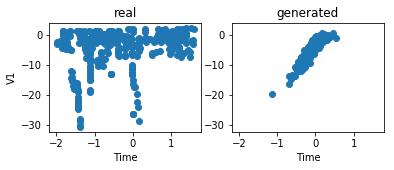

394 394
epoch: 1010, Accuracy: 0.9644670050761421
[1010/5001]	Loss_D: -0.0484	Loss_G: 0.0635	


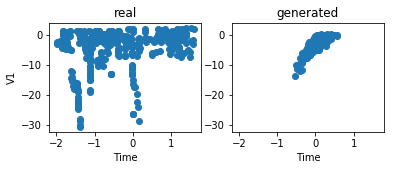

394 394
epoch: 1020, Accuracy: 0.9695431472081218
[1020/5001]	Loss_D: -0.0863	Loss_G: 0.1207	


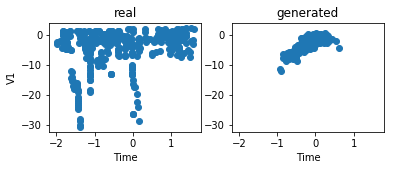

394 394
epoch: 1030, Accuracy: 0.9720812182741116
[1030/5001]	Loss_D: -0.0997	Loss_G: 0.1859	


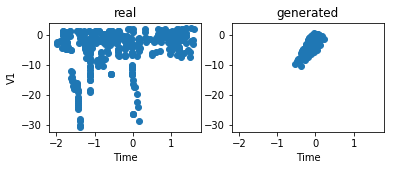

394 394
epoch: 1040, Accuracy: 0.9416243654822335
[1040/5001]	Loss_D: -0.1519	Loss_G: -0.2122	


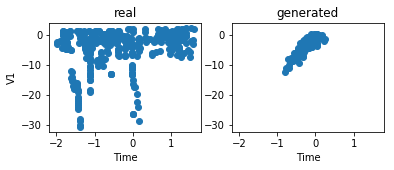

394 394
epoch: 1050, Accuracy: 0.9873096446700508
[1050/5001]	Loss_D: 0.0026	Loss_G: -0.0844	


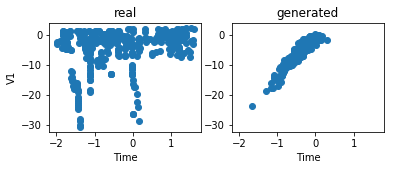

394 394
epoch: 1060, Accuracy: 0.9746192893401016
[1060/5001]	Loss_D: -0.0197	Loss_G: -0.0603	


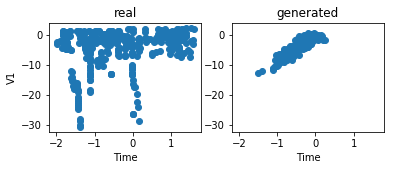

394 394
epoch: 1070, Accuracy: 0.9796954314720813
[1070/5001]	Loss_D: 0.0072	Loss_G: -0.0396	


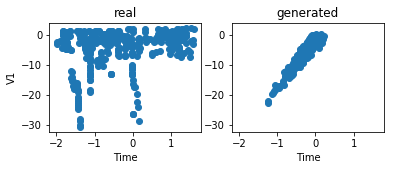

394 394
epoch: 1080, Accuracy: 0.9771573604060914
[1080/5001]	Loss_D: 0.0002	Loss_G: -0.0108	


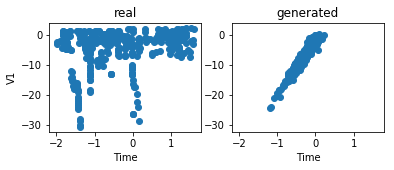

394 394
epoch: 1090, Accuracy: 0.9670050761421319
[1090/5001]	Loss_D: -0.0007	Loss_G: -0.0076	


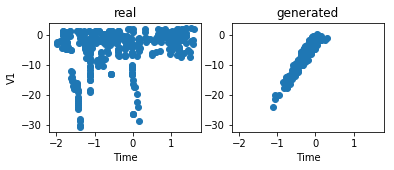

394 394
epoch: 1100, Accuracy: 0.9720812182741116
[1100/5001]	Loss_D: -0.0210	Loss_G: 1.0359	


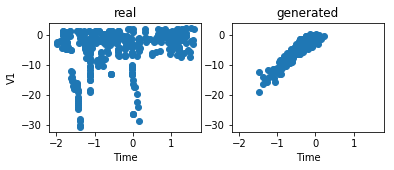

394 394
epoch: 1110, Accuracy: 0.9873096446700508
[1110/5001]	Loss_D: -0.0077	Loss_G: -0.0078	


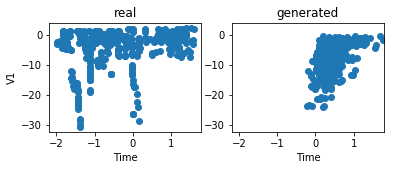

394 394
epoch: 1120, Accuracy: 0.9416243654822335
[1120/5001]	Loss_D: -0.2330	Loss_G: 0.6767	


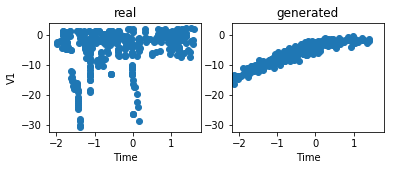

394 394
epoch: 1130, Accuracy: 0.9365482233502538
[1130/5001]	Loss_D: -0.5514	Loss_G: -4.2449	


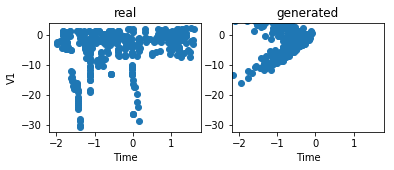

394 394
epoch: 1140, Accuracy: 0.934010152284264
[1140/5001]	Loss_D: -0.5018	Loss_G: 0.1341	


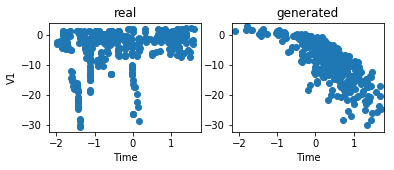

394 394
epoch: 1150, Accuracy: 0.8807106598984772
[1150/5001]	Loss_D: -0.3521	Loss_G: -0.9767	


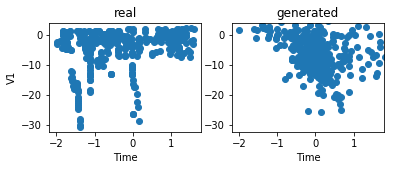

394 394
epoch: 1160, Accuracy: 0.9619289340101523
[1160/5001]	Loss_D: -0.0435	Loss_G: 0.1498	


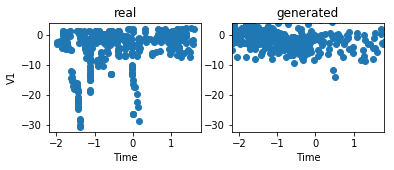

394 394
epoch: 1170, Accuracy: 0.9746192893401016
[1170/5001]	Loss_D: -0.7482	Loss_G: 0.0093	


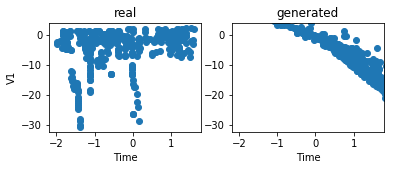

394 394
epoch: 1180, Accuracy: 0.9822335025380711
[1180/5001]	Loss_D: -0.7498	Loss_G: -0.0211	


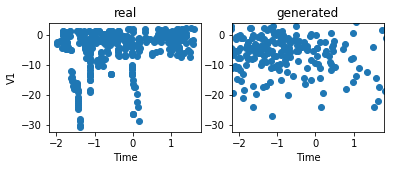

394 394
epoch: 1190, Accuracy: 0.9847715736040609
[1190/5001]	Loss_D: -0.1388	Loss_G: 0.2657	


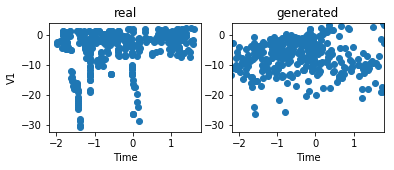

394 394
epoch: 1200, Accuracy: 0.9593908629441624
[1200/5001]	Loss_D: -0.4662	Loss_G: 0.0134	


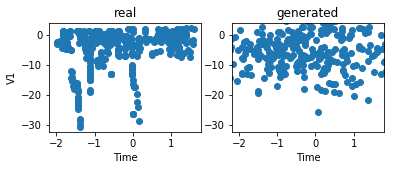

394 394
epoch: 1210, Accuracy: 0.9898477157360406
[1210/5001]	Loss_D: -0.4943	Loss_G: -0.2447	


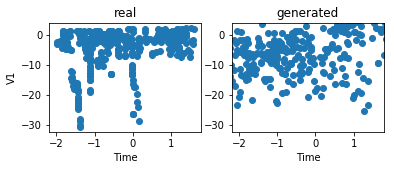

394 394
epoch: 1220, Accuracy: 0.9746192893401016
[1220/5001]	Loss_D: -0.2817	Loss_G: 0.1182	


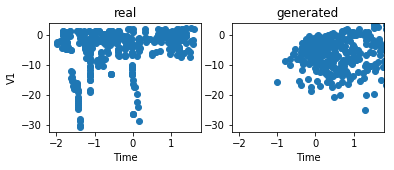

394 394
epoch: 1230, Accuracy: 0.9873096446700508
[1230/5001]	Loss_D: -0.0841	Loss_G: 0.0935	


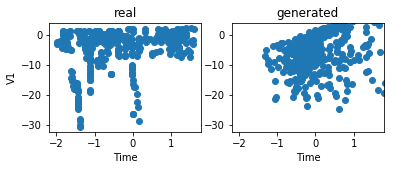

394 394
epoch: 1240, Accuracy: 0.9873096446700508
[1240/5001]	Loss_D: -1.0866	Loss_G: 0.0077	


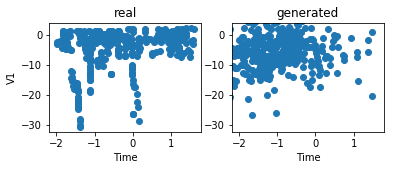

394 394
epoch: 1250, Accuracy: 0.9670050761421319
[1250/5001]	Loss_D: -0.3926	Loss_G: 0.0135	


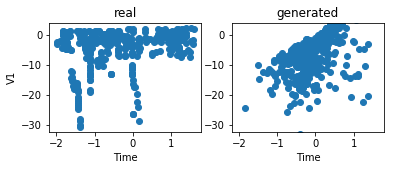

394 394
epoch: 1260, Accuracy: 0.9822335025380711
[1260/5001]	Loss_D: -0.4118	Loss_G: 0.0111	


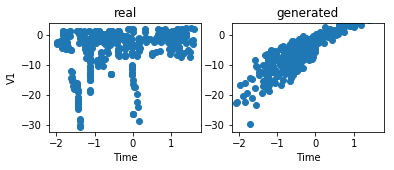

394 394
epoch: 1270, Accuracy: 0.9670050761421319
[1270/5001]	Loss_D: -0.4219	Loss_G: -0.1291	


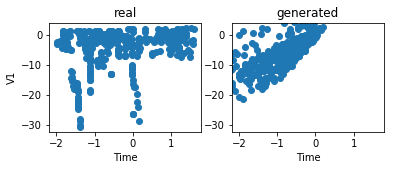

394 394
epoch: 1280, Accuracy: 0.9593908629441624
[1280/5001]	Loss_D: -0.2606	Loss_G: 0.0186	


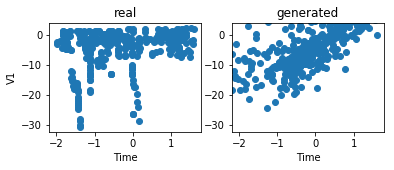

394 394
epoch: 1290, Accuracy: 0.9898477157360406
[1290/5001]	Loss_D: -0.4441	Loss_G: -0.0813	


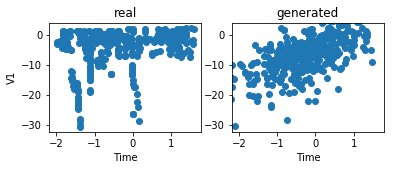

394 394
epoch: 1300, Accuracy: 0.9720812182741116
[1300/5001]	Loss_D: -0.3011	Loss_G: -0.0256	


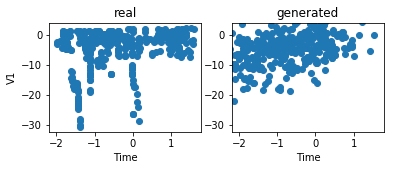

394 394
epoch: 1310, Accuracy: 0.9822335025380711
[1310/5001]	Loss_D: -0.5116	Loss_G: -0.0282	


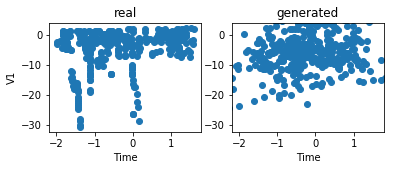

394 394
epoch: 1320, Accuracy: 0.9644670050761421
[1320/5001]	Loss_D: -0.2195	Loss_G: -0.0023	


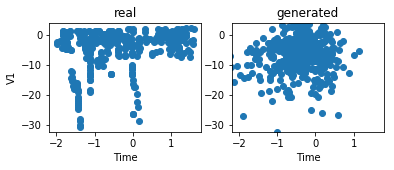

394 394
epoch: 1330, Accuracy: 0.9619289340101523
[1330/5001]	Loss_D: -0.3611	Loss_G: -0.0497	


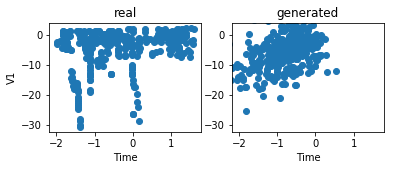

394 394
epoch: 1340, Accuracy: 0.9467005076142132
[1340/5001]	Loss_D: -0.2172	Loss_G: -0.0008	


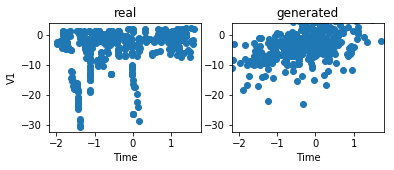

394 394
epoch: 1350, Accuracy: 0.9771573604060914
[1350/5001]	Loss_D: -0.1912	Loss_G: -0.0220	


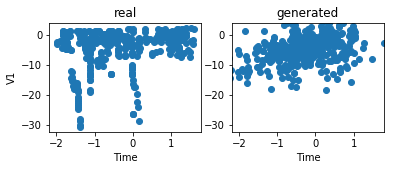

394 394
epoch: 1360, Accuracy: 0.9695431472081218
[1360/5001]	Loss_D: -0.6032	Loss_G: -0.1245	


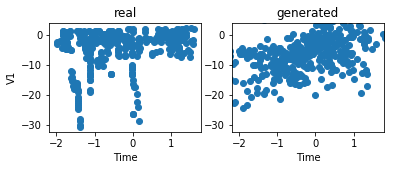

394 394
epoch: 1370, Accuracy: 0.9847715736040609
[1370/5001]	Loss_D: -0.2847	Loss_G: -0.0020	


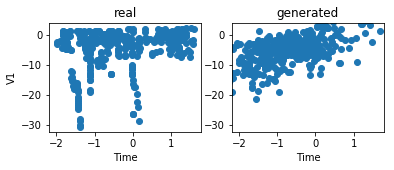

394 394
epoch: 1380, Accuracy: 0.9593908629441624
[1380/5001]	Loss_D: -0.3765	Loss_G: -0.0430	


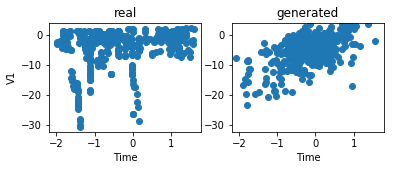

394 394
epoch: 1390, Accuracy: 0.9771573604060914
[1390/5001]	Loss_D: -0.1897	Loss_G: -0.0312	


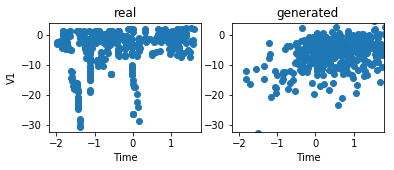

394 394
epoch: 1400, Accuracy: 0.9670050761421319
[1400/5001]	Loss_D: -0.5499	Loss_G: -0.1048	


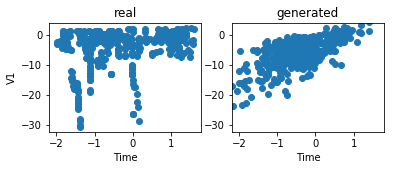

394 394
epoch: 1410, Accuracy: 0.9543147208121827
[1410/5001]	Loss_D: -0.1960	Loss_G: -0.0539	


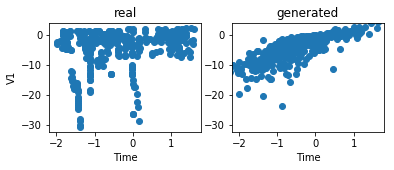

394 394
epoch: 1420, Accuracy: 0.9746192893401016
[1420/5001]	Loss_D: -0.3330	Loss_G: -0.0363	


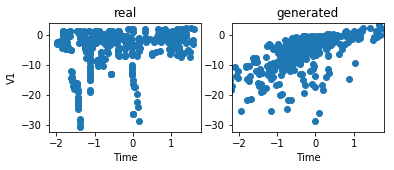

394 394
epoch: 1430, Accuracy: 0.9568527918781726
[1430/5001]	Loss_D: -0.0978	Loss_G: 0.0147	


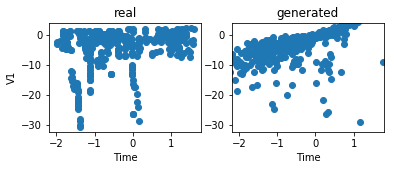

394 394
epoch: 1440, Accuracy: 0.9568527918781726
[1440/5001]	Loss_D: -0.6481	Loss_G: -0.1769	


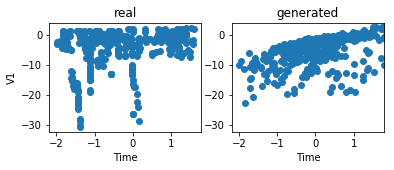

394 394
epoch: 1450, Accuracy: 0.9390862944162437
[1450/5001]	Loss_D: -0.4907	Loss_G: -0.0517	


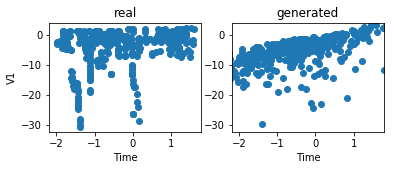

394 394
epoch: 1460, Accuracy: 0.9644670050761421
[1460/5001]	Loss_D: -0.0960	Loss_G: 0.0536	


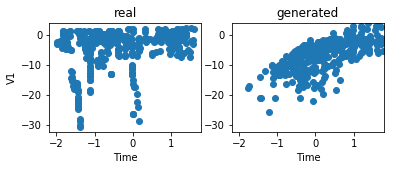

394 394
epoch: 1470, Accuracy: 0.9593908629441624
[1470/5001]	Loss_D: -0.4358	Loss_G: -0.3389	


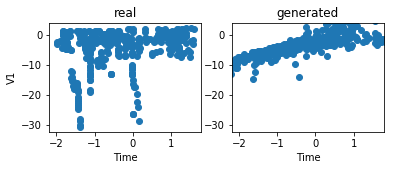

394 394
epoch: 1480, Accuracy: 0.9644670050761421
[1480/5001]	Loss_D: -0.4026	Loss_G: -0.3636	


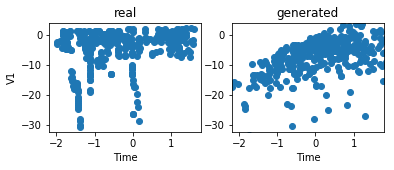

394 394
epoch: 1490, Accuracy: 0.934010152284264
[1490/5001]	Loss_D: -0.2029	Loss_G: 0.1204	


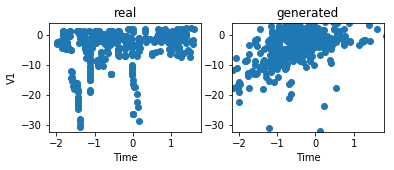

394 394
epoch: 1500, Accuracy: 0.9695431472081218
[1500/5001]	Loss_D: -0.4320	Loss_G: -0.2553	


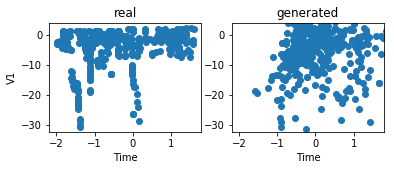

394 394
epoch: 1510, Accuracy: 0.9771573604060914
[1510/5001]	Loss_D: -0.1015	Loss_G: 0.1053	


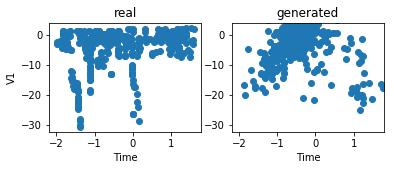

394 394
epoch: 1520, Accuracy: 0.9568527918781726
[1520/5001]	Loss_D: -0.3619	Loss_G: -0.4434	


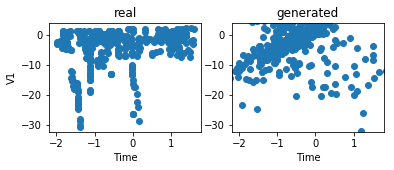

394 394
epoch: 1530, Accuracy: 0.9441624365482234
[1530/5001]	Loss_D: -0.1361	Loss_G: 0.0255	


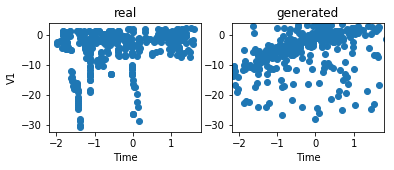

394 394
epoch: 1540, Accuracy: 0.9314720812182741
[1540/5001]	Loss_D: -0.5170	Loss_G: -0.2171	


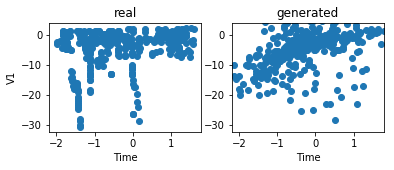

394 394
epoch: 1550, Accuracy: 0.9873096446700508
[1550/5001]	Loss_D: -0.2697	Loss_G: 0.0111	


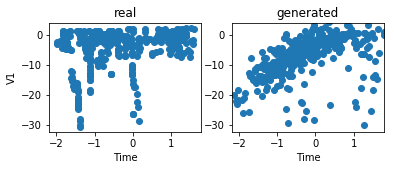

394 394
epoch: 1560, Accuracy: 0.9416243654822335
[1560/5001]	Loss_D: -0.5158	Loss_G: -0.0582	


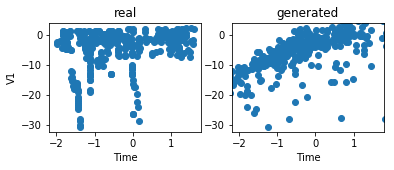

394 394
epoch: 1570, Accuracy: 0.9543147208121827
[1570/5001]	Loss_D: -0.2203	Loss_G: -0.0691	


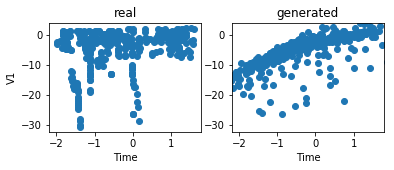

394 394
epoch: 1580, Accuracy: 0.9771573604060914
[1580/5001]	Loss_D: -0.1357	Loss_G: 0.0257	


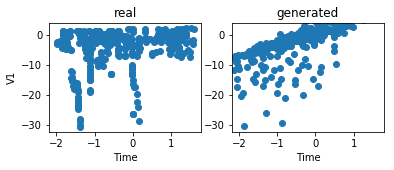

394 394
epoch: 1590, Accuracy: 0.9416243654822335
[1590/5001]	Loss_D: -0.8000	Loss_G: -0.4143	


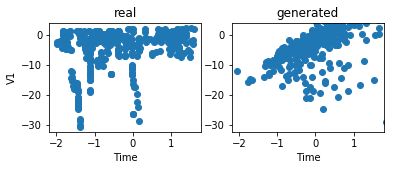

394 394
epoch: 1600, Accuracy: 0.9593908629441624
[1600/5001]	Loss_D: -0.1528	Loss_G: 0.0285	


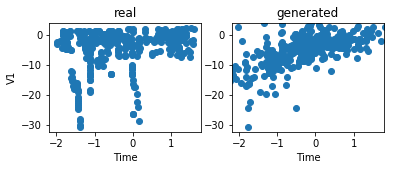

394 394
epoch: 1610, Accuracy: 0.9746192893401016
[1610/5001]	Loss_D: -0.1084	Loss_G: -0.0460	


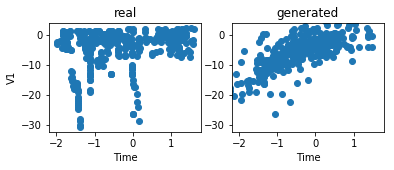

394 394
epoch: 1620, Accuracy: 0.9670050761421319
[1620/5001]	Loss_D: -0.2438	Loss_G: 0.0317	


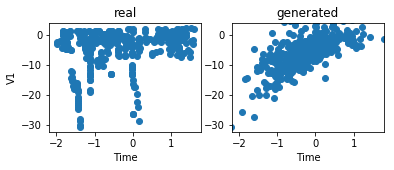

394 394
epoch: 1630, Accuracy: 0.9517766497461929
[1630/5001]	Loss_D: -0.5382	Loss_G: -0.1243	


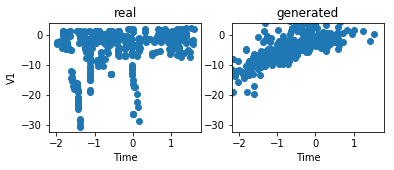

394 394
epoch: 1640, Accuracy: 0.9670050761421319
[1640/5001]	Loss_D: -0.4055	Loss_G: -0.0421	


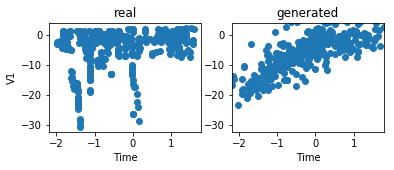

394 394
epoch: 1650, Accuracy: 0.9314720812182741
[1650/5001]	Loss_D: -0.1204	Loss_G: -0.0025	


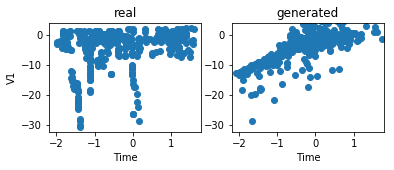

394 394
epoch: 1660, Accuracy: 0.9416243654822335
[1660/5001]	Loss_D: -0.2176	Loss_G: -0.0870	


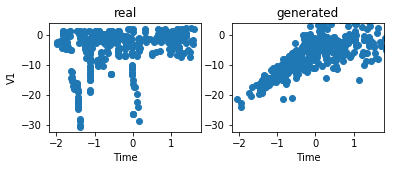

394 394
epoch: 1670, Accuracy: 0.9441624365482234
[1670/5001]	Loss_D: -0.5755	Loss_G: -0.7290	


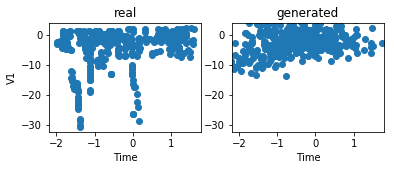

394 394
epoch: 1680, Accuracy: 0.9517766497461929
[1680/5001]	Loss_D: -0.0203	Loss_G: 0.0796	


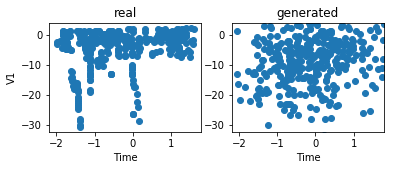

394 394
epoch: 1690, Accuracy: 0.9593908629441624
[1690/5001]	Loss_D: -0.1149	Loss_G: 0.1056	


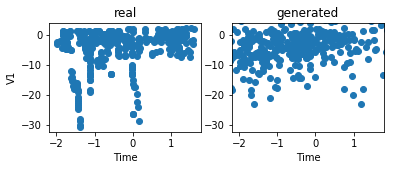

394 394
epoch: 1700, Accuracy: 0.9390862944162437
[1700/5001]	Loss_D: -0.2349	Loss_G: -0.1512	


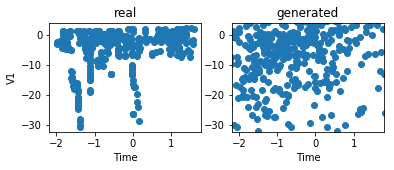

394 394
epoch: 1710, Accuracy: 0.9619289340101523
[1710/5001]	Loss_D: -0.2458	Loss_G: 0.0285	


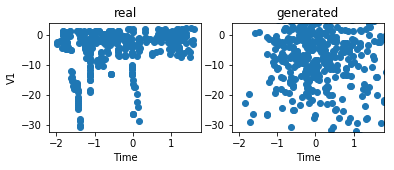

394 394
epoch: 1720, Accuracy: 0.9467005076142132
[1720/5001]	Loss_D: -0.3124	Loss_G: -0.0063	


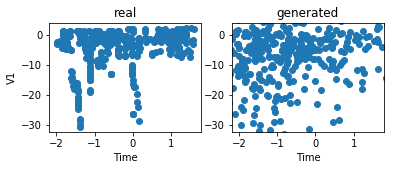

394 394
epoch: 1730, Accuracy: 0.9517766497461929
[1730/5001]	Loss_D: -0.2361	Loss_G: 0.0112	


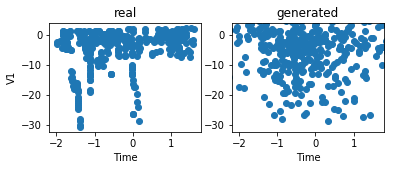

394 394
epoch: 1740, Accuracy: 0.9619289340101523
[1740/5001]	Loss_D: -0.2120	Loss_G: -0.0044	


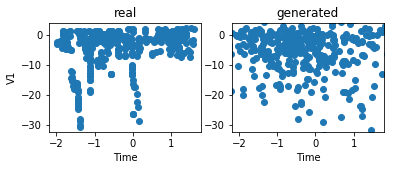

394 394
epoch: 1750, Accuracy: 0.9746192893401016
[1750/5001]	Loss_D: -0.1272	Loss_G: 0.0132	


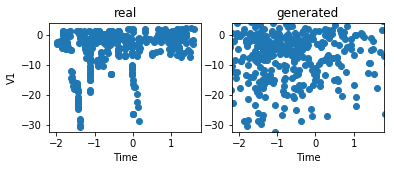

394 394
epoch: 1760, Accuracy: 0.9263959390862944
[1760/5001]	Loss_D: -0.3686	Loss_G: 0.0033	


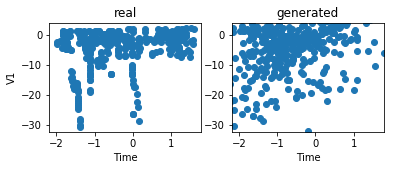

394 394
epoch: 1770, Accuracy: 0.949238578680203
[1770/5001]	Loss_D: -0.1171	Loss_G: -0.0155	


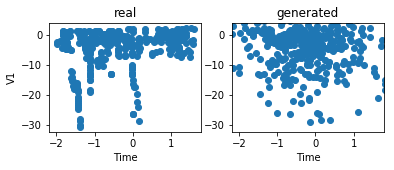

394 394
epoch: 1780, Accuracy: 0.9568527918781726
[1780/5001]	Loss_D: -0.4237	Loss_G: -0.0488	


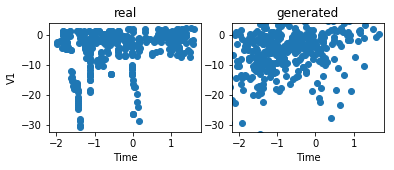

394 394
epoch: 1790, Accuracy: 0.9467005076142132
[1790/5001]	Loss_D: -0.2741	Loss_G: -0.1365	


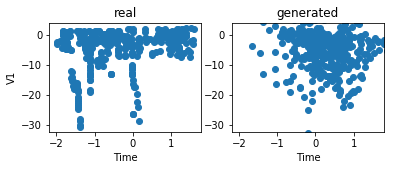

394 394
epoch: 1800, Accuracy: 0.949238578680203
[1800/5001]	Loss_D: -0.0974	Loss_G: 0.0433	


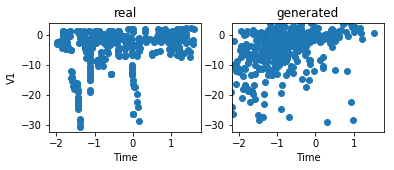

394 394
epoch: 1810, Accuracy: 0.9390862944162437
[1810/5001]	Loss_D: -0.2670	Loss_G: -0.0538	


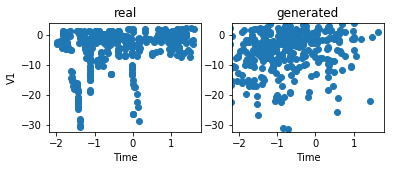

394 394
epoch: 1820, Accuracy: 0.949238578680203
[1820/5001]	Loss_D: -0.2808	Loss_G: -0.1105	


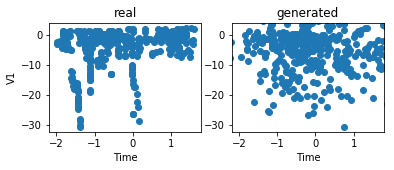

394 394
epoch: 1830, Accuracy: 0.9644670050761421
[1830/5001]	Loss_D: -0.2233	Loss_G: -0.0347	


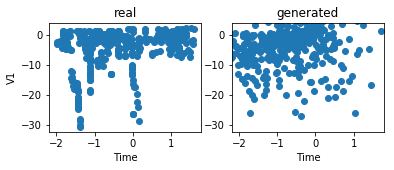

394 394
epoch: 1840, Accuracy: 0.9644670050761421
[1840/5001]	Loss_D: -0.3836	Loss_G: -0.0652	


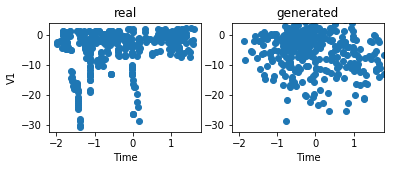

394 394
epoch: 1850, Accuracy: 0.9644670050761421
[1850/5001]	Loss_D: -0.0574	Loss_G: -0.0203	


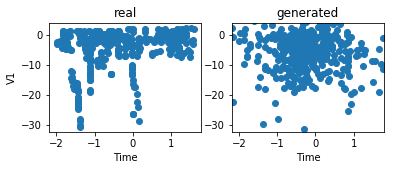

394 394
epoch: 1860, Accuracy: 0.9111675126903553
[1860/5001]	Loss_D: -0.3033	Loss_G: -0.0476	


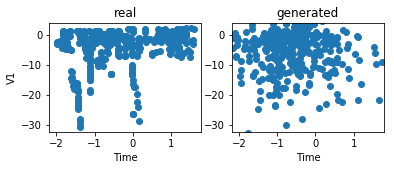

394 394
epoch: 1870, Accuracy: 0.9517766497461929
[1870/5001]	Loss_D: -0.0712	Loss_G: 0.0365	


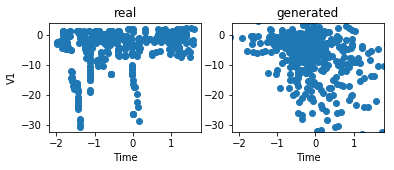

394 394
epoch: 1880, Accuracy: 0.9644670050761421
[1880/5001]	Loss_D: -0.0472	Loss_G: 0.0366	


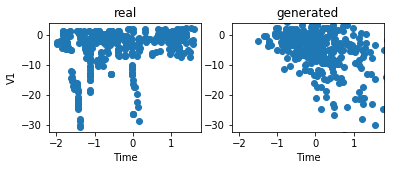

394 394
epoch: 1890, Accuracy: 0.9111675126903553
[1890/5001]	Loss_D: -0.1063	Loss_G: -0.0403	


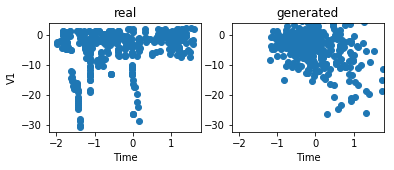

394 394
epoch: 1900, Accuracy: 0.9543147208121827
[1900/5001]	Loss_D: -0.1002	Loss_G: -0.0450	


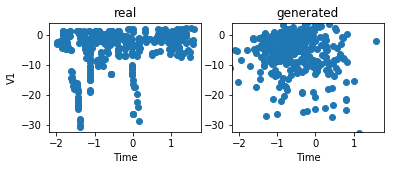

394 394
epoch: 1910, Accuracy: 0.9467005076142132
[1910/5001]	Loss_D: -0.0680	Loss_G: -0.0208	


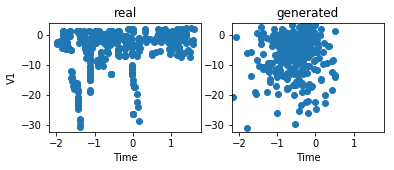

394 394
epoch: 1920, Accuracy: 0.9467005076142132
[1920/5001]	Loss_D: -0.1282	Loss_G: -0.0673	


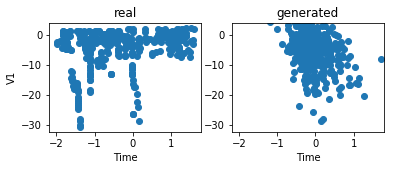

394 394
epoch: 1930, Accuracy: 0.9543147208121827
[1930/5001]	Loss_D: -0.1155	Loss_G: -0.0416	


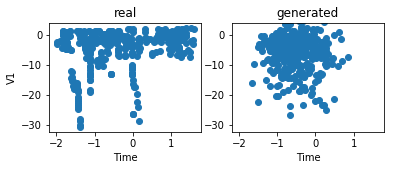

394 394
epoch: 1940, Accuracy: 0.9416243654822335
[1940/5001]	Loss_D: -0.0625	Loss_G: 0.0299	


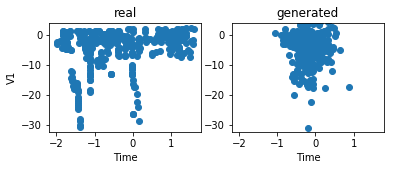

394 394
epoch: 1950, Accuracy: 0.949238578680203
[1950/5001]	Loss_D: -0.1162	Loss_G: -0.0214	


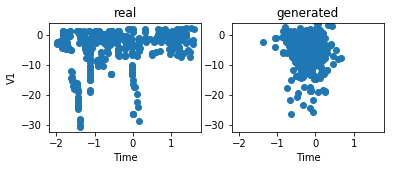

394 394
epoch: 1960, Accuracy: 0.9670050761421319
[1960/5001]	Loss_D: -0.2062	Loss_G: -0.0511	


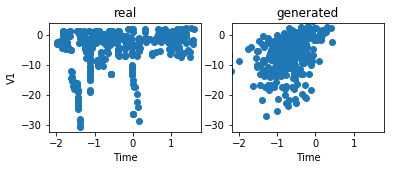

394 394
epoch: 1970, Accuracy: 0.934010152284264
[1970/5001]	Loss_D: -0.1646	Loss_G: -0.0324	


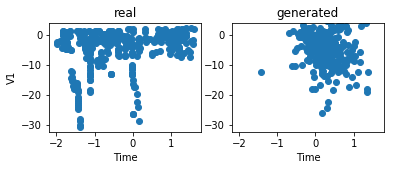

394 394
epoch: 1980, Accuracy: 0.9568527918781726
[1980/5001]	Loss_D: -0.2940	Loss_G: -0.2283	


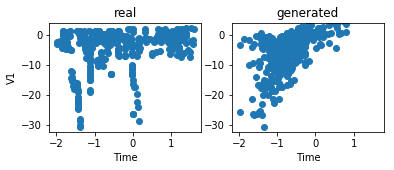

394 394
epoch: 1990, Accuracy: 0.9517766497461929
[1990/5001]	Loss_D: -0.0304	Loss_G: 0.0216	


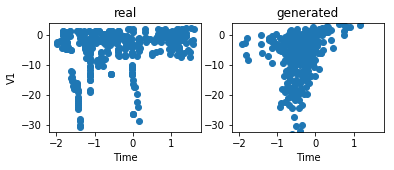

394 394
epoch: 2000, Accuracy: 0.9543147208121827
[2000/5001]	Loss_D: 0.0264	Loss_G: 0.1333	


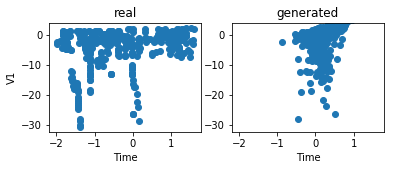

394 394
epoch: 2010, Accuracy: 0.9543147208121827
[2010/5001]	Loss_D: -0.2324	Loss_G: 0.0241	


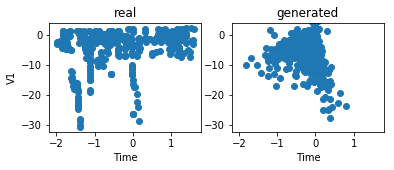

394 394
epoch: 2020, Accuracy: 0.9390862944162437
[2020/5001]	Loss_D: -0.0183	Loss_G: 0.0119	


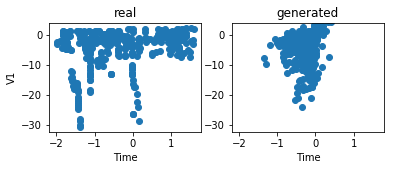

394 394
epoch: 2030, Accuracy: 0.9619289340101523
[2030/5001]	Loss_D: -0.0941	Loss_G: 1.3585	


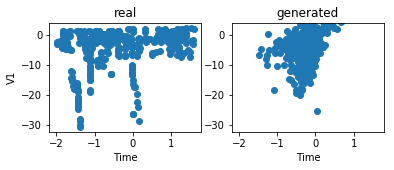

394 394
epoch: 2040, Accuracy: 0.9137055837563451
[2040/5001]	Loss_D: 0.0014	Loss_G: -0.0054	


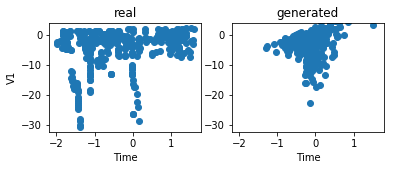

394 394
epoch: 2050, Accuracy: 0.9543147208121827
[2050/5001]	Loss_D: -0.9632	Loss_G: -2.6411	


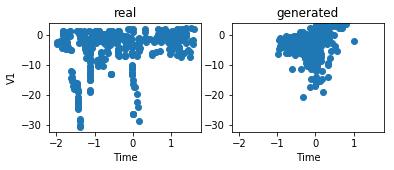

394 394
epoch: 2060, Accuracy: 0.949238578680203
[2060/5001]	Loss_D: -0.0000	Loss_G: -0.0100	


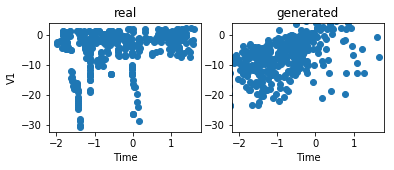

394 394
epoch: 2070, Accuracy: 0.9670050761421319
[2070/5001]	Loss_D: -0.0004	Loss_G: -0.0096	


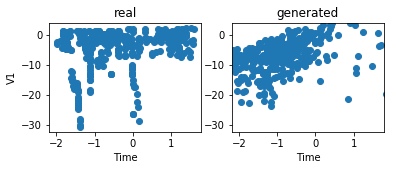

394 394
epoch: 2080, Accuracy: 0.9593908629441624
[2080/5001]	Loss_D: 0.2316	Loss_G: 0.9256	


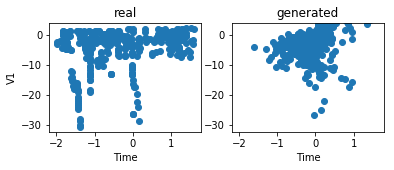

394 394
epoch: 2090, Accuracy: 0.9238578680203046
[2090/5001]	Loss_D: -0.4418	Loss_G: -1.9302	


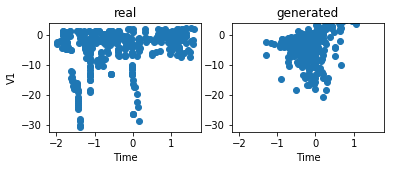

394 394
epoch: 2100, Accuracy: 0.9289340101522843
[2100/5001]	Loss_D: 0.0006	Loss_G: -0.0153	


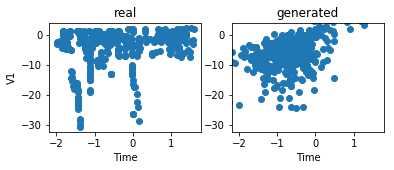

394 394
epoch: 2110, Accuracy: 0.9543147208121827
[2110/5001]	Loss_D: -0.0024	Loss_G: -0.0095	


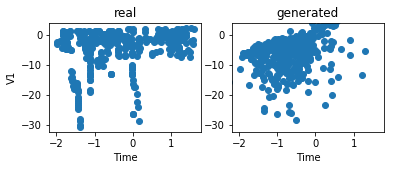

394 394
epoch: 2120, Accuracy: 0.9593908629441624
[2120/5001]	Loss_D: -0.6609	Loss_G: 2.0541	


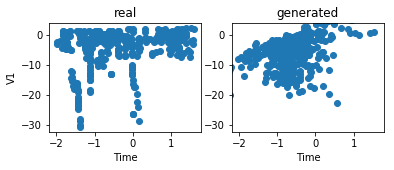

394 394
epoch: 2130, Accuracy: 0.9467005076142132
[2130/5001]	Loss_D: -0.2490	Loss_G: -0.7140	


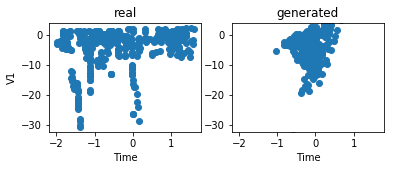

394 394
epoch: 2140, Accuracy: 0.9441624365482234
[2140/5001]	Loss_D: -0.0134	Loss_G: 0.0425	


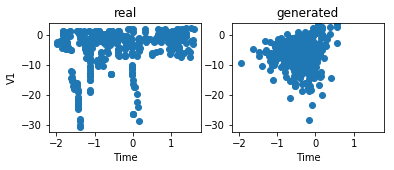

394 394
epoch: 2150, Accuracy: 0.9467005076142132
[2150/5001]	Loss_D: -0.0076	Loss_G: -0.0052	


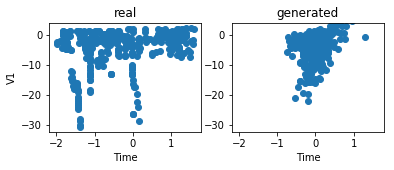

394 394
epoch: 2160, Accuracy: 0.9593908629441624
[2160/5001]	Loss_D: -0.0255	Loss_G: 0.0116	


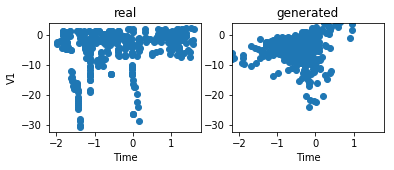

394 394
epoch: 2170, Accuracy: 0.9695431472081218
[2170/5001]	Loss_D: -0.0586	Loss_G: 0.1545	


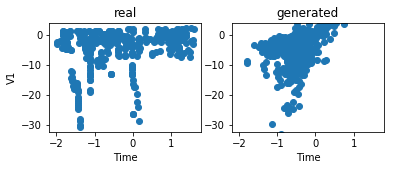

394 394
epoch: 2180, Accuracy: 0.9644670050761421
[2180/5001]	Loss_D: -0.0563	Loss_G: 0.0777	


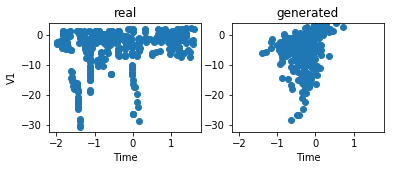

394 394
epoch: 2190, Accuracy: 0.9441624365482234
[2190/5001]	Loss_D: -0.0424	Loss_G: -0.0183	


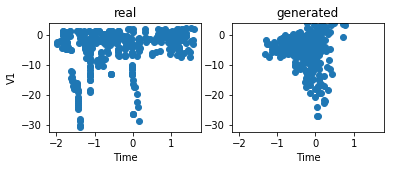

394 394
epoch: 2200, Accuracy: 0.9517766497461929
[2200/5001]	Loss_D: -0.0326	Loss_G: -0.0428	


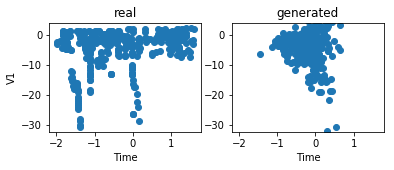

394 394
epoch: 2210, Accuracy: 0.949238578680203
[2210/5001]	Loss_D: -0.0497	Loss_G: 0.0091	


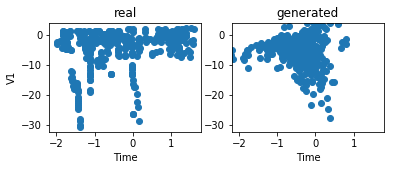

394 394
epoch: 2220, Accuracy: 0.9517766497461929
[2220/5001]	Loss_D: -0.0777	Loss_G: 0.0099	


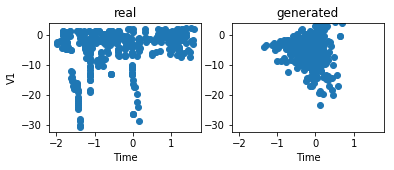

394 394
epoch: 2230, Accuracy: 0.9543147208121827
[2230/5001]	Loss_D: -0.0575	Loss_G: -0.0357	


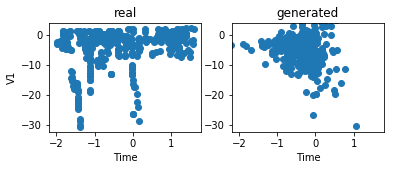

394 394
epoch: 2240, Accuracy: 0.9416243654822335
[2240/5001]	Loss_D: -0.0605	Loss_G: 0.0033	


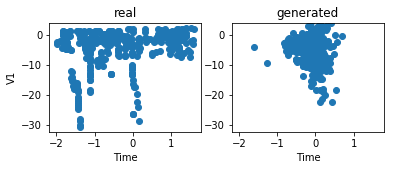

394 394
epoch: 2250, Accuracy: 0.9263959390862944
[2250/5001]	Loss_D: -0.0394	Loss_G: -0.0862	


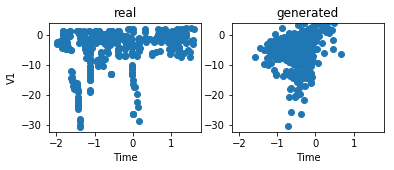

394 394
epoch: 2260, Accuracy: 0.9670050761421319
[2260/5001]	Loss_D: -0.0631	Loss_G: 0.0101	


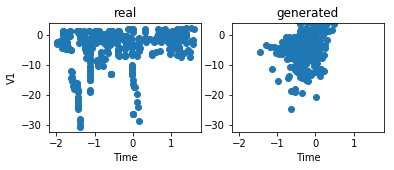

394 394
epoch: 2270, Accuracy: 0.9517766497461929
[2270/5001]	Loss_D: -0.0546	Loss_G: 0.0018	


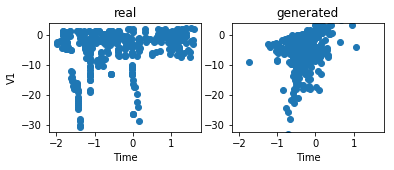

394 394
epoch: 2280, Accuracy: 0.949238578680203
[2280/5001]	Loss_D: -0.0716	Loss_G: 0.0046	


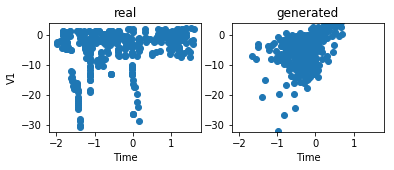

394 394
epoch: 2290, Accuracy: 0.934010152284264
[2290/5001]	Loss_D: -0.0662	Loss_G: -0.0806	


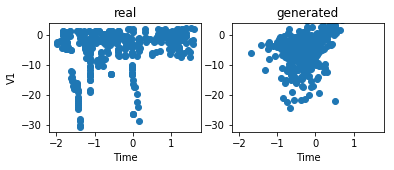

394 394
epoch: 2300, Accuracy: 0.9568527918781726
[2300/5001]	Loss_D: -0.0559	Loss_G: 0.0116	


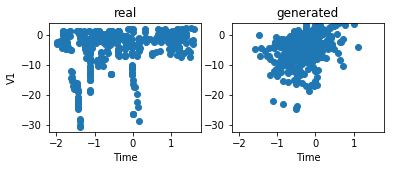

394 394
epoch: 2310, Accuracy: 0.9568527918781726
[2310/5001]	Loss_D: -0.0630	Loss_G: 0.0042	


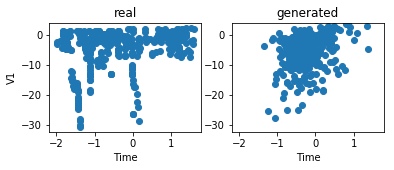

394 394
epoch: 2320, Accuracy: 0.934010152284264
[2320/5001]	Loss_D: -0.0495	Loss_G: 0.0012	


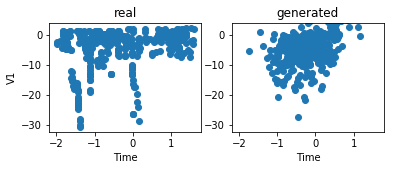

394 394
epoch: 2330, Accuracy: 0.9593908629441624
[2330/5001]	Loss_D: -0.0512	Loss_G: 0.0051	


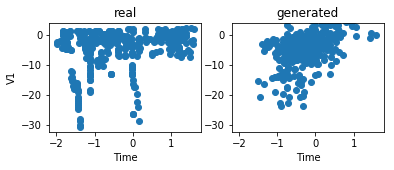

394 394
epoch: 2340, Accuracy: 0.9593908629441624
[2340/5001]	Loss_D: -0.0644	Loss_G: 0.0126	


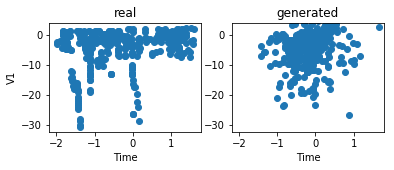

394 394
epoch: 2350, Accuracy: 0.9390862944162437
[2350/5001]	Loss_D: -0.0626	Loss_G: 0.0093	


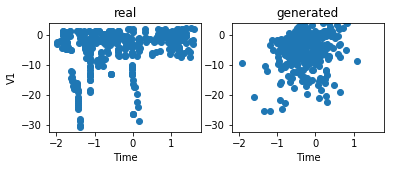

394 394
epoch: 2360, Accuracy: 0.9314720812182741
[2360/5001]	Loss_D: -0.0500	Loss_G: 0.0009	


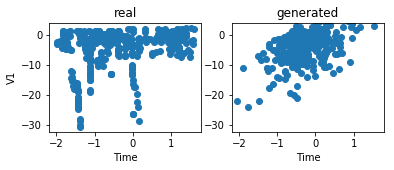

394 394
epoch: 2370, Accuracy: 0.9416243654822335
[2370/5001]	Loss_D: -0.0581	Loss_G: -0.0412	


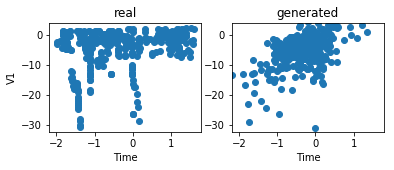

394 394
epoch: 2380, Accuracy: 0.9695431472081218
[2380/5001]	Loss_D: -0.0519	Loss_G: 0.0262	


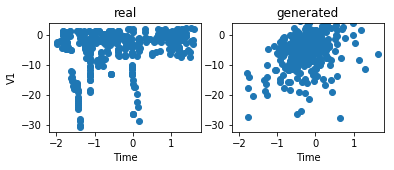

394 394
epoch: 2390, Accuracy: 0.9467005076142132
[2390/5001]	Loss_D: -0.0610	Loss_G: -0.0474	


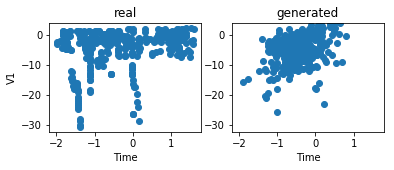

394 394
epoch: 2400, Accuracy: 0.9517766497461929
[2400/5001]	Loss_D: -0.0430	Loss_G: -0.0570	


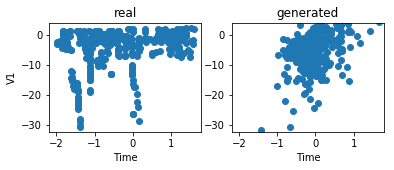

394 394
epoch: 2410, Accuracy: 0.9695431472081218
[2410/5001]	Loss_D: -0.0847	Loss_G: -0.0443	


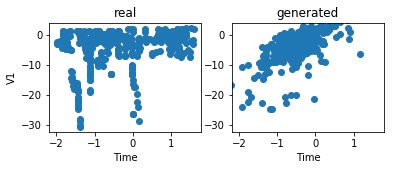

394 394
epoch: 2420, Accuracy: 0.9467005076142132
[2420/5001]	Loss_D: -0.0487	Loss_G: -0.4510	


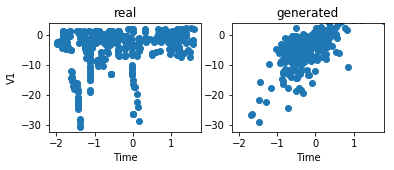

394 394
epoch: 2430, Accuracy: 0.9644670050761421
[2430/5001]	Loss_D: -0.0066	Loss_G: -0.0322	


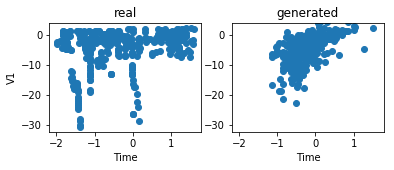

394 394
epoch: 2440, Accuracy: 0.9619289340101523
[2440/5001]	Loss_D: -0.0540	Loss_G: 0.5364	


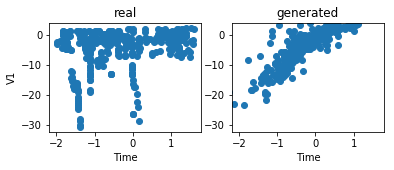

394 394
epoch: 2450, Accuracy: 0.9543147208121827
[2450/5001]	Loss_D: 0.0207	Loss_G: -0.3620	


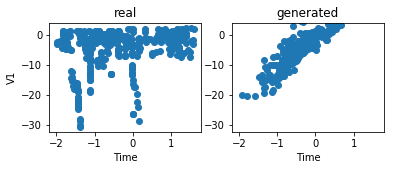

394 394
epoch: 2460, Accuracy: 0.9720812182741116
[2460/5001]	Loss_D: 0.0001	Loss_G: -0.0105	


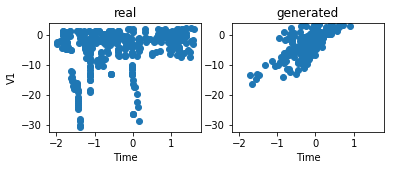

394 394
epoch: 2470, Accuracy: 0.9263959390862944
[2470/5001]	Loss_D: 0.0000	Loss_G: -0.0101	


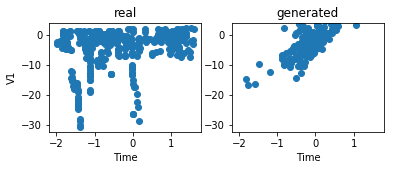

394 394
epoch: 2480, Accuracy: 0.9593908629441624
[2480/5001]	Loss_D: -0.0001	Loss_G: -0.0099	


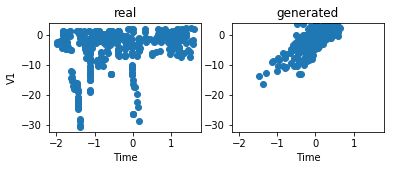

394 394
epoch: 2490, Accuracy: 0.9568527918781726
[2490/5001]	Loss_D: 0.0494	Loss_G: -0.2977	


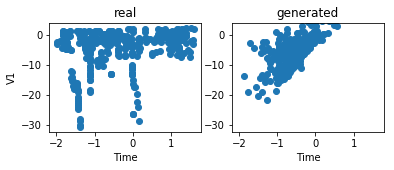

394 394
epoch: 2500, Accuracy: 0.9365482233502538
[2500/5001]	Loss_D: -0.7479	Loss_G: 9.2512	


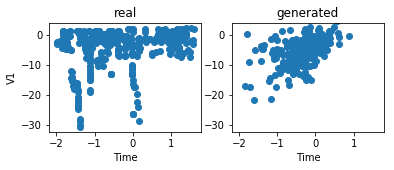

394 394
epoch: 2510, Accuracy: 0.9644670050761421
[2510/5001]	Loss_D: 0.0003	Loss_G: -0.0095	


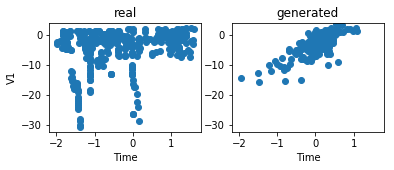

394 394
epoch: 2520, Accuracy: 0.9771573604060914
[2520/5001]	Loss_D: -0.0001	Loss_G: -0.0098	


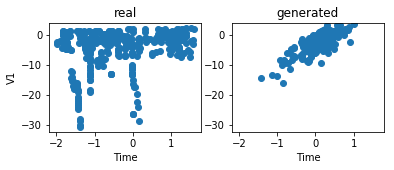

394 394
epoch: 2530, Accuracy: 0.9796954314720813
[2530/5001]	Loss_D: -0.0002	Loss_G: -0.0095	


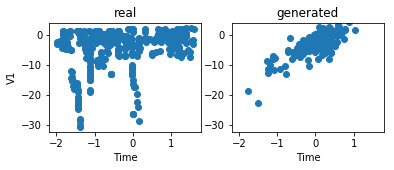

394 394
epoch: 2540, Accuracy: 0.9822335025380711
[2540/5001]	Loss_D: -0.0013	Loss_G: -0.0080	


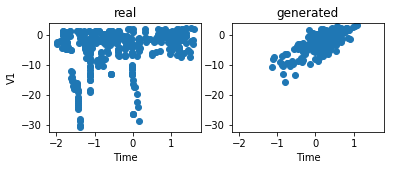

394 394
epoch: 2550, Accuracy: 0.9771573604060914
[2550/5001]	Loss_D: -0.1905	Loss_G: 0.3054	


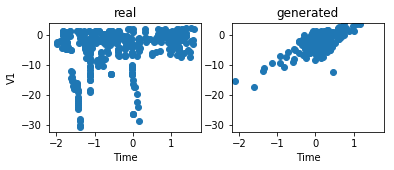

394 394
epoch: 2560, Accuracy: 0.9847715736040609
[2560/5001]	Loss_D: -0.0078	Loss_G: -0.0188	


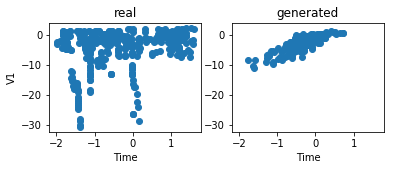

394 394
epoch: 2570, Accuracy: 0.9796954314720813
[2570/5001]	Loss_D: -0.0385	Loss_G: -0.0480	


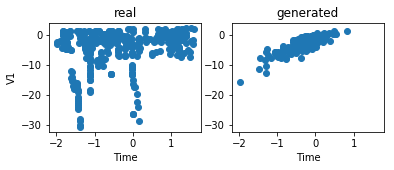

394 394
epoch: 2580, Accuracy: 0.9670050761421319
[2580/5001]	Loss_D: -0.0506	Loss_G: -0.0595	


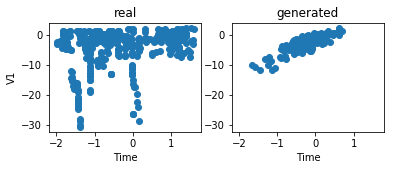

394 394
epoch: 2590, Accuracy: 0.9746192893401016
[2590/5001]	Loss_D: -0.0462	Loss_G: -0.0680	


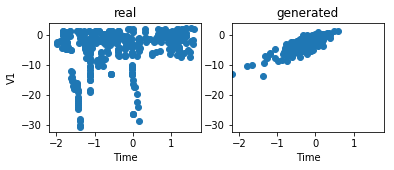

394 394
epoch: 2600, Accuracy: 0.9670050761421319
[2600/5001]	Loss_D: -0.0422	Loss_G: -0.0732	


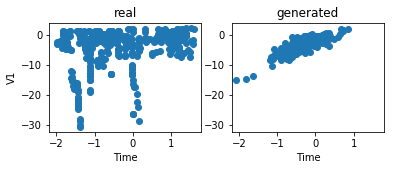

394 394
epoch: 2610, Accuracy: 0.9847715736040609
[2610/5001]	Loss_D: -0.0315	Loss_G: -0.0840	


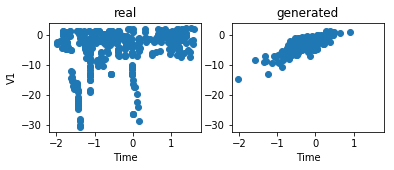

394 394
epoch: 2620, Accuracy: 0.9771573604060914
[2620/5001]	Loss_D: -0.0069	Loss_G: -0.1044	


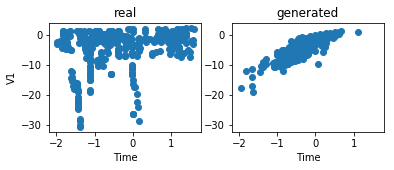

394 394
epoch: 2630, Accuracy: 0.9695431472081218
[2630/5001]	Loss_D: 0.0016	Loss_G: -0.0262	


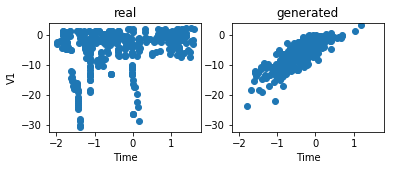

394 394
epoch: 2640, Accuracy: 0.9746192893401016
[2640/5001]	Loss_D: -0.0004	Loss_G: -0.0115	


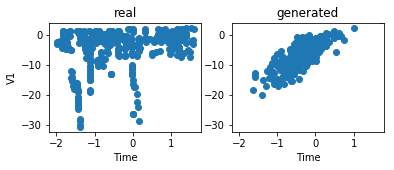

394 394
epoch: 2650, Accuracy: 0.9771573604060914
[2650/5001]	Loss_D: -0.1612	Loss_G: 0.2155	


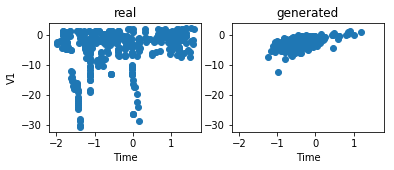

394 394
epoch: 2660, Accuracy: 0.9517766497461929
[2660/5001]	Loss_D: -0.1997	Loss_G: 0.3252	


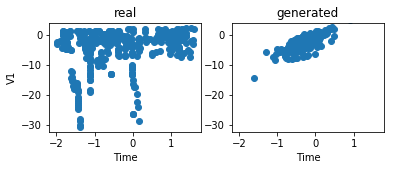

394 394
epoch: 2670, Accuracy: 0.9593908629441624
[2670/5001]	Loss_D: -0.1806	Loss_G: 0.2502	


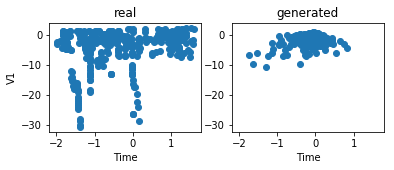

394 394
epoch: 2680, Accuracy: 0.9289340101522843
[2680/5001]	Loss_D: -0.0468	Loss_G: -0.0129	


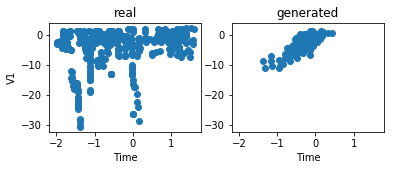

394 394
epoch: 2690, Accuracy: 0.9771573604060914
[2690/5001]	Loss_D: -0.1526	Loss_G: -0.1639	


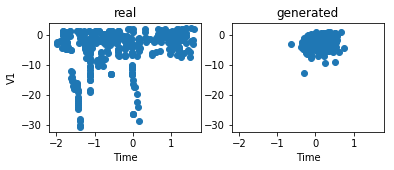

394 394
epoch: 2700, Accuracy: 0.9720812182741116
[2700/5001]	Loss_D: -0.0002	Loss_G: -0.2558	


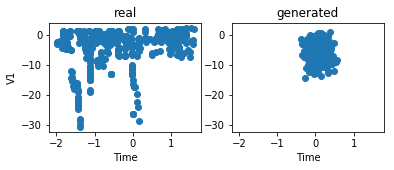

394 394
epoch: 2710, Accuracy: 0.9517766497461929
[2710/5001]	Loss_D: -0.6915	Loss_G: 4.8187	


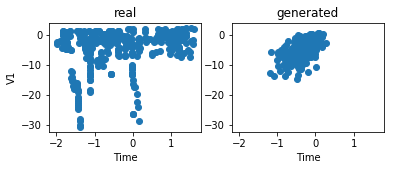

394 394
epoch: 2720, Accuracy: 0.9746192893401016
[2720/5001]	Loss_D: 0.0009	Loss_G: -0.0103	


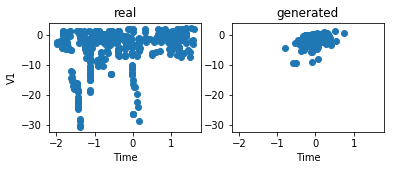

394 394
epoch: 2730, Accuracy: 0.9593908629441624
[2730/5001]	Loss_D: 0.0001	Loss_G: -0.0105	


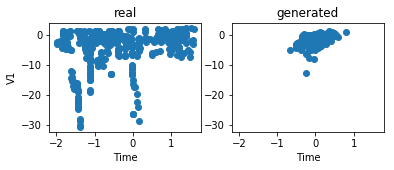

394 394
epoch: 2740, Accuracy: 0.9746192893401016
[2740/5001]	Loss_D: -0.0000	Loss_G: -0.0105	


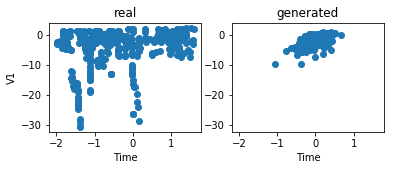

394 394
epoch: 2750, Accuracy: 0.9771573604060914
[2750/5001]	Loss_D: -0.0000	Loss_G: -0.0105	


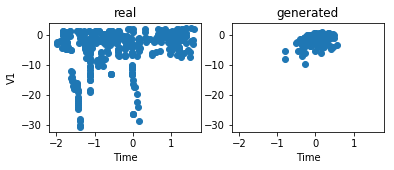

394 394
epoch: 2760, Accuracy: 0.9949238578680203
[2760/5001]	Loss_D: -0.0001	Loss_G: -0.0105	


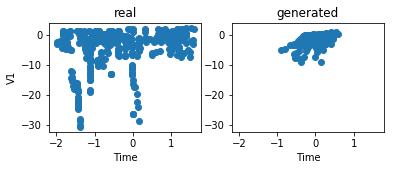

394 394
epoch: 2770, Accuracy: 0.9847715736040609
[2770/5001]	Loss_D: -0.0001	Loss_G: -0.0106	


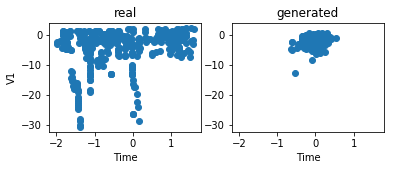

394 394
epoch: 2780, Accuracy: 0.9822335025380711
[2780/5001]	Loss_D: -0.0002	Loss_G: -0.0107	


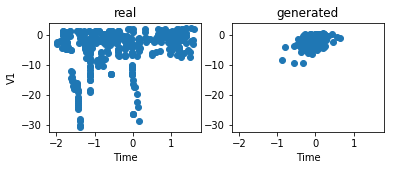

394 394
epoch: 2790, Accuracy: 0.9796954314720813
[2790/5001]	Loss_D: -0.0006	Loss_G: -0.0112	


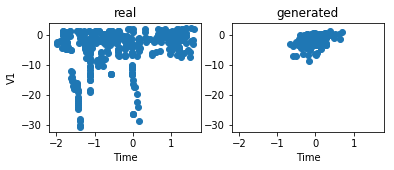

394 394
epoch: 2800, Accuracy: 0.9796954314720813
[2800/5001]	Loss_D: -0.0074	Loss_G: -0.0165	


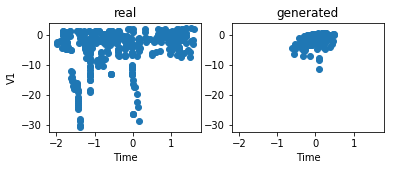

394 394
epoch: 2810, Accuracy: 0.9796954314720813
[2810/5001]	Loss_D: -0.0643	Loss_G: -0.0571	


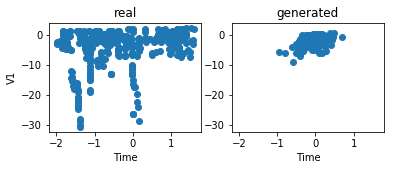

394 394
epoch: 2820, Accuracy: 0.9796954314720813
[2820/5001]	Loss_D: -0.1006	Loss_G: -0.0901	


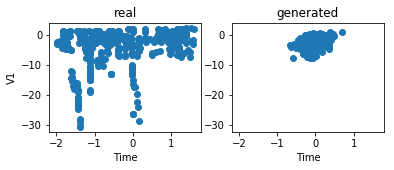

394 394
epoch: 2830, Accuracy: 0.9873096446700508
[2830/5001]	Loss_D: -0.0851	Loss_G: -0.1036	


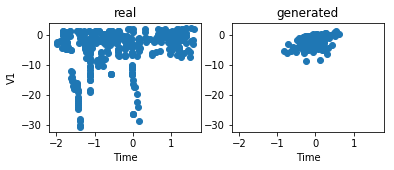

394 394
epoch: 2840, Accuracy: 0.9695431472081218
[2840/5001]	Loss_D: -0.0716	Loss_G: -0.1260	


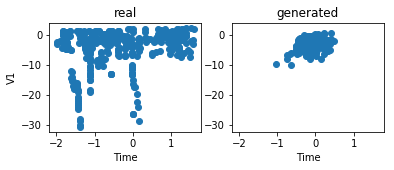

394 394
epoch: 2850, Accuracy: 0.9416243654822335
[2850/5001]	Loss_D: -0.0329	Loss_G: -0.1599	


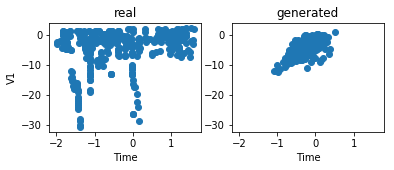

394 394
epoch: 2860, Accuracy: 0.9416243654822335
[2860/5001]	Loss_D: 0.0020	Loss_G: -0.0395	


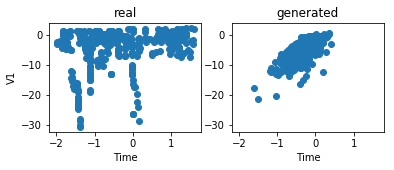

394 394
epoch: 2870, Accuracy: 0.9746192893401016
[2870/5001]	Loss_D: -0.0048	Loss_G: -0.0183	


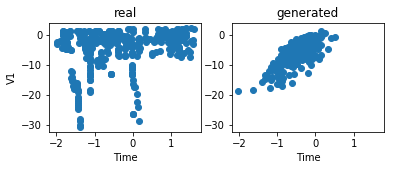

394 394
epoch: 2880, Accuracy: 0.9847715736040609
[2880/5001]	Loss_D: -0.0060	Loss_G: -0.0186	


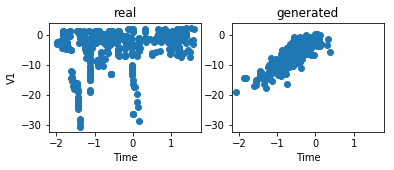

394 394
epoch: 2890, Accuracy: 0.9746192893401016
[2890/5001]	Loss_D: -0.6790	Loss_G: 3.3119	


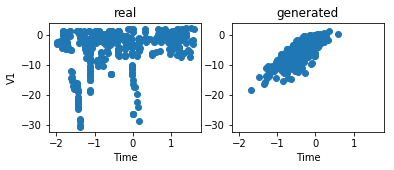

394 394
epoch: 2900, Accuracy: 0.9644670050761421
[2900/5001]	Loss_D: -0.1327	Loss_G: -0.0514	


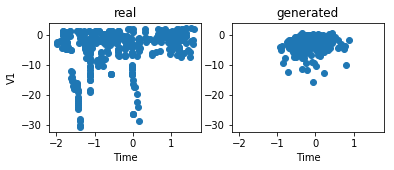

394 394
epoch: 2910, Accuracy: 0.9695431472081218
[2910/5001]	Loss_D: -0.1483	Loss_G: -0.2657	


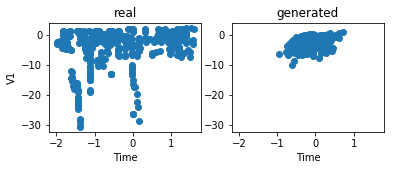

394 394
epoch: 2920, Accuracy: 0.9517766497461929
[2920/5001]	Loss_D: 0.0154	Loss_G: -0.3924	


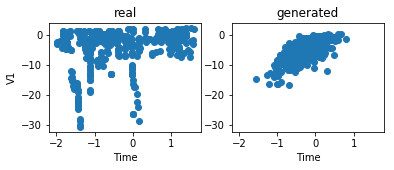

394 394
epoch: 2930, Accuracy: 0.9720812182741116
[2930/5001]	Loss_D: 0.0005	Loss_G: -0.0129	


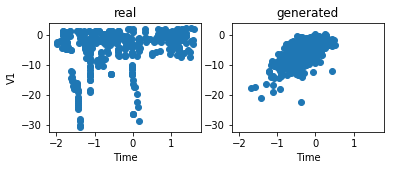

394 394
epoch: 2940, Accuracy: 0.9720812182741116
[2940/5001]	Loss_D: 0.0000	Loss_G: -0.0105	


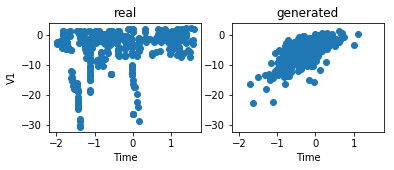

394 394
epoch: 2950, Accuracy: 0.9822335025380711
[2950/5001]	Loss_D: -0.0012	Loss_G: -0.0096	


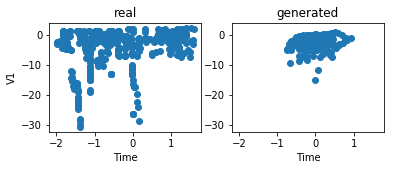

394 394
epoch: 2960, Accuracy: 0.9873096446700508
[2960/5001]	Loss_D: -0.0025	Loss_G: -0.0070	


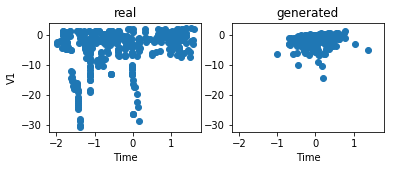

394 394
epoch: 2970, Accuracy: 0.9822335025380711
[2970/5001]	Loss_D: -0.0693	Loss_G: 0.1954	


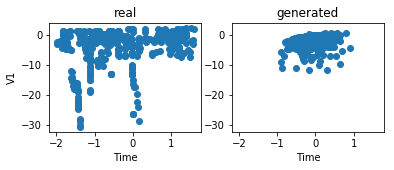

394 394
epoch: 2980, Accuracy: 0.9746192893401016
[2980/5001]	Loss_D: -0.0996	Loss_G: -0.0830	


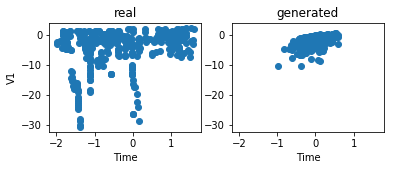

394 394
epoch: 2990, Accuracy: 0.9822335025380711
[2990/5001]	Loss_D: -0.1097	Loss_G: -0.1069	


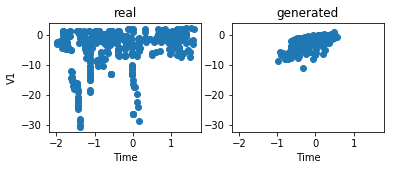

394 394
epoch: 3000, Accuracy: 0.9593908629441624
[3000/5001]	Loss_D: -0.0931	Loss_G: -0.1297	


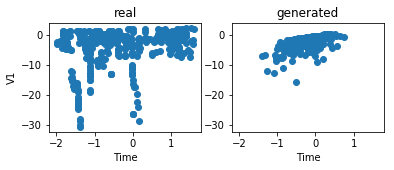

394 394
epoch: 3010, Accuracy: 0.9619289340101523
[3010/5001]	Loss_D: -0.0521	Loss_G: -0.1588	


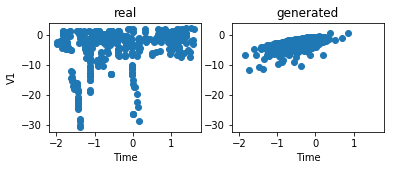

394 394
epoch: 3020, Accuracy: 0.9568527918781726
[3020/5001]	Loss_D: 0.0098	Loss_G: -0.1623	


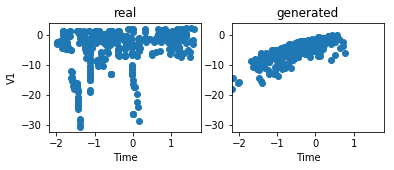

394 394
epoch: 3030, Accuracy: 0.9847715736040609
[3030/5001]	Loss_D: 0.0000	Loss_G: -0.0234	


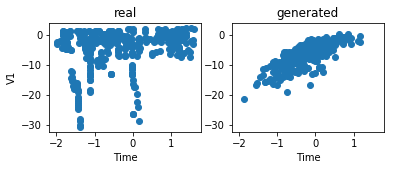

394 394
epoch: 3040, Accuracy: 0.9720812182741116
[3040/5001]	Loss_D: -0.0025	Loss_G: -0.0152	


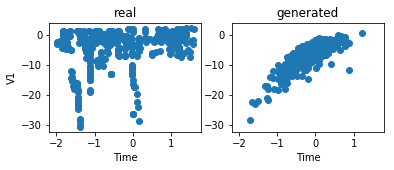

394 394
epoch: 3050, Accuracy: 0.9822335025380711
[3050/5001]	Loss_D: -0.0008	Loss_G: -0.0056	


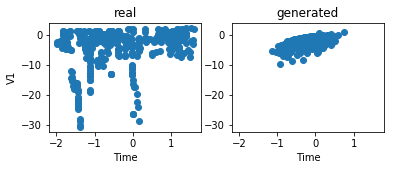

394 394
epoch: 3060, Accuracy: 0.9898477157360406
[3060/5001]	Loss_D: -0.0121	Loss_G: 0.0133	


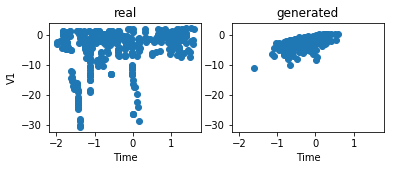

394 394
epoch: 3070, Accuracy: 0.9720812182741116
[3070/5001]	Loss_D: -0.0772	Loss_G: 0.0940	


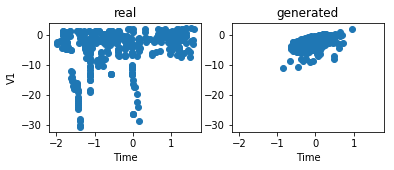

394 394
epoch: 3080, Accuracy: 0.9720812182741116
[3080/5001]	Loss_D: -0.0678	Loss_G: 0.1018	


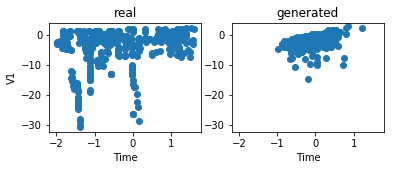

394 394
epoch: 3090, Accuracy: 0.9670050761421319
[3090/5001]	Loss_D: -0.2399	Loss_G: 0.3238	


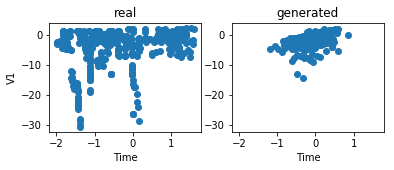

394 394
epoch: 3100, Accuracy: 0.9619289340101523
[3100/5001]	Loss_D: -0.1717	Loss_G: 0.2203	


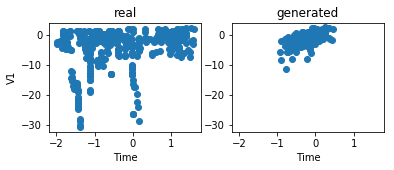

394 394
epoch: 3110, Accuracy: 0.9568527918781726
[3110/5001]	Loss_D: -0.1473	Loss_G: 0.2155	


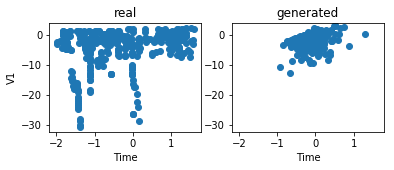

394 394
epoch: 3120, Accuracy: 0.9619289340101523
[3120/5001]	Loss_D: -0.1289	Loss_G: 0.1470	


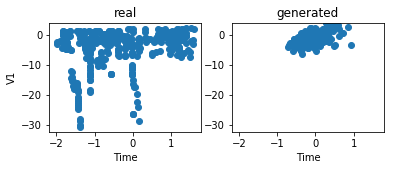

394 394
epoch: 3130, Accuracy: 0.9847715736040609
[3130/5001]	Loss_D: -0.2140	Loss_G: -0.1345	


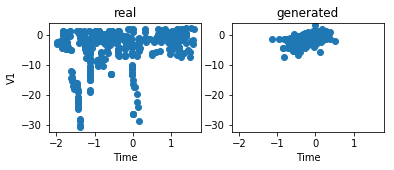

394 394
epoch: 3140, Accuracy: 0.9593908629441624
[3140/5001]	Loss_D: -0.1799	Loss_G: -0.2656	


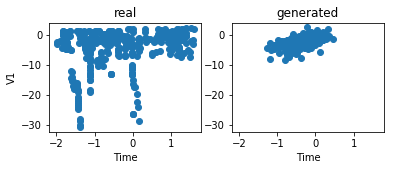

394 394
epoch: 3150, Accuracy: 0.949238578680203
[3150/5001]	Loss_D: 0.0159	Loss_G: -0.3040	


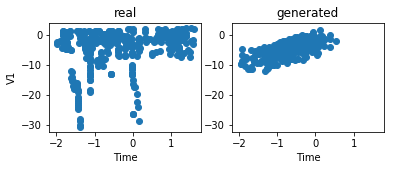

394 394
epoch: 3160, Accuracy: 0.9670050761421319
[3160/5001]	Loss_D: 0.0004	Loss_G: -0.0117	


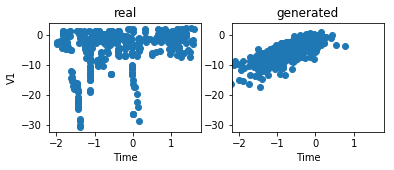

394 394
epoch: 3170, Accuracy: 0.9796954314720813
[3170/5001]	Loss_D: -0.0000	Loss_G: -0.0100	


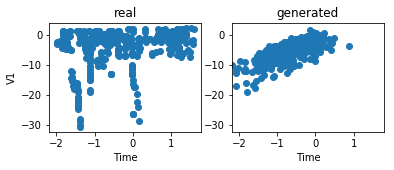

394 394
epoch: 3180, Accuracy: 0.9695431472081218
[3180/5001]	Loss_D: -0.0004	Loss_G: -0.0091	


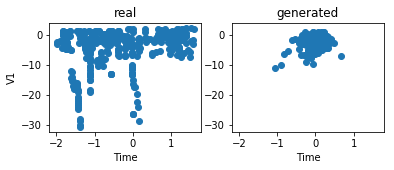

394 394
epoch: 3190, Accuracy: 0.9644670050761421
[3190/5001]	Loss_D: 0.1100	Loss_G: -0.7044	


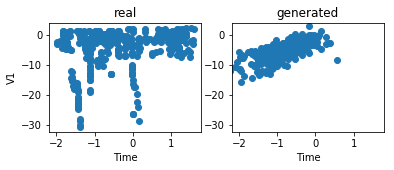

394 394
epoch: 3200, Accuracy: 0.9822335025380711
[3200/5001]	Loss_D: 0.0819	Loss_G: 0.3866	


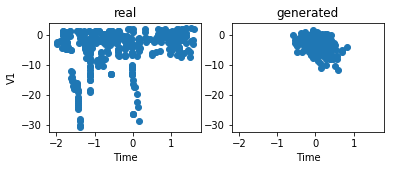

394 394
epoch: 3210, Accuracy: 0.9593908629441624
[3210/5001]	Loss_D: 0.1284	Loss_G: -0.5743	


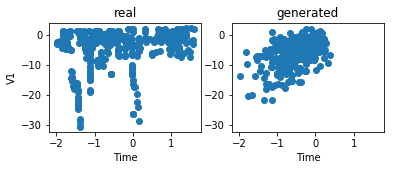

394 394
epoch: 3220, Accuracy: 0.9822335025380711
[3220/5001]	Loss_D: 0.0057	Loss_G: 0.0001	


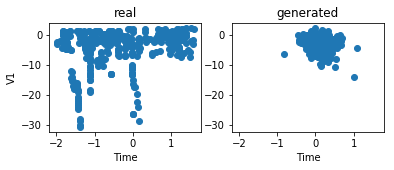

394 394
epoch: 3230, Accuracy: 0.9746192893401016
[3230/5001]	Loss_D: -0.0000	Loss_G: -0.0098	


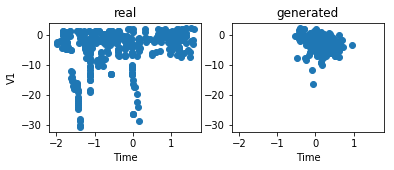

394 394
epoch: 3240, Accuracy: 0.9796954314720813
[3240/5001]	Loss_D: -0.0002	Loss_G: -0.0094	


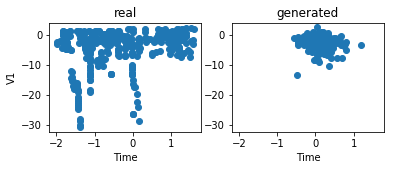

394 394
epoch: 3250, Accuracy: 0.9720812182741116
[3250/5001]	Loss_D: -0.0004	Loss_G: -0.0088	


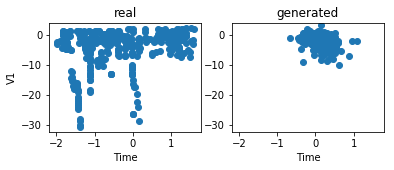

394 394
epoch: 3260, Accuracy: 0.9873096446700508
[3260/5001]	Loss_D: -0.0006	Loss_G: -0.0081	


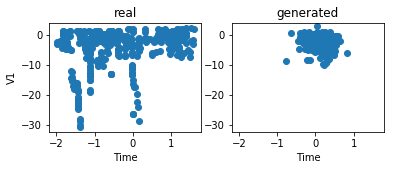

394 394
epoch: 3270, Accuracy: 0.9746192893401016
[3270/5001]	Loss_D: -0.0010	Loss_G: -0.0072	


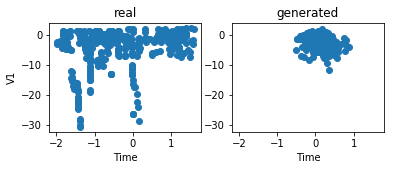

394 394
epoch: 3280, Accuracy: 0.9720812182741116
[3280/5001]	Loss_D: -0.0015	Loss_G: -0.0062	


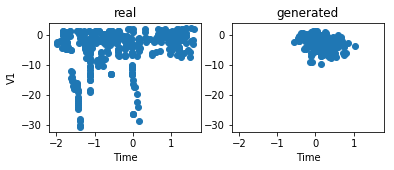

394 394
epoch: 3290, Accuracy: 0.9619289340101523
[3290/5001]	Loss_D: -0.0026	Loss_G: -0.0049	


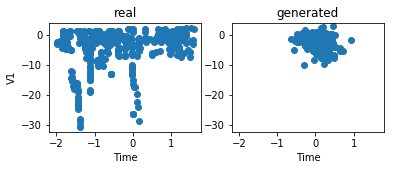

394 394
epoch: 3300, Accuracy: 0.9898477157360406
[3300/5001]	Loss_D: -0.2123	Loss_G: 0.2708	


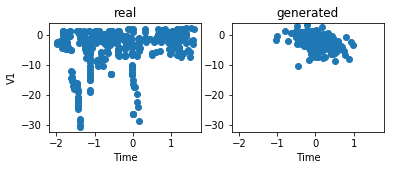

394 394
epoch: 3310, Accuracy: 0.9771573604060914
[3310/5001]	Loss_D: -0.1516	Loss_G: -0.1723	


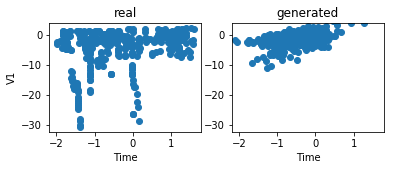

394 394
epoch: 3320, Accuracy: 0.9720812182741116
[3320/5001]	Loss_D: -0.0970	Loss_G: -0.3099	


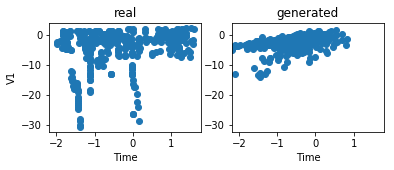

394 394
epoch: 3330, Accuracy: 0.9619289340101523
[3330/5001]	Loss_D: 0.0027	Loss_G: -0.0269	


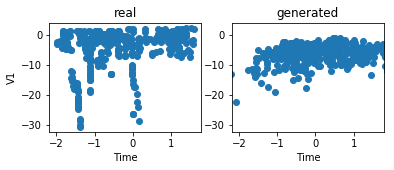

394 394
epoch: 3340, Accuracy: 0.9771573604060914
[3340/5001]	Loss_D: -0.2790	Loss_G: 1.3082	


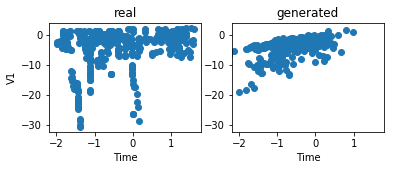

394 394
epoch: 3350, Accuracy: 0.9695431472081218
[3350/5001]	Loss_D: -0.1310	Loss_G: -0.1123	


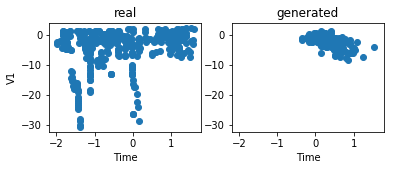

394 394
epoch: 3360, Accuracy: 0.9593908629441624
[3360/5001]	Loss_D: -0.1200	Loss_G: -0.1798	


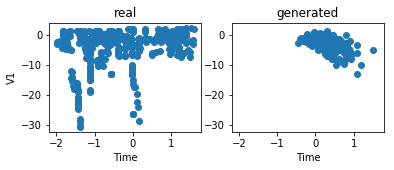

394 394
epoch: 3370, Accuracy: 0.9720812182741116
[3370/5001]	Loss_D: -0.0284	Loss_G: -0.2727	


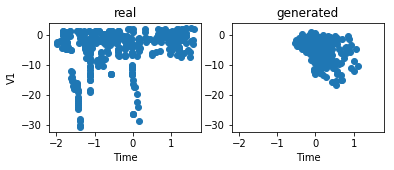

394 394
epoch: 3380, Accuracy: 0.949238578680203
[3380/5001]	Loss_D: -0.0123	Loss_G: -0.0320	


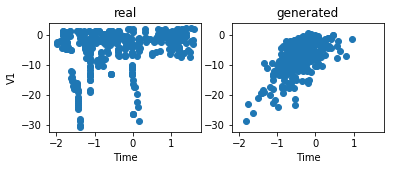

394 394
epoch: 3390, Accuracy: 0.9593908629441624
[3390/5001]	Loss_D: -0.0106	Loss_G: -0.0274	


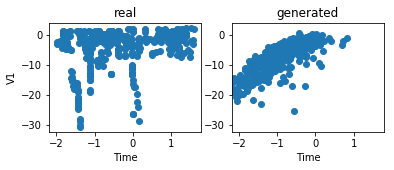

394 394
epoch: 3400, Accuracy: 0.9720812182741116
[3400/5001]	Loss_D: -0.0079	Loss_G: -0.0219	


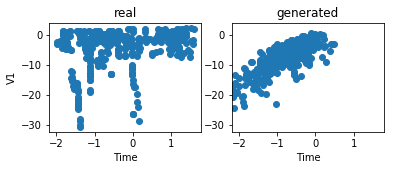

394 394
epoch: 3410, Accuracy: 0.9670050761421319
[3410/5001]	Loss_D: -0.0050	Loss_G: 0.0049	


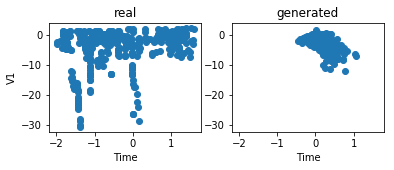

394 394
epoch: 3420, Accuracy: 0.9720812182741116
[3420/5001]	Loss_D: -0.0286	Loss_G: 0.0889	


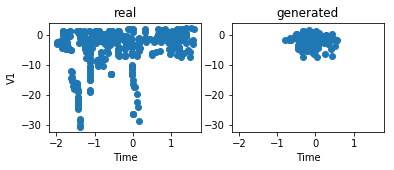

394 394
epoch: 3430, Accuracy: 0.9796954314720813
[3430/5001]	Loss_D: -0.0792	Loss_G: 0.1193	


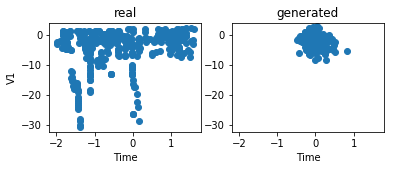

394 394
epoch: 3440, Accuracy: 0.9644670050761421
[3440/5001]	Loss_D: -0.0799	Loss_G: 0.1658	


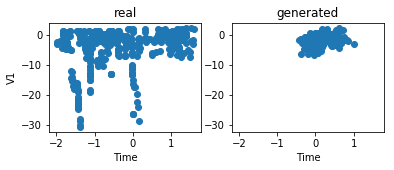

394 394
epoch: 3450, Accuracy: 0.9670050761421319
[3450/5001]	Loss_D: -0.0927	Loss_G: 0.1676	


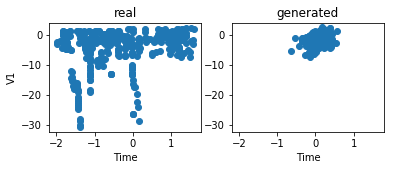

394 394
epoch: 3460, Accuracy: 0.9847715736040609
[3460/5001]	Loss_D: -0.2357	Loss_G: 0.3312	


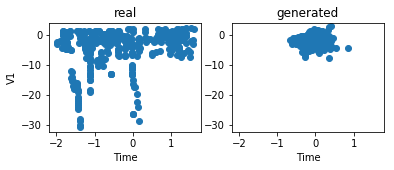

394 394
epoch: 3470, Accuracy: 0.9873096446700508
[3470/5001]	Loss_D: -0.0530	Loss_G: -0.0506	


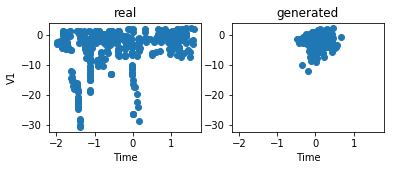

394 394
epoch: 3480, Accuracy: 0.9923857868020305
[3480/5001]	Loss_D: -0.0836	Loss_G: -0.0738	


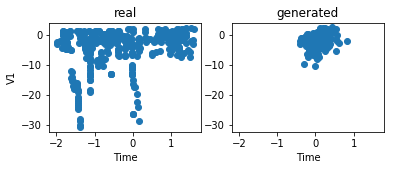

394 394
epoch: 3490, Accuracy: 0.9847715736040609
[3490/5001]	Loss_D: -0.0887	Loss_G: -0.0923	


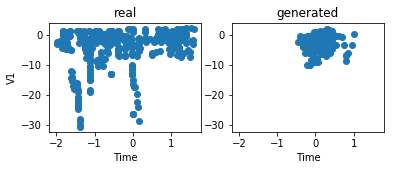

394 394
epoch: 3500, Accuracy: 0.9974619289340102
[3500/5001]	Loss_D: -0.0801	Loss_G: -0.1110	


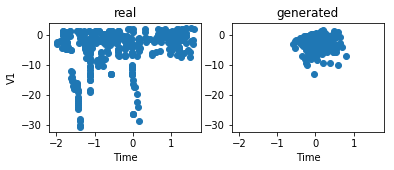

394 394
epoch: 3510, Accuracy: 0.9923857868020305
[3510/5001]	Loss_D: -0.0572	Loss_G: -0.1369	


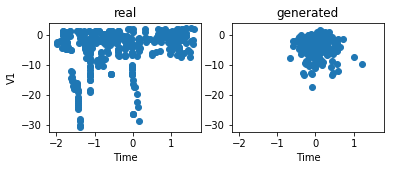

394 394
epoch: 3520, Accuracy: 0.9796954314720813
[3520/5001]	Loss_D: -0.0242	Loss_G: -0.1785	


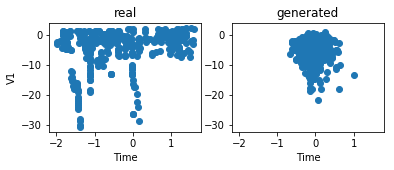

394 394
epoch: 3530, Accuracy: 0.9695431472081218
[3530/5001]	Loss_D: 0.0016	Loss_G: -0.0222	


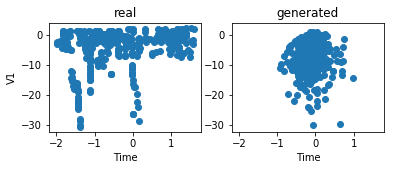

394 394
epoch: 3540, Accuracy: 0.9847715736040609
[3540/5001]	Loss_D: 0.0001	Loss_G: -0.0104	


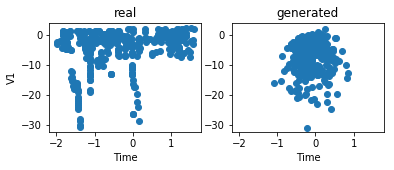

394 394
epoch: 3550, Accuracy: 0.9746192893401016
[3550/5001]	Loss_D: -0.1232	Loss_G: 0.9664	


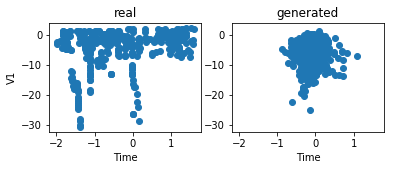

394 394
epoch: 3560, Accuracy: 0.9949238578680203
[3560/5001]	Loss_D: -0.0000	Loss_G: -0.0095	


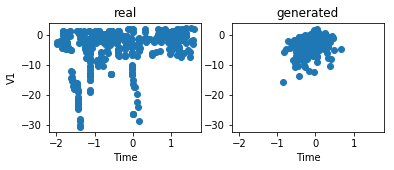

394 394
epoch: 3570, Accuracy: 0.9644670050761421
[3570/5001]	Loss_D: -0.0002	Loss_G: -0.0087	


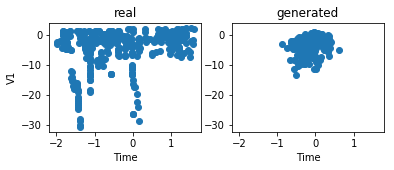

394 394
epoch: 3580, Accuracy: 0.9746192893401016
[3580/5001]	Loss_D: -0.0003	Loss_G: -0.0074	


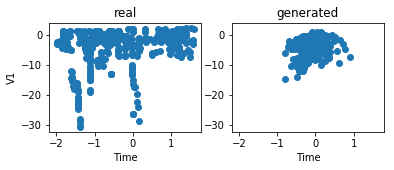

394 394
epoch: 3590, Accuracy: 0.9873096446700508
[3590/5001]	Loss_D: -0.0007	Loss_G: -0.0058	


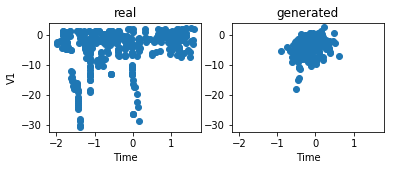

394 394
epoch: 3600, Accuracy: 0.9898477157360406
[3600/5001]	Loss_D: -0.0010	Loss_G: -0.0039	


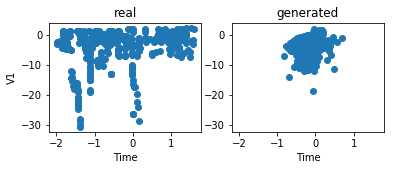

394 394
epoch: 3610, Accuracy: 0.9898477157360406
[3610/5001]	Loss_D: -0.0016	Loss_G: -0.0015	


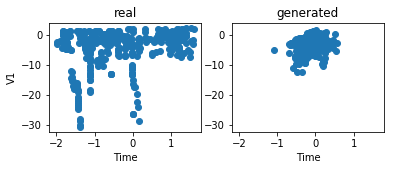

394 394
epoch: 3620, Accuracy: 0.9847715736040609
[3620/5001]	Loss_D: -0.0022	Loss_G: -0.0018	


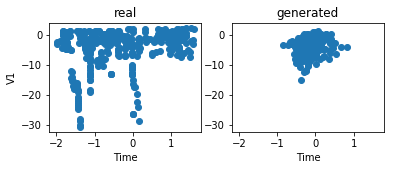

394 394
epoch: 3630, Accuracy: 0.9822335025380711
[3630/5001]	Loss_D: -0.0519	Loss_G: -0.1686	


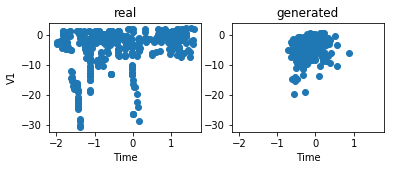

394 394
epoch: 3640, Accuracy: 0.9695431472081218
[3640/5001]	Loss_D: 0.0002	Loss_G: -0.0371	


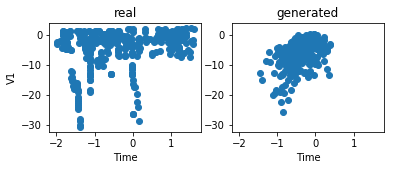

394 394
epoch: 3650, Accuracy: 0.9796954314720813
[3650/5001]	Loss_D: -0.0603	Loss_G: -0.1471	


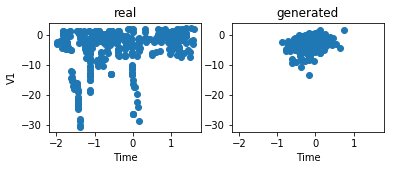

394 394
epoch: 3660, Accuracy: 0.9619289340101523
[3660/5001]	Loss_D: -0.0066	Loss_G: -0.2375	


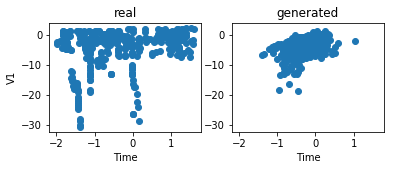

394 394
epoch: 3670, Accuracy: 0.9746192893401016
[3670/5001]	Loss_D: -0.0139	Loss_G: -0.0359	


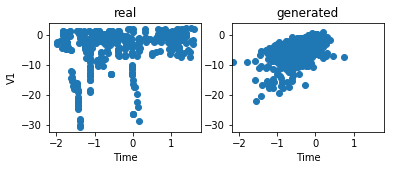

394 394
epoch: 3680, Accuracy: 0.9517766497461929
[3680/5001]	Loss_D: -0.0034	Loss_G: -0.0280	


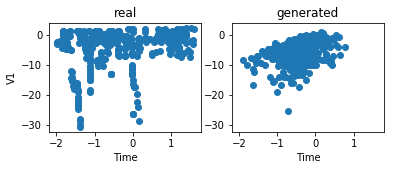

394 394
epoch: 3690, Accuracy: 0.9771573604060914
[3690/5001]	Loss_D: -0.0005	Loss_G: -0.0084	


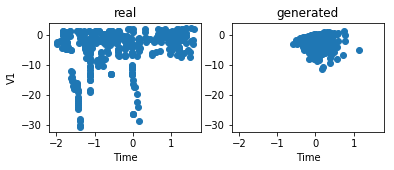

394 394
epoch: 3700, Accuracy: 0.9822335025380711
[3700/5001]	Loss_D: -0.0042	Loss_G: -0.0002	


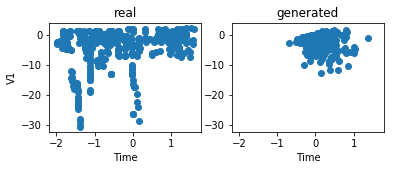

394 394
epoch: 3710, Accuracy: 0.9796954314720813
[3710/5001]	Loss_D: -0.1020	Loss_G: -0.1009	


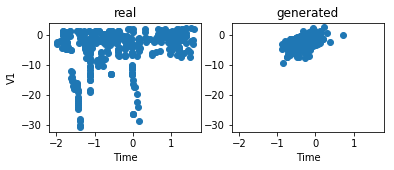

394 394
epoch: 3720, Accuracy: 0.9746192893401016
[3720/5001]	Loss_D: -0.1109	Loss_G: -0.1445	


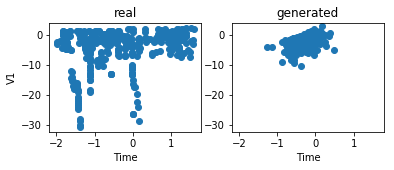

394 394
epoch: 3730, Accuracy: 0.9568527918781726
[3730/5001]	Loss_D: -0.0764	Loss_G: -0.1877	


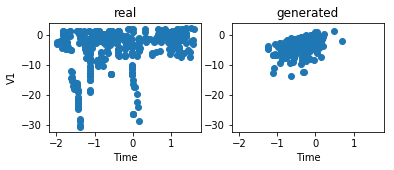

394 394
epoch: 3740, Accuracy: 0.9873096446700508
[3740/5001]	Loss_D: -0.0210	Loss_G: -0.2152	


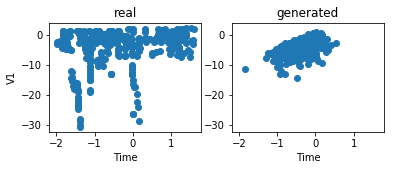

394 394
epoch: 3750, Accuracy: 0.9771573604060914
[3750/5001]	Loss_D: -0.0078	Loss_G: -0.0514	


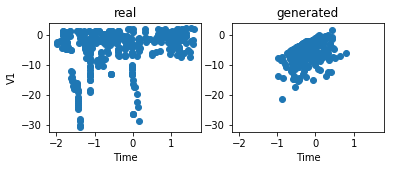

394 394
epoch: 3760, Accuracy: 0.9644670050761421
[3760/5001]	Loss_D: -0.0961	Loss_G: 0.2166	


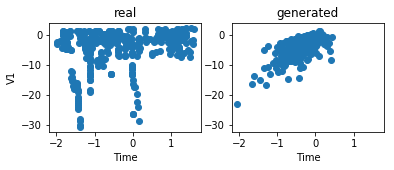

394 394
epoch: 3770, Accuracy: 0.9467005076142132
[3770/5001]	Loss_D: -0.1036	Loss_G: -0.2725	


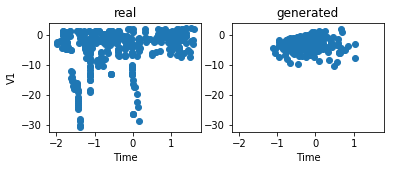

394 394
epoch: 3780, Accuracy: 0.9670050761421319
[3780/5001]	Loss_D: 0.0179	Loss_G: -0.2278	


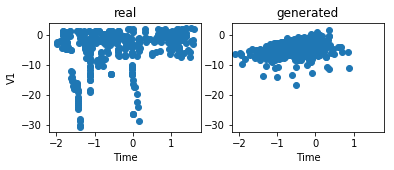

394 394
epoch: 3790, Accuracy: 0.9746192893401016
[3790/5001]	Loss_D: 0.0000	Loss_G: -0.0164	


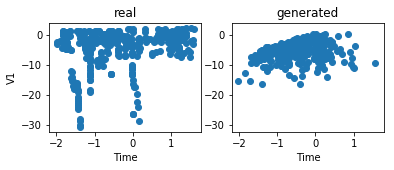

394 394
epoch: 3800, Accuracy: 0.9746192893401016
[3800/5001]	Loss_D: -0.0019	Loss_G: -0.0150	


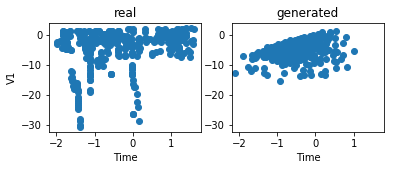

394 394
epoch: 3810, Accuracy: 0.9670050761421319
[3810/5001]	Loss_D: -0.0078	Loss_G: -0.0266	


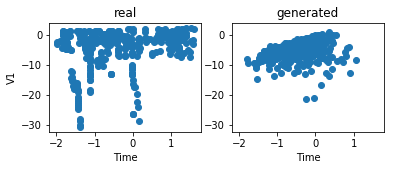

394 394
epoch: 3820, Accuracy: 0.9670050761421319
[3820/5001]	Loss_D: 0.2059	Loss_G: 0.9274	


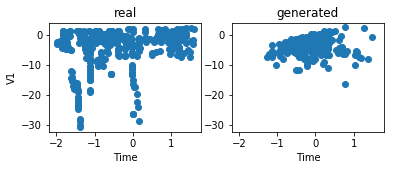

394 394
epoch: 3830, Accuracy: 0.9644670050761421
[3830/5001]	Loss_D: -0.0306	Loss_G: -0.0446	


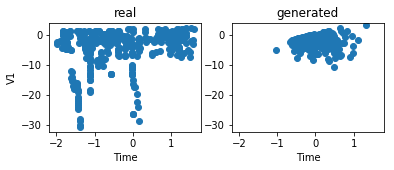

394 394
epoch: 3840, Accuracy: 0.9746192893401016
[3840/5001]	Loss_D: -0.1699	Loss_G: -0.2618	


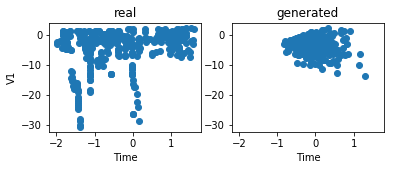

394 394
epoch: 3850, Accuracy: 0.9746192893401016
[3850/5001]	Loss_D: -0.0605	Loss_G: -0.3869	


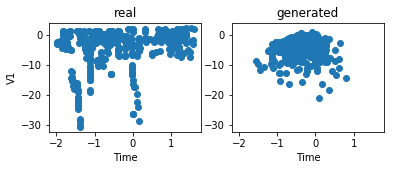

394 394
epoch: 3860, Accuracy: 0.9796954314720813
[3860/5001]	Loss_D: -0.0227	Loss_G: -0.0900	


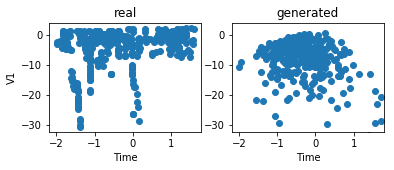

394 394
epoch: 3870, Accuracy: 0.9390862944162437
[3870/5001]	Loss_D: -0.2883	Loss_G: 3.1284	


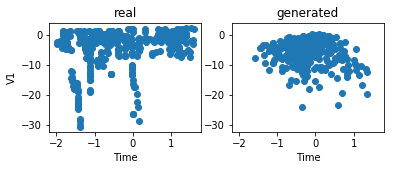

394 394
epoch: 3880, Accuracy: 0.9720812182741116
[3880/5001]	Loss_D: -0.0417	Loss_G: -0.0840	


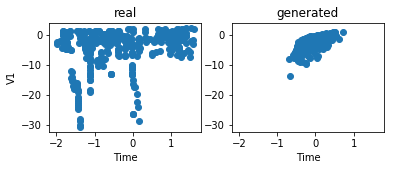

394 394
epoch: 3890, Accuracy: 0.9847715736040609
[3890/5001]	Loss_D: -0.0736	Loss_G: -0.1947	


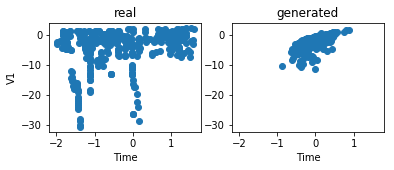

394 394
epoch: 3900, Accuracy: 0.9796954314720813
[3900/5001]	Loss_D: -0.0253	Loss_G: -0.3037	


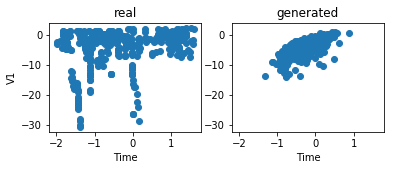

394 394
epoch: 3910, Accuracy: 0.9847715736040609
[3910/5001]	Loss_D: 0.0017	Loss_G: -0.0429	


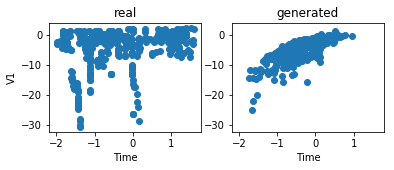

394 394
epoch: 3920, Accuracy: 0.9822335025380711
[3920/5001]	Loss_D: -0.0047	Loss_G: -0.0194	


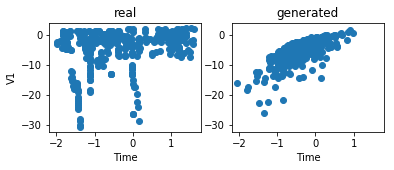

394 394
epoch: 3930, Accuracy: 0.9796954314720813
[3930/5001]	Loss_D: -0.0064	Loss_G: -0.0192	


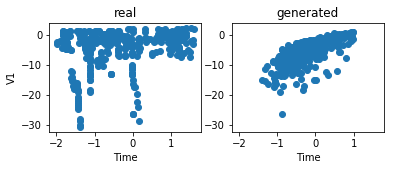

394 394
epoch: 3940, Accuracy: 0.9670050761421319
[3940/5001]	Loss_D: -0.0076	Loss_G: -0.0206	


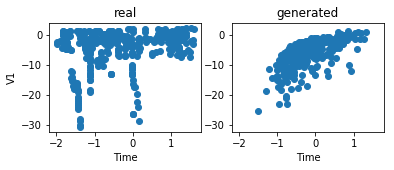

394 394
epoch: 3950, Accuracy: 0.9720812182741116
[3950/5001]	Loss_D: -0.0083	Loss_G: -0.0191	


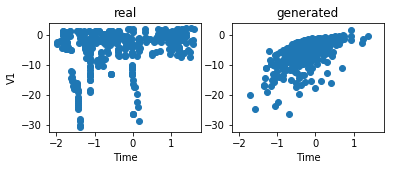

394 394
epoch: 3960, Accuracy: 0.9644670050761421
[3960/5001]	Loss_D: -0.0545	Loss_G: -0.1135	


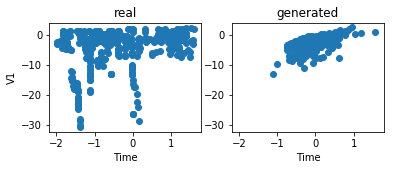

394 394
epoch: 3970, Accuracy: 0.9670050761421319
[3970/5001]	Loss_D: -0.0556	Loss_G: -0.2182	


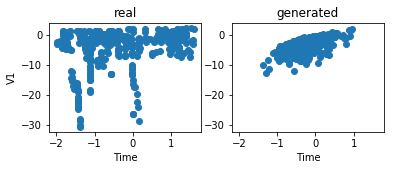

394 394
epoch: 3980, Accuracy: 0.9619289340101523
[3980/5001]	Loss_D: 0.0057	Loss_G: -0.2172	


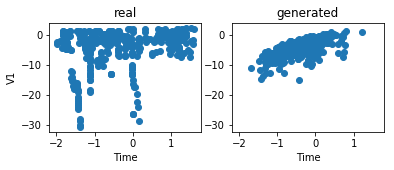

394 394
epoch: 3990, Accuracy: 0.9771573604060914
[3990/5001]	Loss_D: -0.0059	Loss_G: -0.0272	


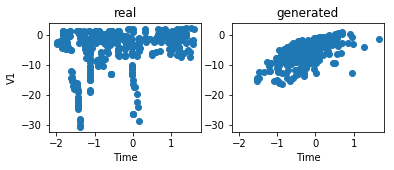

394 394
epoch: 4000, Accuracy: 0.9720812182741116
[4000/5001]	Loss_D: -0.0028	Loss_G: -0.0260	


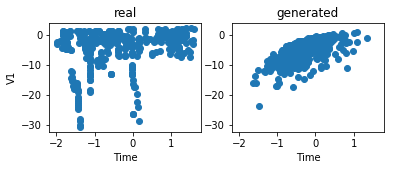

394 394
epoch: 4010, Accuracy: 0.9670050761421319
[4010/5001]	Loss_D: -0.0424	Loss_G: 0.0970	


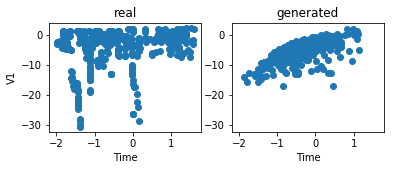

394 394
epoch: 4020, Accuracy: 0.9695431472081218
[4020/5001]	Loss_D: -0.0012	Loss_G: -0.0078	


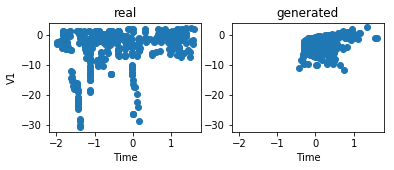

394 394
epoch: 4030, Accuracy: 0.9720812182741116
[4030/5001]	Loss_D: -0.0518	Loss_G: -0.0788	


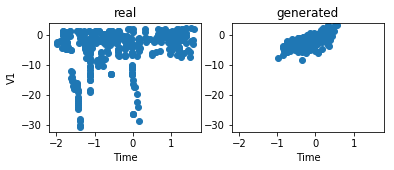

394 394
epoch: 4040, Accuracy: 0.9568527918781726
[4040/5001]	Loss_D: -0.0765	Loss_G: -0.1507	


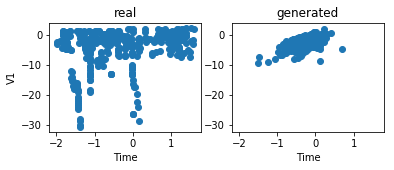

394 394
epoch: 4050, Accuracy: 0.9619289340101523
[4050/5001]	Loss_D: -0.0454	Loss_G: -0.1921	


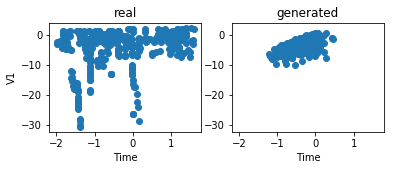

394 394
epoch: 4060, Accuracy: 0.9746192893401016
[4060/5001]	Loss_D: -0.0073	Loss_G: -0.1593	


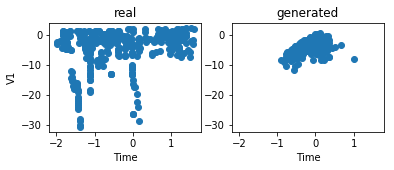

394 394
epoch: 4070, Accuracy: 0.9822335025380711
[4070/5001]	Loss_D: -0.0103	Loss_G: -0.0407	


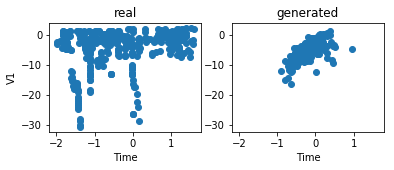

394 394
epoch: 4080, Accuracy: 0.9771573604060914
[4080/5001]	Loss_D: -0.0010	Loss_G: -0.0318	


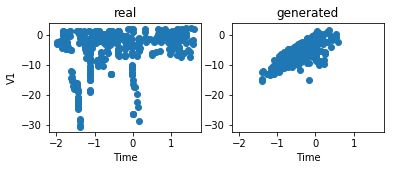

394 394
epoch: 4090, Accuracy: 0.9771573604060914
[4090/5001]	Loss_D: -0.0029	Loss_G: -0.0189	


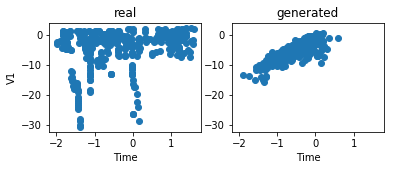

394 394
epoch: 4100, Accuracy: 0.9543147208121827
[4100/5001]	Loss_D: -0.1175	Loss_G: 0.1847	


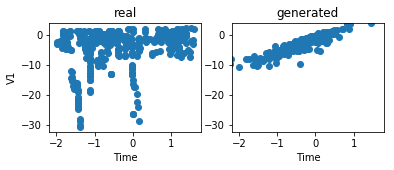

394 394
epoch: 4110, Accuracy: 0.9695431472081218
[4110/5001]	Loss_D: -0.2842	Loss_G: 0.3908	


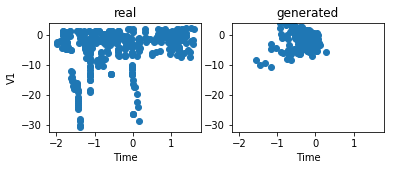

394 394
epoch: 4120, Accuracy: 0.934010152284264
[4120/5001]	Loss_D: -0.2042	Loss_G: 0.2853	


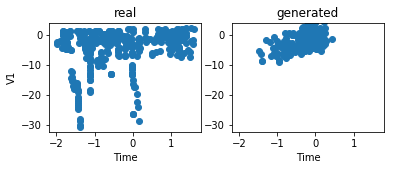

394 394
epoch: 4130, Accuracy: 0.9467005076142132
[4130/5001]	Loss_D: -0.0907	Loss_G: 0.0949	


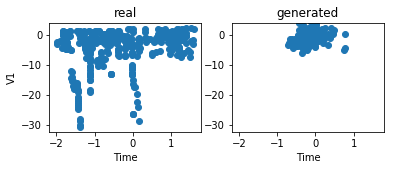

394 394
epoch: 4140, Accuracy: 0.9670050761421319
[4140/5001]	Loss_D: -0.1240	Loss_G: 0.1652	


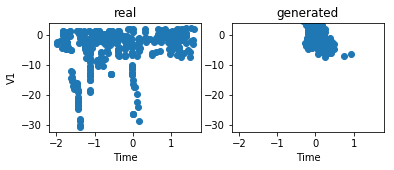

394 394
epoch: 4150, Accuracy: 0.9593908629441624
[4150/5001]	Loss_D: -0.0608	Loss_G: 0.0796	


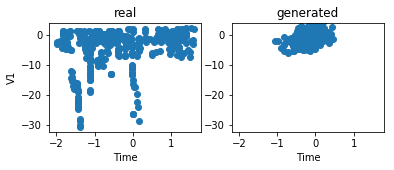

394 394
epoch: 4160, Accuracy: 0.9644670050761421
[4160/5001]	Loss_D: -0.1230	Loss_G: 0.1548	


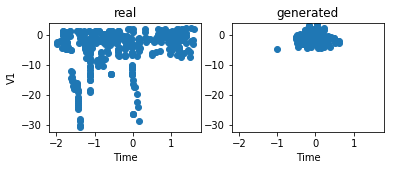

394 394
epoch: 4170, Accuracy: 0.9771573604060914
[4170/5001]	Loss_D: -0.1096	Loss_G: 0.1245	


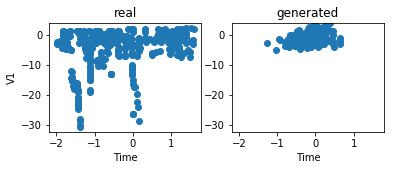

394 394
epoch: 4180, Accuracy: 0.9746192893401016
[4180/5001]	Loss_D: -0.1288	Loss_G: 0.1592	


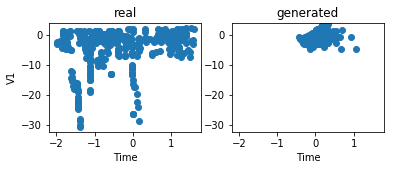

394 394
epoch: 4190, Accuracy: 0.9644670050761421
[4190/5001]	Loss_D: -0.1166	Loss_G: 0.1407	


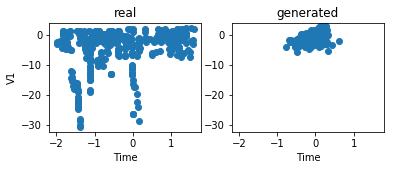

394 394
epoch: 4200, Accuracy: 0.9720812182741116
[4200/5001]	Loss_D: -0.1264	Loss_G: 0.1488	


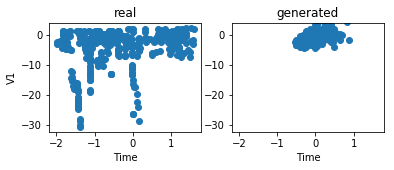

394 394
epoch: 4210, Accuracy: 0.9822335025380711
[4210/5001]	Loss_D: -0.1337	Loss_G: 0.1530	


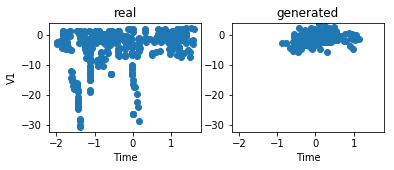

394 394
epoch: 4220, Accuracy: 0.9593908629441624
[4220/5001]	Loss_D: -0.1308	Loss_G: 0.1503	


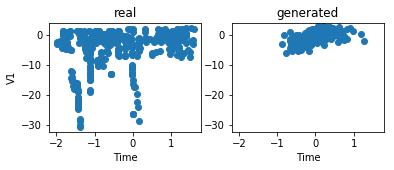

394 394
epoch: 4230, Accuracy: 0.9543147208121827
[4230/5001]	Loss_D: -0.1349	Loss_G: 0.1432	


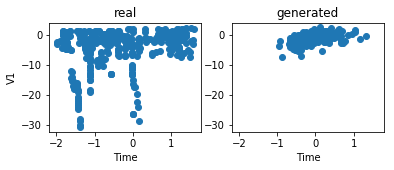

394 394
epoch: 4240, Accuracy: 0.9771573604060914
[4240/5001]	Loss_D: -0.1342	Loss_G: 0.1522	


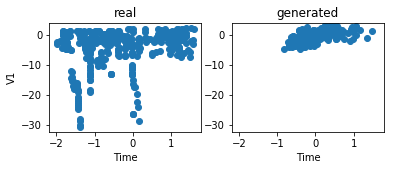

394 394
epoch: 4250, Accuracy: 0.9720812182741116
[4250/5001]	Loss_D: -0.1214	Loss_G: 0.1312	


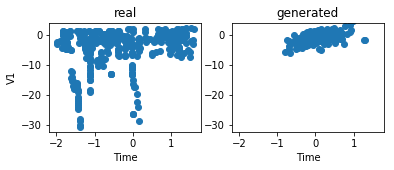

394 394
epoch: 4260, Accuracy: 0.9771573604060914
[4260/5001]	Loss_D: -0.1275	Loss_G: 0.1454	


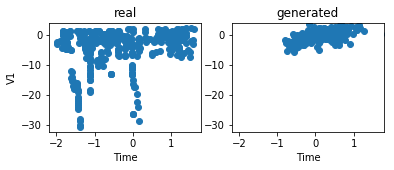

394 394
epoch: 4270, Accuracy: 0.9593908629441624
[4270/5001]	Loss_D: -0.1361	Loss_G: 0.1433	


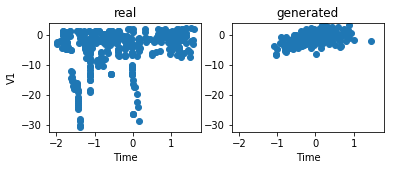

394 394
epoch: 4280, Accuracy: 0.9568527918781726
[4280/5001]	Loss_D: -0.1221	Loss_G: 0.1471	


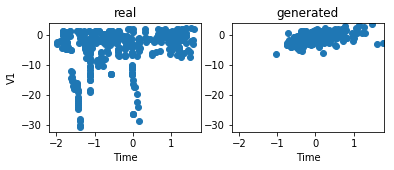

394 394
epoch: 4290, Accuracy: 0.9593908629441624
[4290/5001]	Loss_D: -0.1266	Loss_G: 0.1484	


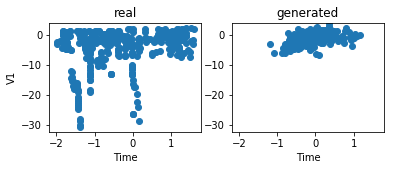

394 394
epoch: 4300, Accuracy: 0.9644670050761421
[4300/5001]	Loss_D: -0.1281	Loss_G: 0.1476	


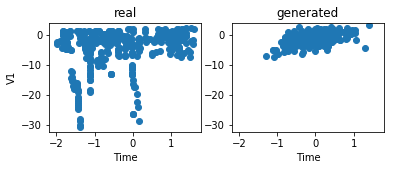

394 394
epoch: 4310, Accuracy: 0.9695431472081218
[4310/5001]	Loss_D: -0.1083	Loss_G: 0.1348	


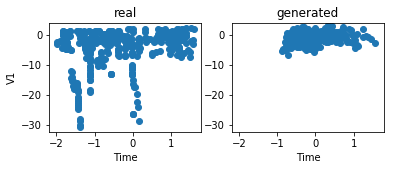

394 394
epoch: 4320, Accuracy: 0.9822335025380711
[4320/5001]	Loss_D: -0.1200	Loss_G: 0.1305	


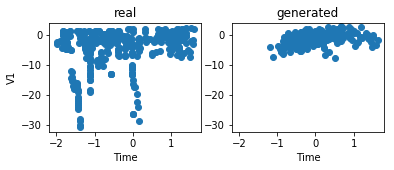

394 394
epoch: 4330, Accuracy: 0.9670050761421319
[4330/5001]	Loss_D: -0.1127	Loss_G: 0.1345	


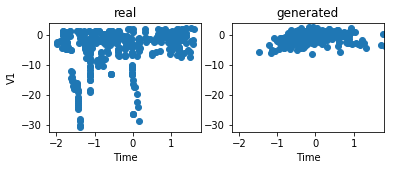

394 394
epoch: 4340, Accuracy: 0.9644670050761421
[4340/5001]	Loss_D: -0.1150	Loss_G: 0.1362	


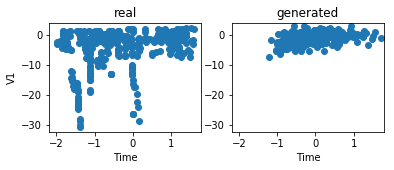

394 394
epoch: 4350, Accuracy: 0.9593908629441624
[4350/5001]	Loss_D: -0.1045	Loss_G: 0.1257	


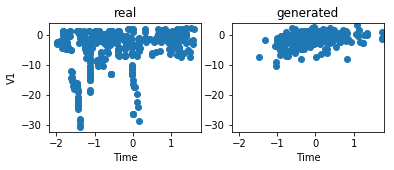

394 394
epoch: 4360, Accuracy: 0.949238578680203
[4360/5001]	Loss_D: -0.1226	Loss_G: 0.1424	


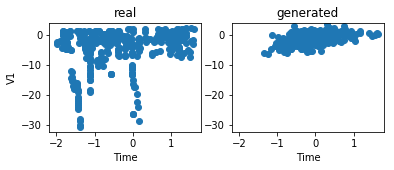

394 394
epoch: 4370, Accuracy: 0.9365482233502538
[4370/5001]	Loss_D: -0.1075	Loss_G: 0.1306	


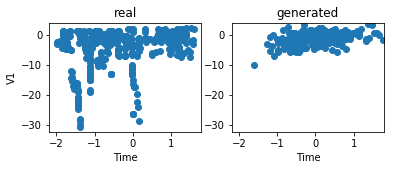

394 394
epoch: 4380, Accuracy: 0.9568527918781726
[4380/5001]	Loss_D: -0.1246	Loss_G: 0.1475	


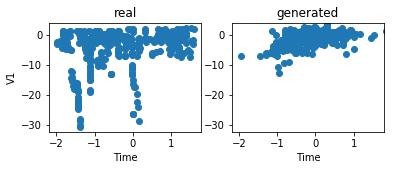

394 394
epoch: 4390, Accuracy: 0.9441624365482234
[4390/5001]	Loss_D: -0.1055	Loss_G: 0.1405	


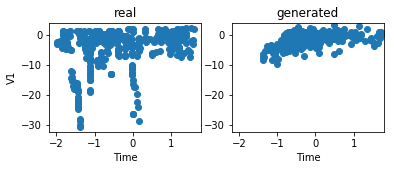

394 394
epoch: 4400, Accuracy: 0.9441624365482234
[4400/5001]	Loss_D: -0.1002	Loss_G: 0.1264	


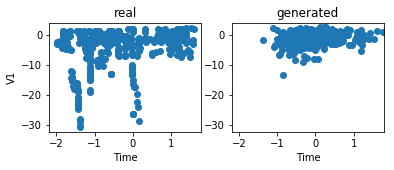

394 394
epoch: 4410, Accuracy: 0.9619289340101523
[4410/5001]	Loss_D: -0.1044	Loss_G: 0.1562	


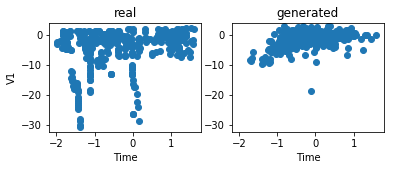

394 394
epoch: 4420, Accuracy: 0.9517766497461929
[4420/5001]	Loss_D: -0.0969	Loss_G: 0.1259	


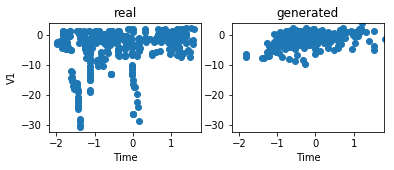

394 394
epoch: 4430, Accuracy: 0.9035532994923858
[4430/5001]	Loss_D: -0.1045	Loss_G: 0.1579	


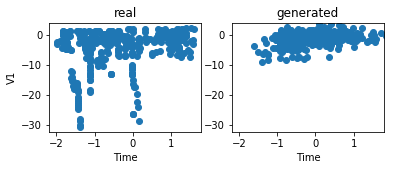

394 394
epoch: 4440, Accuracy: 0.9416243654822335
[4440/5001]	Loss_D: -0.0748	Loss_G: -0.0623	


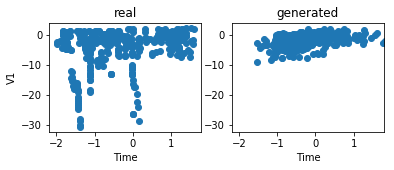

394 394
epoch: 4450, Accuracy: 0.9416243654822335
[4450/5001]	Loss_D: 0.0170	Loss_G: -0.1692	


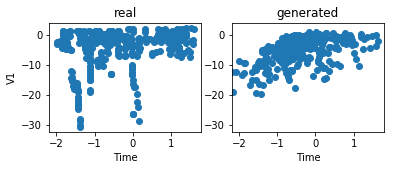

394 394
epoch: 4460, Accuracy: 0.9441624365482234
[4460/5001]	Loss_D: 0.0642	Loss_G: 0.0980	


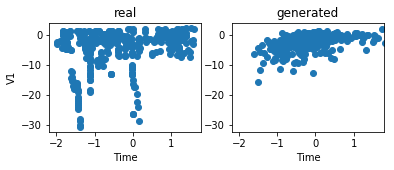

394 394
epoch: 4470, Accuracy: 0.9670050761421319
[4470/5001]	Loss_D: -0.0002	Loss_G: -0.0096	


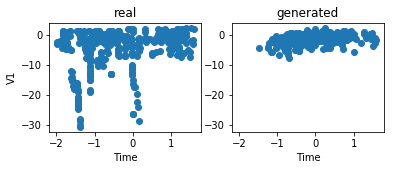

394 394
epoch: 4480, Accuracy: 0.9441624365482234
[4480/5001]	Loss_D: -0.0012	Loss_G: -0.0088	


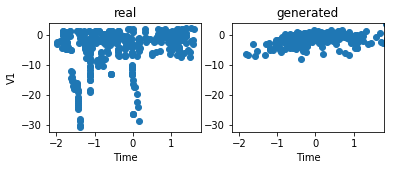

394 394
epoch: 4490, Accuracy: 0.9441624365482234
[4490/5001]	Loss_D: -0.0023	Loss_G: -0.0077	


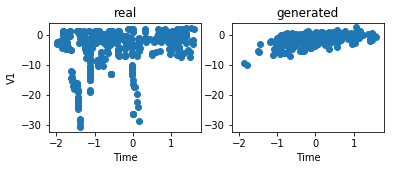

394 394
epoch: 4500, Accuracy: 0.9213197969543148
[4500/5001]	Loss_D: -0.0039	Loss_G: -0.0069	


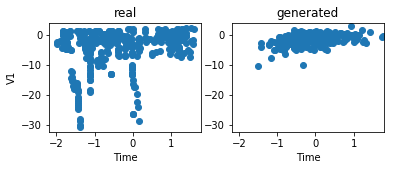

394 394
epoch: 4510, Accuracy: 0.9441624365482234
[4510/5001]	Loss_D: -0.1862	Loss_G: -0.1914	


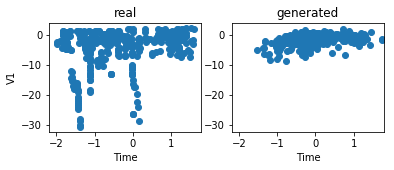

394 394
epoch: 4520, Accuracy: 0.9441624365482234
[4520/5001]	Loss_D: -0.0214	Loss_G: -0.3348	


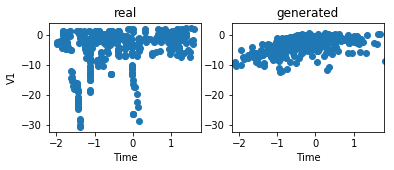

394 394
epoch: 4530, Accuracy: 0.9517766497461929
[4530/5001]	Loss_D: 0.0003	Loss_G: -0.0113	


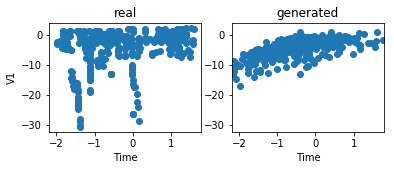

394 394
epoch: 4540, Accuracy: 0.9517766497461929
[4540/5001]	Loss_D: -0.0000	Loss_G: -0.0098	


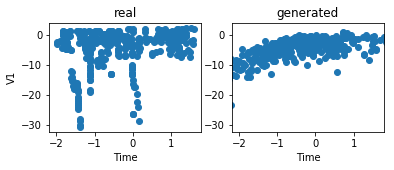

394 394
epoch: 4550, Accuracy: 0.9543147208121827
[4550/5001]	Loss_D: -0.0083	Loss_G: 0.0494	


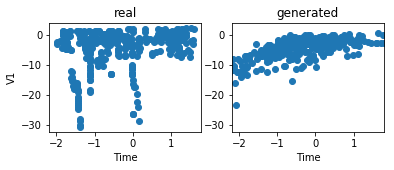

394 394
epoch: 4560, Accuracy: 0.9593908629441624
[4560/5001]	Loss_D: -0.0042	Loss_G: -0.0300	


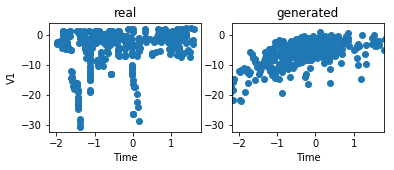

394 394
epoch: 4570, Accuracy: 0.9670050761421319
[4570/5001]	Loss_D: -0.2887	Loss_G: -0.0613	


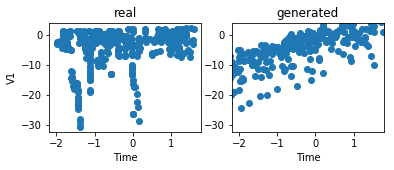

394 394
epoch: 4580, Accuracy: 0.9263959390862944
[4580/5001]	Loss_D: -0.0917	Loss_G: -0.1762	


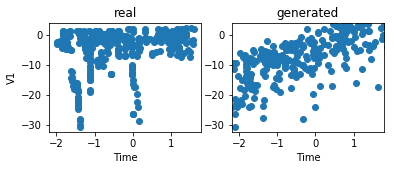

394 394
epoch: 4590, Accuracy: 0.9847715736040609
[4590/5001]	Loss_D: -1.1172	Loss_G: -0.1644	


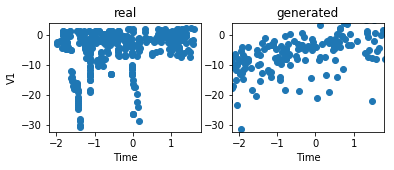

394 394
epoch: 4600, Accuracy: 0.9746192893401016
[4600/5001]	Loss_D: -0.1943	Loss_G: -0.0950	


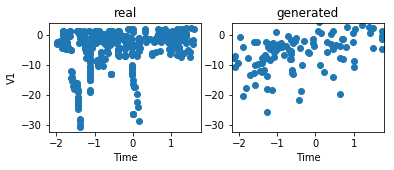

394 394
epoch: 4610, Accuracy: 0.9644670050761421
[4610/5001]	Loss_D: -0.2433	Loss_G: -0.2322	


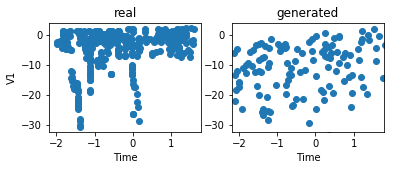

394 394
epoch: 4620, Accuracy: 0.9822335025380711
[4620/5001]	Loss_D: -0.4602	Loss_G: -0.2893	


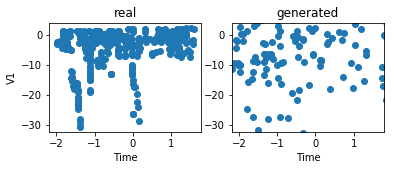

394 394
epoch: 4630, Accuracy: 0.9695431472081218
[4630/5001]	Loss_D: -0.0266	Loss_G: -0.2398	


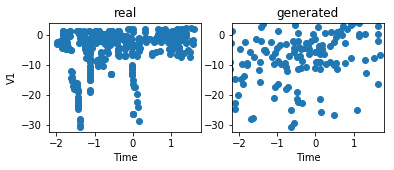

394 394
epoch: 4640, Accuracy: 0.9670050761421319
[4640/5001]	Loss_D: 0.0032	Loss_G: -0.0181	


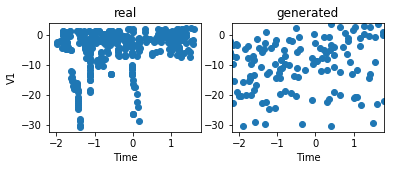

394 394
epoch: 4650, Accuracy: 0.9695431472081218
[4650/5001]	Loss_D: 0.0003	Loss_G: -0.0136	


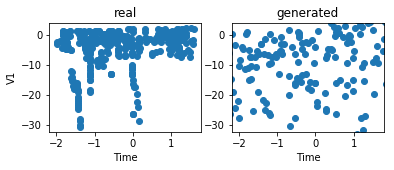

394 394
epoch: 4660, Accuracy: 0.9746192893401016
[4660/5001]	Loss_D: 0.0001	Loss_G: -0.0123	


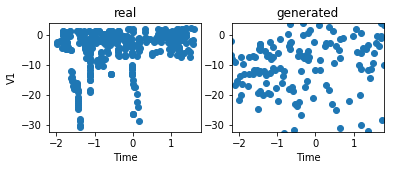

394 394
epoch: 4670, Accuracy: 0.9771573604060914
[4670/5001]	Loss_D: -0.0002	Loss_G: -0.0121	


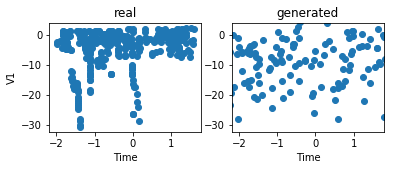

394 394
epoch: 4680, Accuracy: 0.9771573604060914
[4680/5001]	Loss_D: -0.0019	Loss_G: -0.0126	


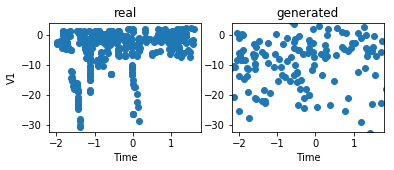

394 394
epoch: 4690, Accuracy: 0.9543147208121827
[4690/5001]	Loss_D: -0.7504	Loss_G: -0.0564	


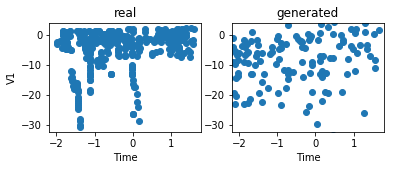

394 394
epoch: 4700, Accuracy: 0.9746192893401016
[4700/5001]	Loss_D: -0.1682	Loss_G: 0.0629	


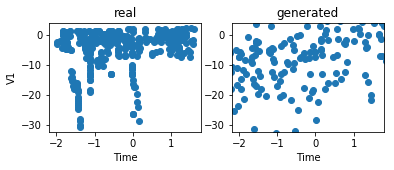

394 394
epoch: 4710, Accuracy: 0.9644670050761421
[4710/5001]	Loss_D: -0.1593	Loss_G: 0.1096	


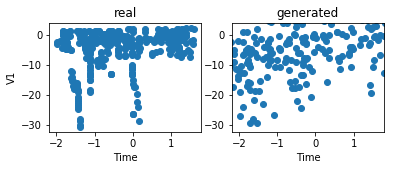

394 394
epoch: 4720, Accuracy: 0.9619289340101523
[4720/5001]	Loss_D: -0.1038	Loss_G: 0.0953	


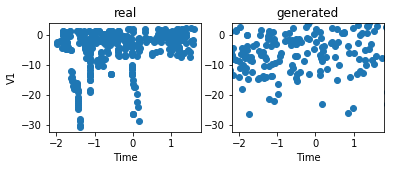

394 394
epoch: 4730, Accuracy: 0.9543147208121827
[4730/5001]	Loss_D: -0.0649	Loss_G: 0.0516	


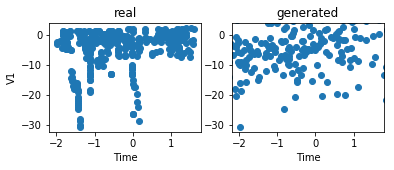

394 394
epoch: 4740, Accuracy: 0.9517766497461929
[4740/5001]	Loss_D: -0.0858	Loss_G: 0.0361	


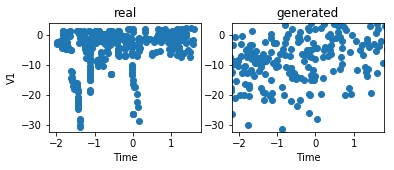

394 394
epoch: 4750, Accuracy: 0.9568527918781726
[4750/5001]	Loss_D: -0.1060	Loss_G: 0.3074	


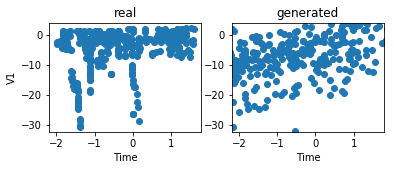

394 394
epoch: 4760, Accuracy: 0.9543147208121827
[4760/5001]	Loss_D: -0.0270	Loss_G: 0.0669	


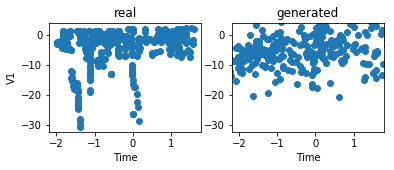

394 394
epoch: 4770, Accuracy: 0.949238578680203
[4770/5001]	Loss_D: -0.1825	Loss_G: 0.0188	


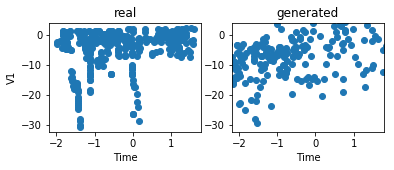

394 394
epoch: 4780, Accuracy: 0.9568527918781726
[4780/5001]	Loss_D: -0.1757	Loss_G: 0.2140	


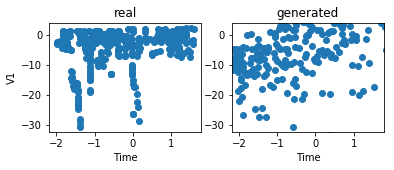

394 394
epoch: 4790, Accuracy: 0.9619289340101523
[4790/5001]	Loss_D: -0.1692	Loss_G: 0.2258	


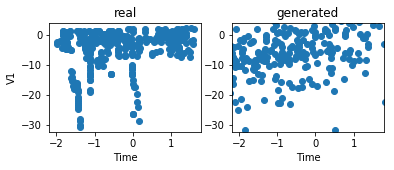

394 394
epoch: 4800, Accuracy: 0.949238578680203
[4800/5001]	Loss_D: -0.0952	Loss_G: 0.1141	


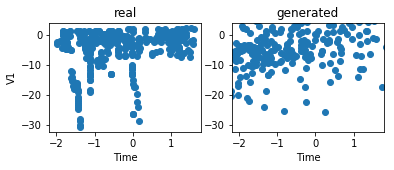

394 394
epoch: 4810, Accuracy: 0.9416243654822335
[4810/5001]	Loss_D: -0.5136	Loss_G: -0.1640	


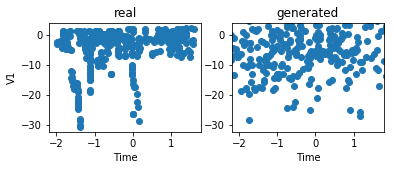

394 394
epoch: 4820, Accuracy: 0.9543147208121827
[4820/5001]	Loss_D: -0.2544	Loss_G: -0.2633	


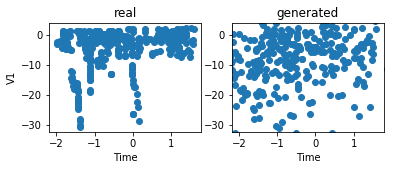

394 394
epoch: 4830, Accuracy: 0.9441624365482234
[4830/5001]	Loss_D: -0.2028	Loss_G: -0.0674	


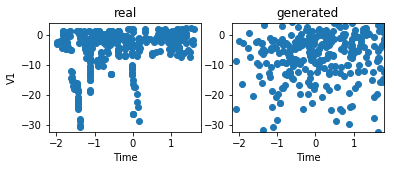

394 394
epoch: 4840, Accuracy: 0.9467005076142132
[4840/5001]	Loss_D: -0.3818	Loss_G: -0.0640	


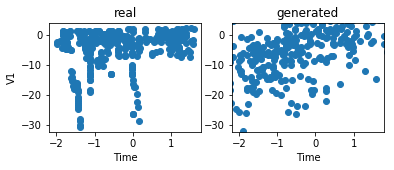

394 394
epoch: 4850, Accuracy: 0.9593908629441624
[4850/5001]	Loss_D: -0.4802	Loss_G: -0.1590	


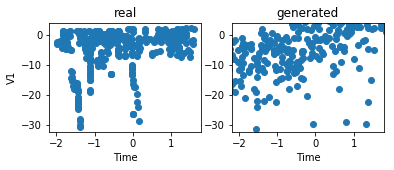

394 394
epoch: 4860, Accuracy: 0.9390862944162437
[4860/5001]	Loss_D: -0.2042	Loss_G: -0.0419	


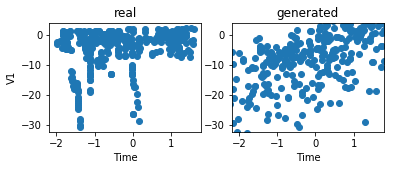

394 394
epoch: 4870, Accuracy: 0.9390862944162437
[4870/5001]	Loss_D: -0.7413	Loss_G: -0.1877	


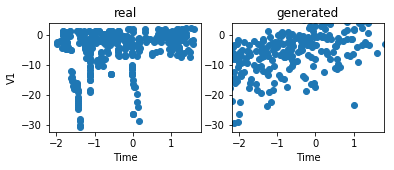

394 394
epoch: 4880, Accuracy: 0.9416243654822335
[4880/5001]	Loss_D: -0.1149	Loss_G: -0.0114	


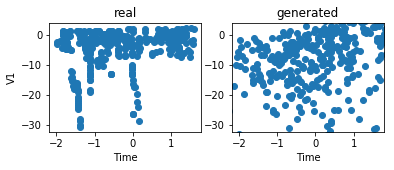

394 394
epoch: 4890, Accuracy: 0.9517766497461929
[4890/5001]	Loss_D: -0.0856	Loss_G: -0.0035	


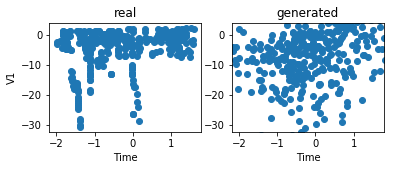

394 394
epoch: 4900, Accuracy: 0.9619289340101523
[4900/5001]	Loss_D: -0.1323	Loss_G: -0.0230	


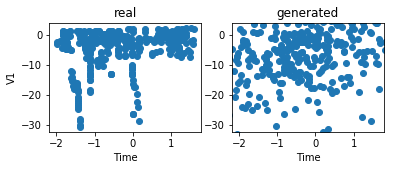

394 394
epoch: 4910, Accuracy: 0.9517766497461929
[4910/5001]	Loss_D: -0.2135	Loss_G: -0.0460	


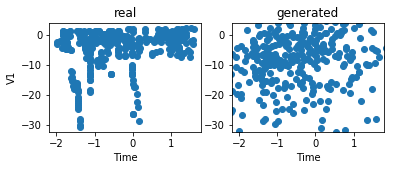

394 394
epoch: 4920, Accuracy: 0.9390862944162437
[4920/5001]	Loss_D: -0.1961	Loss_G: -0.0280	


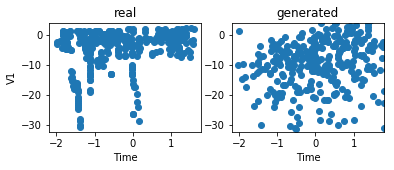

394 394
epoch: 4930, Accuracy: 0.9416243654822335
[4930/5001]	Loss_D: -0.4826	Loss_G: -0.1187	


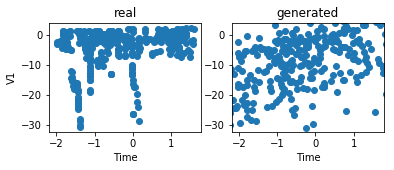

394 394
epoch: 4940, Accuracy: 0.9568527918781726
[4940/5001]	Loss_D: -0.2030	Loss_G: -0.1060	


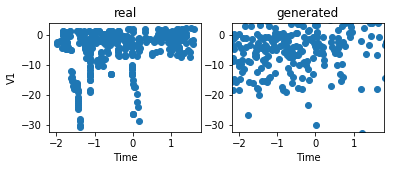

394 394
epoch: 4950, Accuracy: 0.949238578680203
[4950/5001]	Loss_D: -0.1760	Loss_G: -0.0904	


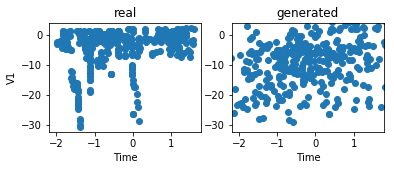

394 394
epoch: 4960, Accuracy: 0.9238578680203046
[4960/5001]	Loss_D: -0.3699	Loss_G: -0.0834	


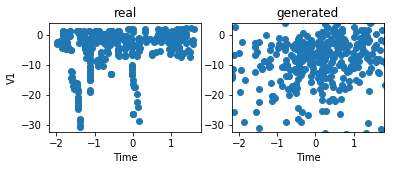

394 394
epoch: 4970, Accuracy: 0.9543147208121827
[4970/5001]	Loss_D: -0.2172	Loss_G: -0.0449	


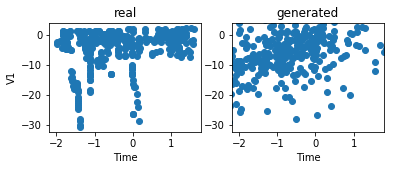

394 394
epoch: 4980, Accuracy: 0.9543147208121827
[4980/5001]	Loss_D: -0.4903	Loss_G: -0.0664	


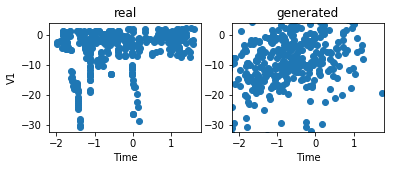

394 394
epoch: 4990, Accuracy: 0.9543147208121827
[4990/5001]	Loss_D: -0.1294	Loss_G: -0.0351	


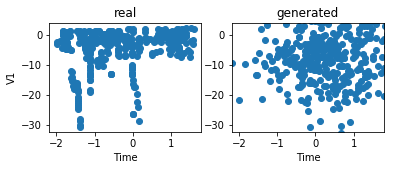

394 394
epoch: 5000, Accuracy: 0.9365482233502538
[5000/5001]	Loss_D: -0.3841	Loss_G: -0.2034	


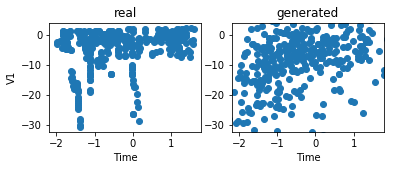

It took  1753.0570719242096


In [15]:
xgblosses, G_losses, D_Losses, generated_data, real_data_list = wgan.train(dataloader, randomNoise_dim = 32, hidden_dim = 128, realData_dim =dataloader.dataset.features.size(1), lr = 0.0002, num_epochs=5000, feature_cols=feature_cols, device='cpu')

In [16]:
len(generated_data)

394

In [17]:
xgblosses

array([0.97715736, 1.        , 0.8680203 , 0.98984772, 0.98477157,
       1.        , 0.99238579, 1.        , 0.99238579, 1.        ,
       0.97969543, 0.97461929, 0.9822335 , 0.99492386, 0.98984772,
       0.97461929, 0.99492386, 1.        , 0.98984772, 0.97461929,
       0.97461929, 0.99492386, 1.        , 0.98984772, 0.97715736,
       0.96192893, 0.98477157, 0.97208122, 0.97461929, 0.98984772,
       0.98984772, 0.97969543, 0.98984772, 0.96700508, 0.96700508,
       0.87817259, 0.97715736, 0.97969543, 0.97969543, 0.98477157,
       0.97208122, 0.95431472, 0.97969543, 0.96700508, 0.98730964,
       0.95431472, 0.95685279, 0.98477157, 0.99492386, 0.96700508,
       0.98477157, 0.90862944, 0.9822335 , 0.97715736, 0.98730964,
       0.95431472, 0.97461929, 0.96700508, 0.98730964, 0.99492386,
       0.97461929, 0.97461929, 0.9822335 , 0.98984772, 0.97969543,
       0.98730964, 0.98984772, 0.98477157, 0.96446701, 0.97969543,
       0.97715736, 0.97715736, 0.97208122, 0.97969543, 0.97969

In [18]:
number = 0.87817259

In [19]:
for i in range(xgblosses.size):
    if np.round(xgblosses[i],6) == np.round(np.min(xgblosses[100:]),6):
        best_round = i*10
        print(best_round)

1150


In [54]:
w=200

0.8781725888324873


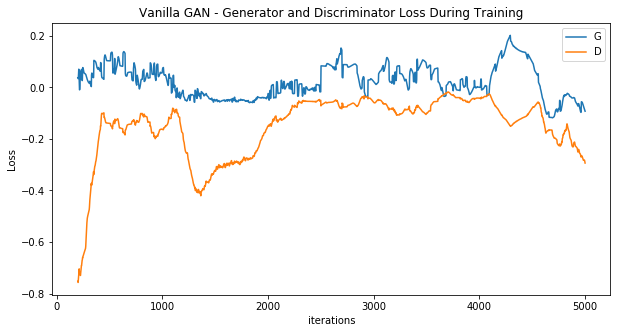

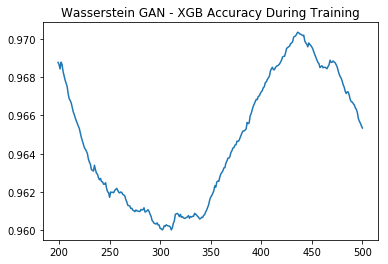

In [55]:
print(min(xgblosses[10:]))
plt.figure(figsize=(10,5))
plt.title(f"Vanilla GAN - Generator and Discriminator Loss During Training")
b = pd.DataFrame(G_losses[:]).rolling(w).mean()
c = pd.DataFrame(D_Losses[:]).rolling(w).mean()
# plt.plot(G_losses,label="G")
# plt.plot(D_Losses,label="D")
plt.plot(b,label="G")
plt.plot(c,label="D")

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f'reports/figures/gan/GAN.png')
plt.show()


a = pd.DataFrame(xgblosses[:]).rolling(w).mean()
plt.title(f"Wasserstein GAN - XGB Accuracy During Training")
plt.plot(a)
plt.savefig(f'reports/figures/gan/xgblosses_GAN.png')
plt.show()

In [22]:
amount=train.shape[0]
device='cpu'

In [23]:
train.shape[0]

227845

In [24]:
randomNoise_dim = 32; hidden_dim = 128; realData_dim =dataloader.dataset.features.size(1)

In [25]:
#best_round = 4250

In [26]:
more_data = wgan.generate_data(best_round, randomNoise_dim, hidden_dim, realData_dim, amount, 'cpu')

In [27]:
more_data = more_data.detach().numpy()

In [28]:
b = np.ones((more_data.shape[0],more_data.shape[1]+1))
b[:,:-1] = more_data

In [29]:
b.shape

(227845, 31)

In [30]:
df_generatedData = pd.DataFrame(b, columns = feature_cols + label_col)
df_generatedData.head()

Time        V1        V2        V3        V4        V5        V6  \
0 -0.271996 -1.267508  0.860777 -1.272638  1.044561 -0.531074 -0.522286   
1 -0.177054 -2.271398  1.229006 -2.251440  1.332888 -1.408208 -0.299532   
2  0.170046 -0.128135 -0.781294 -0.049690 -0.609031 -0.130929  0.216333   
3 -0.012553  0.465521  0.835842 -1.316415  2.430924  0.750138 -0.374254   
4 -0.023188  0.238450  0.117772 -1.185546  1.035193  0.477795 -0.872893   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0 -0.920172  0.349469 -0.354175  ...  0.276886 -0.048534 -0.076530 -0.078687   
1 -1.899564  0.804069 -0.699567  ...  0.216403 -0.050461  0.059454  0.022280   
2  0.287890 -0.087948  0.433575  ...  0.292796  0.132222 -0.040817 -0.025691   
3  0.421622  0.769706 -0.934999  ...  0.221260 -0.239709 -0.182075 -0.050661   
4 -0.594133 -0.021716 -0.496468  ...  0.706179 -0.027275 -0.445005 -0.161702   

        V25       V26       V27       V28    Amount  Class  
0 -0.011874  0.103098  0.077250  0.101103  0.153437    1.0  
1 -0.100288  0.090904 -0.083977  0.025183  0.161296    1.0  
2 -0.335861 -0.039775 -0.013886 -0.057062  0.275699    1.0  
3  0.098305  0.029429  0.182804  0.147061 -0.252586    1.0  
4 -0.043680 -0.064483  0.415380  0.194159 -0.330910    1.0  

[5 rows x 31 columns]

In [31]:
train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [32]:
train = train.append(df_generatedData)
train = train.sample(frac=1)

In [33]:
train.shape

(455690, 31)

In [34]:
train.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [35]:
train_y = train.Class

In [36]:
train_y

278521    0.0
125501    0.0
250769    0.0
144903    0.0
133350    0.0
44875     0.0
82052     0.0
6077      0.0
185703    1.0
154886    1.0
100269    1.0
100971    0.0
205082    1.0
184073    0.0
65114     0.0
60765     1.0
16661     1.0
253729    0.0
114463    0.0
8850      1.0
80046     0.0
194049    0.0
269892    0.0
9013      0.0
138307    0.0
105983    1.0
156586    1.0
67468     0.0
178516    1.0
16461     0.0
         ... 
18566     1.0
16370     0.0
158624    0.0
17813     0.0
14322     1.0
142037    1.0
242057    0.0
22055     0.0
50941     1.0
149128    0.0
169553    0.0
265082    0.0
5547      1.0
129240    1.0
143110    0.0
140516    1.0
219466    1.0
65153     0.0
77246     1.0
221195    0.0
3266      0.0
127907    1.0
44429     0.0
189910    0.0
41299     0.0
206629    1.0
97294     1.0
271149    0.0
152821    0.0
188717    1.0
Name: Class, Length: 455690, dtype: float64

In [37]:
train_y.isnull().sum()

0

In [38]:
train_X = train

In [39]:
train_X.drop('Class', axis=1, inplace=True)

# XGBoost

In [40]:
train_y.head()

278521    0.0
125501    0.0
250769    0.0
144903    0.0
133350    0.0
Name: Class, dtype: float64

In [41]:
train_X.head()

Time        V1        V2        V3        V4        V5        V6  \
278521  1.547209  0.100582 -0.097679  0.563935 -0.895863  0.245786 -0.184776   
125501 -0.360079  1.347283  0.365949 -0.277916  0.784055  0.451706 -0.157267   
250769  1.268994  0.651970 -2.576133 -1.543930  0.597336 -0.617385  0.758859   
144903 -0.175065 -0.182395  1.404550  0.789311  2.726416  1.275516 -0.435930   
133350 -0.304212 -0.465423  1.233448  1.326932  0.133223  0.627591 -0.329881   

              V7        V8        V9  ...       V20       V21       V22  \
278521 -0.069180  0.188724  1.239512  ... -0.199924  0.317388  0.923205   
125501  0.214748 -0.167423  0.014076  ... -0.075537 -0.060893 -0.094913   
250769  0.348711 -0.009989  0.889694  ...  1.317723  0.242405 -0.790949   
144903  1.153838 -0.178018 -2.004714  ... -0.145659  0.312463  0.825327   
133350  0.905475 -0.315033 -0.432166  ...  0.349583 -0.332414 -0.692862   

             V23       V24       V25       V26       V27       V28    Amount  
278521  0.459129  0.435378 -2.150878 -0.880239  0.399876  0.390651 -0.228455  
125501 -0.275241 -0.992829  0.889644 -0.242817  0.015100  0.006721 -0.338250  
250769 -0.340944 -0.141601 -0.560405 -0.698820 -0.103833  0.081406  2.445851  
144903 -0.253481 -0.016706  0.066418  0.076944  0.021583  0.049999 -0.332170  
133350 -0.229031 -0.485980 -0.102255  0.199805  0.025155 -0.050440 -0.336524  

[5 rows x 30 columns]

In [42]:
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [43]:
test_X.head()

Time         V1        V2         V3        V4         V5  \
43428  -1.122118 -16.526507  8.584972 -18.649853  9.505594 -13.793819   
49906  -1.064083   0.339812 -2.743745  -0.134070 -1.385729  -1.451413   
29474  -1.248907   1.399590 -0.590701   0.168619 -1.029950  -0.539806   
276481  1.523119  -0.432071  1.647895  -1.669361 -0.349504   0.785785   
278846  1.551547   2.014160 -0.137394  -1.015839  0.327269  -0.182179   

              V6         V7        V8        V9  ...       V20       V21  \
43428  -2.832404 -16.701694  7.517344 -8.507059  ... -1.514923  1.190739   
49906   1.015887  -0.524379  0.224060  0.899746  ...  0.506044 -0.213436   
29474   0.040444  -0.712567  0.002299 -0.971747  ...  0.212877  0.102398   
276481 -0.630647   0.276990  0.586025 -0.484715  ... -0.244633  0.358932   
278846 -0.956571   0.043241 -0.160746  0.363241  ... -0.255293 -0.238644   

             V22       V23       V24       V25       V26       V27       V28  \
43428  -1.127670 -2.358579  0.673461 -1.413700 -0.462762 -2.018575 -1.042804   
49906  -0.942525 -0.526819 -1.156992  0.311211 -0.746647  0.040996  0.102038   
29474   0.168269 -0.166639 -0.810250  0.505083 -0.232340  0.011409  0.004634   
276481  0.873663 -0.178642 -0.017171 -0.207392 -0.157756 -0.237386  0.001934   
278846 -0.616400  0.347045  0.061561 -0.360196  0.174730 -0.078043 -0.070571   

          Amount  
43428  -1.988452  
49906  -1.985169  
29474  -1.995469  
276481 -1.996090  
278846 -1.996103  

[5 rows x 30 columns]

In [44]:
start_time = time.time()
dtrain = xgb.DMatrix(train_X, train_y, feature_names=feature_cols)
dtest = xgb.DMatrix(test_X, feature_names=feature_cols)

results_dict = {}

param = {
        'max_depth':5, 
        'eta':0.3, 
        'verbosity': 1, 
        'objective':'binary:logistic', 
        'eval_metric': 'auc', 
        'seed': 42
        }

model = xgb.train(param, dtrain, num_boost_round=100)
# make prediction
preds = np.round(model.predict(dtest))
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

/home/chinne/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/chinne/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Time elapsed to train:  45.50795269012451


In [45]:
print('---' * 45)
print('XGBoost ROC/AUC: {:.6f}'.format(roc_auc_score(test_y, preds)))
print('Recall Score: {:.6f}'.format(recall_score(test_y, preds)))
print('Precision Score: {:.6f}'.format(precision_score(test_y, preds)))
print('F1 Score: {:.6f}'.format(f1_score(test_y, preds)))
print('Accuracy Score: {:.6f}'.format(accuracy_score(test_y, preds)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
XGBoost ROC/AUC: 0.924535
Recall Score: 0.857143
Precision Score: 0.154696
F1 Score: 0.262090
Accuracy Score: 0.991696
---------------------------------------------------------------------------------------------------------------------------------------


In [46]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve

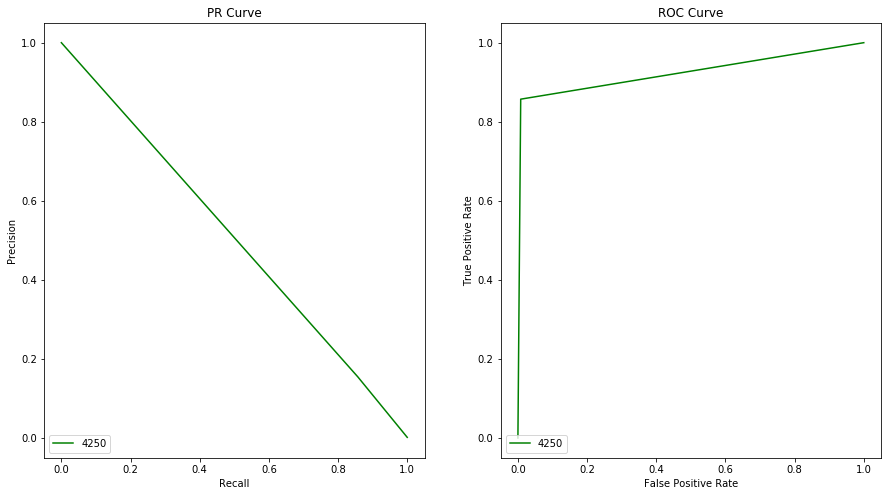

In [47]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')


p,r,_ = precision_recall_curve(test_y,preds)
tpr,fpr,_ = roc_curve(test_y,preds)

ax1.plot(r,p,c='g',label=best_round)
ax2.plot(tpr,fpr,c='g',label=best_round)
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()